In [1]:
# Load libraries
import pandas as pd 
import numpy as np
from collections import Counter, OrderedDict
import tqdm
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS

import re
import fasttext as ft
from nltk.tokenize import wordpunct_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
import en_core_web_lg
from spacy.matcher import Matcher
nlp = en_core_web_lg.load()
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

# tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Phrases
import tomotopy as tp
import pyLDAvis
import tmplot
stop = set(stopwords.words('english'))
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# import emoji

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/xiaohangan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/xiaohangan/opt/anaconda3/envs/DTVC/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/xiaohangan/opt/anaconda3/envs/DTVC/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/xiaohangan/opt/anaconda3/envs/DTVC/lib/python3.7/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/xiaohangan/opt/anaconda3/envs/DTVC/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes a

# Define the function

In [2]:
# Creating a function for preliminary exploration for youtube comment's datasets
def prelim_explor_yt(df, column_name, comment_id):
    # See information of the dataset
    print(df.info())
    print('------------')
    # drop the row with the NaN in text
    df = df.dropna(subset=column_name)
    df.reset_index(drop=True, inplace=True)
    # Calculating the number if words
    df['word_count'] = df[column_name].apply(lambda x: len(str(x).split(' ')))
    print(df['word_count'].describe())
    print('------------')
    # Creating a column that separate the main text with it's replies
    df['main'] = df[comment_id].str.contains("\.")
    df['main'].replace({False:1,True:0}, inplace=True)
    # Exploring the dataset
    replies = sum(df[comment_id].str.contains("\.")) 
    print('''
    Data information
    --------------------------------------
    Total number of comments: {}
    Total number of main comments: {}
    Total number of replies: {}
    Average lenght of each reply: {} characters
    Average words per comment: {} words
    --------------------------------------
    '''.format(df.shape[0], df.shape[0]-replies, replies, round(sum(df[column_name].apply(len))/df.shape[0],2), round(np.mean(df.word_count),1) ))
    return df

def prelim_explor_speakev(df, column_name): 
    # See information of the dataset
    print(df.info())
    print('------------')
    # drop duplicated row
    df = df.drop_duplicates(subset='Comment', keep="first")
    df.reset_index(drop=True, inplace=True)
    # Calculating the number if words
    df['word_count'] = df[column_name].apply(lambda x: len(str(x).split(' ')))
    print(df['word_count'].describe())
    print('------------')
    # Exploring the dataset
    print('''
    Data information
    --------------------------------------
    Total number of comments: {}
    Average lenght of each reply: {} characters
    Average words per comment: {} words
    --------------------------------------
    '''.format(df.shape[0], round(sum(df[column_name].apply(len))/df.shape[0],2), round(np.mean(df.word_count),1) ))
    return df


def prelim_explor_twitter(df, column_name): 
    # See information of the dataset
    print(df.info())
    print('------------')
    # Calculating the number if words
    df['word_count'] = df[column_name].apply(lambda x: len(str(x).split(' ')))
    print(df['word_count'].describe())
    print('------------')
    # Exploring the dataset
    print('''
    Data information
    --------------------------------------
    Total number of comments: {}
    Average lenght of each reply: {} characters
    Average words per comment: {} words
    --------------------------------------
    '''.format(df.shape[0], round(sum(df[column_name].apply(len))/df.shape[0],2), round(np.mean(df.word_count),1) ))
    return df

## Language Detection

In [3]:
# Detect the language of the text with fasttext for youtube

# Load the pretrained model
ft_model = ft.load_model("/Users/xiaohangan/Desktop/NLP/Final/model.pt/lid.176.bin")

# Creating the function to detect the language
def lang_detect(text):
    # finding the prediction for the language
    prediction = ft_model.predict(text)
    # pre-process the result to extract the abbreviation of the language
    language = prediction[0][0].split('__')[2]
    return language

# Create a function to detect the function for each comment
def text_lang(df, column_name):
    # iterated through the data
    lang = []
    for text in tqdm.tqdm(df[column_name]):
        try:
            lang.append(lang_detect(text))
        except:
            lang.append('No lang')

    df.loc[:, 'Language'] = lang

    # Find the top 10 languages
    print('---Top 10 Languages---')
    print(df['Language'].value_counts()[:5])

    return df

# Create a function to include only the comments in inglish
def english_text(df):
    # Taking only the english comments
    df = df[df['Language']== 'en']
    df.reset_index(drop=True, inplace=True)
    print(df.shape)
    return df

## Most Frequent Words

In [4]:
# plotting the top stopwords in the data
def plot_top_stopwords_barchart(text):
    
    new=text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(),key=lambda x:x[1],reverse=True)[:20]
    x,y=zip(*top)
    plt.figure(figsize=(20,10))
    plt.xlabel('Top 20 Stopwords').set_fontsize(20)
    plt.ylabel('Frequency').set_fontsize(20)
    plt.bar(x,y)
    plt.title("The Frequency of the Top 20 Stopwords").set_fontsize(40)

## Text Cleaning

In [5]:
# For Youtube
# Creating the list of stopwords
stop_words = set(stopwords.words('english'))

# Create a function that findings and drops the duplicates
def drop_duplicate(df, column_name):
    # Finding the duplicates
    print('Number of comments before:', df.shape[0])
    print('-----------------')
    print('Number of dublicated comments:', sum(df[column_name].duplicated()))
    #print('Number of dublicated comments:', sum(df.duplicated()))
    # Removing the dubplicates
    df = df.drop_duplicates(subset=[column_name], keep='first')
    print('-----------------')
    print('Number of comments after:', df.shape[0])
    return df

# Creating the cleaninng function

nlp = en_core_web_lg.load()

def cleaning_text_speakEV(raw_text):

    # Remove HTML tags
    text = re.sub('<.*?>','', raw_text)
    # Remove href links
    text = re.sub(r'@^(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z0-9][a-z0-9\-]*$@i','',text)
    # Remove everything that is not word and the numbers
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    # Remove 39 coming from special character " ' "
    text = text.replace('39',' ')
    # Removing emojis
    remove_emoji = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    text = remove_emoji.sub(r'', text)
    # Changing the multiple spaces to one
    text = re.sub('\s+',' ', text)
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # remove space 
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    # Convert to lowercase
    text = text.lower()
    # Remove the extra space in the beginning and the end of the text
    text = text.strip()
    # Take the lemmatisated version of the text
    text = [token.lemma_ for token in nlp(text) if (not token.is_stop) & (not token.is_punct) & (not token.like_num)]
    # Recreate the text with the lemmatised version of the words
    text = " ".join(text)

    return text


def cleaning_text_twitter(raw_text):

   # text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    #text = re.sub('<.*?>','', raw_text)
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", raw_text)

    text = re.sub("@([a-zA-Z0-9_]{1,50})", '', text)
   # text = re.sub('<.*?>','', raw_text)
    # Remove everything that is not word and the numbers
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    # Remove 39 coming from special character " ' "
    text = text.replace('39',' ')
    # Changing the multiple spaces to one
    text = re.sub('\s+',' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove the extra space in the beginning and the end of the text
    text = text.strip()
    # Take the lemmatisated version of the text
    text = [token.lemma_ for token in nlp(text) if (not token.is_stop)]
    # Recreate the text with the lemmatised version of the words
    text = " ".join(text)

    return text

In [6]:
def most_freq(df, column_name):
    #Identify common words
    ## list of stopwords
    ## Remove them 
    ## Take the most frequent
    most_freq = pd.Series(' '.join(df[column_name]).split()).value_counts()[:20] # tocenization except from stopwords
    most_freq = pd.DataFrame(most_freq)
    print('---Most frequent words---')
    print(most_freq)

# Most frequent word
def most_freq_speakEV(df, column_name,Stopwords):
     corpus_tkns=[]
     docs_list = df[column_name].to_list()
     for item in Stopwords:                      
          nlp.vocab[item].is_stop = True
     df[column_name] = [cleaning_text_speakEV(comment) for comment in df[column_name]]

     most_freq = pd.Series(' '.join(df[column_name]).split()).value_counts()[:20] # tocenization except from stopwords
     most_freq = pd.DataFrame(most_freq)
     print('---Most frequent words---')
     print(most_freq)
     return most_freq

## Topic Modelling

In [7]:
# creating a function with relevant preprocessing of comments to choose k topic models using LDA, and finalising
# the one k with the best coherence score
def tm_combined(df,comments,k, Stopwords):
    nlp = en_core_web_lg.load()
    for item in Stopwords:                      
         nlp.vocab[item].is_stop = True

    # # Removing the empty comments
    # for i in len(comments):
    # #         df = df.reset_index(drop = True)
    # comments = [item for item in comments if len(item)>0]

    
    # # Removing the empty comments in combined dataframe
    # df = df.reset_index(drop = True)

    # Tokenising the words in the corpus
    docs_tokens, tmp_tokens = [], []
    for comment in comments:
        tmp_tokens = [
            token.lemma_
            for token in nlp(comment)
            if not token.is_stop and not token.is_punct and not token.like_num
        ]
        docs_tokens.append(tmp_tokens)
        tmp_tokens = []

    bigram = Phrases(                              
        docs_tokens,
        min_count=20,    # Minimum number of appaerences in the corpus (probably 20 for small texts)
        threshold=10,     # Represent a score threshold for forming the phrases (higher means fewer phrases)
        max_vocab_size=50000,
        
    )
    trigram = Phrases(                           
        bigram[docs_tokens],
        min_count=20,
        threshold=10,
        max_vocab_size=50000,
        
    )

    # Creating the new documents with the bigrams and trigrams
    docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
    
    # contains the drop index
    drop_index = []
    for index in range(0,len(docs_phrased)):
        if len(docs_phrased[index]) == 0:
            drop_index.append(index)

    # Initialising a new corpus
    corpus = tp.utils.Corpus()
    # populate the corpus
    for item in docs_phrased:
        corpus.add_doc(words=item)

    
    cvs = {}                                     # Create the dictionary for the coherence scores per topic
    for topic_number in range(1, k+1, 1):        # Try different topic numbers
        mdl = tp.LDAModel(k=topic_number, corpus=corpus, seed=257)
        for i in range(0, 1000, 10):
            mdl.train(10)
            print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
        coh = tp.coherence.Coherence(mdl, coherence="u_mass")
        cvs[topic_number] = coh.get_score()

    fig = plt.figure(figsize=(25, 8))
    ax = fig.add_subplot(111)
    ax.plot(cvs.keys(), cvs.values(), "o-")
    ax.set_xlabel("Number of topics retained")
    ax.set_ylabel("Coherence score")
    ax.set_xticks(range(1,k+1,1))
    plt.show()
    
    topic_size=min(cvs, key=cvs.get) # Topic Size is the best number of topics
    best_mdl = tp.LDAModel(k=topic_size, corpus=corpus, seed=257) # Create the final model with the optimal number of topics
    
    return (cvs, corpus, best_mdl, topic_size, docs_phrased,drop_index)

# Function to retrain the best model
def train_tm(model):
    for i in range(0, 100, 4):  
        model.train(10)
        print("Iteration: {}\tLog-likelihood: {}".format(i, model.ll_per_word))
    return(model)

# Creating a function to prepare the data for visualisation
def topic_plot_data(best_mdl):
    topic_term_dists = np.stack([best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in best_mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs]) 
    vocab = list(best_mdl.used_vocabs)                                
    term_frequency = best_mdl.used_vocab_freq

    prepared_data = pyLDAvis.prepare(
            topic_term_dists, 
            doc_topic_dists, 
            doc_lengths, 
            vocab, 
            term_frequency,
            start_index=0, 
            sort_topics=False 
        )
    return prepared_data


In [8]:
# creating a function with relevant preprocessing of comments to choose k topic models using LDA, and finalising
# the one k with the best coherence score
def tm_wholeev(df,comments,k, Stopwords):
    nlp = en_core_web_lg.load()
    for item in Stopwords:                      
         nlp.vocab[item].is_stop = True

    # # Removing the empty comments
    # for i in len(comments):
    # #         df = df.reset_index(drop = True)
    # comments = [item for item in comments if len(item)>0]

    
    # # Removing the empty comments in combined dataframe
    # df = df.reset_index(drop = True)

    # Tokenising the words in the corpus
    docs_tokens, tmp_tokens = [], []
    for comment in comments:
        tmp_tokens = [
            token.lemma_
            for token in nlp(comment)
            if not token.is_stop and not token.is_punct and not token.like_num
        ]
        docs_tokens.append(tmp_tokens)
        tmp_tokens = []

    bigram = Phrases(                              
        docs_tokens,
        min_count=20,    # Minimum number of appaerences in the corpus (probably 20 for small texts)
        threshold=15,     # Represent a score threshold for forming the phrases (higher means fewer phrases)
        max_vocab_size=50000,
        
    )
    trigram = Phrases(                           
        bigram[docs_tokens],
        min_count=20,
        threshold=15,
        max_vocab_size=50000,
        
    )

    # Creating the new documents with the bigrams and trigrams
    docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
    
    # contains the drop index
    drop_index = []
    for index in range(0,len(docs_phrased)):
        if len(docs_phrased[index]) == 0:
            drop_index.append(index)

    # Initialising a new corpus
    corpus = tp.utils.Corpus()
    # populate the corpus
    for item in docs_phrased:
        corpus.add_doc(words=item)

    
    cvs = {}                                     # Create the dictionary for the coherence scores per topic
    for topic_number in range(1, k+1, 1):        # Try different topic numbers
        mdl = tp.LDAModel(k=topic_number, corpus=corpus, seed=257) #  In performing topic modeling, words that appear repeatedly in only one document do not contribute to estimating the topic-word distribution.
        for i in range(0, 1000, 10):
            mdl.train(10)
            print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
        coh = tp.coherence.Coherence(mdl, coherence="u_mass")
        cvs[topic_number] = coh.get_score()

    fig = plt.figure(figsize=(25, 8))
    ax = fig.add_subplot(111)
    ax.plot(cvs.keys(), cvs.values(), "o-")
    ax.set_xlabel("Number of topics retained")
    ax.set_ylabel("Coherence score")
    ax.set_xticks(range(1,k+1,1))
    plt.show()
    
    topic_size=min(cvs, key=cvs.get) # Topic Size is the best number of topics
    best_mdl = tp.LDAModel(k=topic_size, corpus=corpus, seed=257) # Create the final model with the optimal number of topics
    
    return (cvs, corpus, best_mdl, topic_size, docs_phrased,drop_index)

## Sentiment Analysis

In [9]:
def cleaning_text_sentiment_speakEV(raw_text):
    
    # Removing the links
    text = re.sub(r'http\S+', '', raw_text)
    # Remove href links
    text = re.sub(r'@^(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z0-9][a-z0-9\-]*$@i','',text)
    # Escaping HTML character
    text = BeautifulSoup(text).get_text()
    # Remove punctuation
    text = re.sub("[\.\,\!\?\:\;\-\=]", " ", text)
    # Remove the hastages and tags
    text = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", text)
    # Remove all single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    # Removing emojis
    remove_emoji = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    text = remove_emoji.sub(r'', text)
    # Changing the multiple spaces to one
    text = re.sub('\s+',' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove the extra space in the beginning and the end of the text
    text = text.strip()
    # Remove the words contain numbers
    text = re.sub("\d[A-Za-z0-9]+"," ",text)
    # Take the lemmatisated version of the text
    if len(text)>0:
        text = [token.lemma_ for token in nlp(text) if (not token.is_punct) & (not token.like_num) & (not token.is_stop)]                #### Removing the spacy stop words because contain more negative words
        # Recreate the text with the lemmatised version of the words
        text = " ".join(text)
    return text

In [10]:
# Creating the function for sentiment analysis
def sentiment(df, column_name):
    sid = SentimentIntensityAnalyzer()
    df["sentiments"] = df[column_name].apply(lambda x: sid.polarity_scores(x))
    df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

    # decide sentiment as positive, negative and neutral
    sentiment = []
    for compound in tqdm.tqdm(df['compound']):
        if compound >= 0.05 :
            sentiment.append('pos')
        elif compound <= - 0.05 :
            sentiment.append('neg')
        else :
            sentiment.append('neu')
    df.loc[:,'sentiment'] = sentiment

    return df

# Creating a function for preliminary exploration for general comment's datasets
def sentiment_explor_speakEV(df, column_name,column_name2): 
    df.reset_index(drop=True, inplace=True)
    # Calculating the number if words
    df['word_count'] = df[column_name].apply(lambda x: len(str(x).split(' ')))
    
    pos_comments = sum(df['compound']>0.05)
    pos_comments_pecentage = round (pos_comments/len(df)*100, 1)
    
    neg_comments = sum(df['compound']<-0.05)
    neg_comments_pecentage = round (neg_comments/len(df)*100, 1)
    
    neu_comments = sum(df[df['compound']>=-0.05]['compound']<=0.05)
    neu_comments_pecentage = round (neu_comments/len(df)*100, 1)

    # Super Pos/Neg comments
    sup_pos_comments = sum(df['compound']>0.5)
    sup_pos_comments_pecentage = round (sup_pos_comments/len(df)*100, 1)

    sup_neg_comments = sum(df['compound']<-0.5)
    sup_neg_comments_pecentage = round (sup_neg_comments/len(df)*100, 1)
    

    #print(df['word_count'].describe())
    #print('------------')
    # Exploring the dataset
    print('''
    Data information
    --------------------------------------
    Total number of comments: {}
    Average lenght of each reply: {} characters
    Average words per comment: {} words
    
    Number of positive comments (compound >0.05) is {} ({}%)
    Number of negative comments (compound <-0.05) is {} ({}%)
    Number of neutral comments (compound is between -0.05 and 0.05) is {} ({}%)
    
    Number of super positive comments (compound > 0.5) is {} ({}%)
    Number of super negative comments (compound < -0.5) is {} ({}%)
    --------------------------------------
    '''.format(df.shape[0], round(sum(df[column_name].apply(len))/df.shape[0],2), round(np.mean(df.word_count),1), pos_comments, pos_comments_pecentage,
              neg_comments, neg_comments_pecentage, neu_comments, neu_comments_pecentage, sup_pos_comments, sup_pos_comments_pecentage,
              sup_neg_comments,sup_neg_comments_pecentage))
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10), gridspec_kw={'height_ratios': [2.5, 1]})
    
    sns.histplot(data=df, x="compound", color="red", label="Compound", kde=True, alpha = 0.1, ax = ax1).set_title('Sentiment distribution')
    sns.histplot(data=df, x="word_count", color="blue", label="Compound", kde=True, alpha = 0.1, ax = ax2).set_title('Number of words')
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    d = {'Negative': [neg_comments_pecentage], 'Neutral': [neu_comments_pecentage], 'Positive': [pos_comments_pecentage] }
    df_sent = pd.DataFrame(data = d)
    
    df_sent.plot(
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar for Sentiment in {}'.format(column_name2),

    mark_right = True,
    color = ['red', 'grey', 'green' ], alpha = 0.4,
    ax = ax3)
    
    for p in ax3.patches:
        left, bottom, width, height = p.get_bbox().bounds
        ax3.annotate(str(round(width,2)), xy=(left+width/2, bottom+height/2), 
                ha='center', va='center')

    
    ax3.axis('off')
    ax4.axis('off')
    
    return 


def sentiment_stats(df):
    # Inspecting the total sentiments of the df
    print('Count of total sentiments')
    print('=========================')
    print(df['sentiment'].value_counts())
    print('=========================')
    print('Average Compound of the corpus: {}'.format(round(np.mean(df['compound']),3)))

def stats_sentiment_elements(df):
    # Printing the descriptive statistics for the compound
    elements = ['compound', 'neg', 'neu', 'pos']
    for element in elements: 
        print('Descriptive statistics of', element)
        print('=========================')
        print(df[element].describe())
        print('')
        print('Distribution of '+ element)
        fig = plt.figure()
        ax1 = fig.add_subplot(1,2,1)
        ax2 = fig.add_subplot(1,2,2)
        sns.histplot(data= df, x=element, label=element, kde=True, alpha = 0.5, ax= ax1)
        sns.boxplot(df[element], color='orange', ax= ax2)
        
        plt.show()

def best_worst_comment(df,column_name):
    # Find the worst comment
    wost_index = df[df.compound== min(df.compound)].index.values[0]
    print('''
    Worst Comment
    -------------
    {}'''.format(df[column_name][wost_index]))

    # Find the best comment
    best_index = df[df.compound== max(df.compound)].index.values[0]
    print('''
    Best Comment
    -------------
    {}'''.format(df[column_name][best_index]))

## Keyword Extraction

In [11]:
def extract_model_speakEV(df, column1, column2, model, model_list):
    result_list =[]
    df['temp'] = df[column1] + df[column2]
    extract_list = df['temp'].to_list()
    for text in extract_list: 
        if any(model_text in text for model_text in model_list):
            result_list.append(1)
        else:
            result_list.append(0)
    df[model] = result_list
    return df

In [12]:
def extracting_BEV_youtube(df, column_name):
    BEV_1 = df[df[column_name].str.contains('fiat|Fiat') & df[column_name].str.contains('500|car|model') & df[column_name].str.contains('electric|Electric|new|New|500e|500 e')]
    BEV_2 = df[df[column_name].str.contains('fiat|Fiat') & df[column_name].str.contains('electric|Electric|new|New|500e|500 e')]
    BEV_3 = df[df[column_name].str.contains('fiat500e|Fiat500e|fiat500|Fiat500')]
    BEV = pd.concat([BEV_1, BEV_2, BEV_3], axis=0)
    BEV.drop_duplicates(inplace=True)
    return BEV

def extracting_hybrid_youtube(df, column_name):
    hyb_1 = df[df[column_name].str.contains('fiat|Fiat') & df[column_name].str.contains('500|car|model|hybrid|Hybrid')]
    hyb_2 = df[df[column_name].str.contains('fiat500|Fiat500')]
    hybrid = pd.concat([hyb_1, hyb_2], axis=0)
    hybrid.drop_duplicates(inplace=True)
    return hybrid


# Q1 The difference between Fiat 500 BEV and Fiat 500 Hybrid

### Extract Words -- Fiat 500 BEV & Hybrid

In [167]:

def extracting_BEV(df, column_name1,column_name2):
    df['column_name'] = df[column_name1]+  df[column_name2]
    BEV_1 = df[df['column_name'].str.contains('fiat|fca|car|model') &  df['column_name'].str.contains('500e|500 e|e500|e 500')]
    BEV_2 = df[df['column_name'].str.contains('fiat|fca|car|model') & df['column_name'].str.contains('new|electric') & df['column_name'].str.contains('500|500e|500 e')]
    BEV_3 = df[df['column_name'].str.contains('fiat500e｜fiat500 e|500e|500 e|e500|e 500|500 electric|electric 500')]
    BEV_4 = df[df['column_name'].str.contains('fiat|car|model') &  df['column_name'].str.contains('500e|500 e|e500|e 500')]
    BEV_5 = df[df['column_name'].str.contains('fiat|car|model') & df['column_name'].str.contains('new|electric') & df['column_name'].str.contains('500|500e|500 e')]
    BEV = pd.concat([BEV_1, BEV_2, BEV_3,BEV_4,BEV_5], axis=0)
    BEV_index = list(BEV.index.values)
    mention_bitcoin = df[df['column_name'].str.contains('bitcoin|crypto')]
    df.loc[BEV_index,'Fiat500e'] =1
    df.loc[list(mention_bitcoin.index.values), 'Fiat500e'] = 0
    df['Fiat500e'] = df['Fiat500e'].replace(np.nan,0)
    # BEV.drop_duplicates(inplace=True)
    # BEV['Fiat500e'] = np.repeat(1,len(BEV))
    # BEV['Fiat500hybrid'] = np.repeat(0,len(BEV))
    # BEV = BEV.reset_index(drop=True)
    return df

def extracting_hybrid(df):
    hyb_1 = df[df['column_name'].str.contains('hybrid|car|model') & df['column_name'].str.contains('500')]
    hyb_2 = df[df['column_name'].str.contains('fiat500')] 
    hyb_3 = df[df['column_name'].str.contains('fiat 500|old 500')]
    hybrid = pd.concat([hyb_1, hyb_2,hyb_3], axis=0)
    mention_bitcoin = df[df['column_name'].str.contains('bitcoin|crypto')]
    hybrid_index = list(hybrid.index.values)
    df.loc[hybrid_index,'Fiat500hybrid'] =1
    df.loc[list(mention_bitcoin.index.values), 'Fiat500hybrid'] = 0
    df['Fiat500hybrid'] = df['Fiat500hybrid'].replace(np.nan,0)
    # hybrid.drop_duplicates(inplace=True)
    # hybrid['Fiat500e'] =np.repeat(0,len(hybrid))
    # hybrid['Fiat500hybrid'] =np.repeat(1,len(hybrid))
    # hybrid = hybrid.reset_index(drop=True)
    return df

def extracting_combined(df):
    BEV = df.loc[(df['Fiat500e'] ==1) & (df['Fiat500hybrid'] !=1)]
    hybrid = df.loc[(df['Fiat500e'] !=1) & (df['Fiat500hybrid'] ==1)]
    compare = df.loc[(df['Fiat500e'] ==1) & (df['Fiat500hybrid'] ==1)]
    combine = pd.concat([BEV,hybrid,compare],axis=0)
    combine_index = list(combine.index.values)
    compare_index = list(compare.index.values)
    df.loc[combine_index, 'Fiat500'] = 1
    df.loc[compare_index,'Compare']=1
    df['Fiat500'] = df['Fiat500'].replace(np.nan,0)
    df['Compare'] = df['Compare'].replace(np.nan,0)
    combine.loc[combine_index,'Compare']=1
    combine['Compare'] = combine['Compare'].replace(np.nan,0)
    combine.drop_duplicates(subset = ['Comment'],inplace=True)
    # combine['Fiat500e'] = combine['Fiat500e'].replace(np.nan, 0)
    # combine['Fiat500hybrid'] = combine['Fiat500hybrid'].replace(np.nan, 0)
    # combine['Compare'] = combine['Compare'].replace(np.nan, 0)
    combine = combine.reset_index(drop=True)
    return combine, BEV, hybrid, df


def extracting_fiat(df):
    mention_fiat = df[df['column_name'].str.contains('fiat')]
    mention_bitcoin = df[df['column_name'].str.contains('bitcoin|crypto')]
    # mention_fiat = mention_fiat[~mention_bitcoin.index.values] #exclude fiat bitcoin
    df.loc[list(mention_fiat.index.values), 'Fiat'] = 1
    df.loc[list(mention_bitcoin.index.values), 'Fiat'] = 0
    df['Fiat'] = df['Fiat'].replace(np.nan,0)
    fiat_brand = df.loc[(df['Fiat'] ==1) & (df['Fiat500'] !=1)]
    df.loc[list(fiat_brand.index.values),'Fiat_Brand'] = 1
    df['Fiat_Brand'] = df['Fiat_Brand'].replace(np.nan,0)
    fiat_brand = df.loc[(df['Fiat500'] !=1) & (df['Fiat_Brand'] ==1)]
    fiat500_brand = df.loc[(df['Fiat500e'] ==1) | (df['Fiat500hybrid'] ==1)]

    return fiat_brand, fiat500_brand, df


In [171]:
speakEV_fiat500_full_df = pd.read_csv('0801_Fiat500_subforum_speakEV.csv',index_col=0)

# Extract Fiat 500e & Fiat 500hybrid subset
speakEV_fiat500_full_df['Comment'] = speakEV_fiat500_full_df['Comment'].str.lower()
speakEV_fiat500_full_df['Thread Title'] = speakEV_fiat500_full_df['Thread Title'].str.lower()
speakEV_fiat500_full_df = speakEV_fiat500_full_df.rename(columns = {'Thread Title':'Thread_Title'})

# append Fiat 500e column
speakEV_fiat500_full_df = extracting_BEV(speakEV_fiat500_full_df, 'Comment','Thread_Title')

# append Fiat 500 hybrid column
speakEV_fiat500_full_df = extracting_hybrid(speakEV_fiat500_full_df)

# append both Fiat 500e and 500 hybrid column; combined dataset
speakEV_fiat500_combined, speakEV_fiat500e,speakEV_fiat500hyb,speakEV_fiat500_full_df = extracting_combined(speakEV_fiat500_full_df)

# mentioned fiat
speakEV_fiat_brand, speakEV_fiat500_brand, speakEV_fiat500_full_df =  extracting_fiat(speakEV_fiat500_full_df)

print("The number of comments mentioned Fiat brand: {}.".format(speakEV_fiat_brand.shape))
print("The number of comments mentioned Fiat500 brand: {}.".format(speakEV_fiat500_brand.shape))
print("The number of comments mentioned both Fiat 500e and 500 hybrid: {}.".format(sum(speakEV_fiat500_combined['Compare']==1)))
print("The number of comments mentioned Fiat 500e: {}.".format(speakEV_fiat500e.shape))
print("The number of comments mentioned Fiathybrid/Fiat 500: {}.".format(speakEV_fiat500hyb.shape))

The number of comments mentioned Fiat brand: (162, 14).
The number of comments mentioned Fiat500 brand: (951, 14).
The number of comments mentioned both Fiat 500e and 500 hybrid: 951.
The number of comments mentioned Fiat 500e: (241, 10).
The number of comments mentioned Fiathybrid/Fiat 500: (182, 10).


In [822]:
feature_extraction = pd.DataFrame()
feature_extraction['Fiat 500 BEV'] = [speakEV_fiat500e.shape[0]]
feature_extraction['Fiat 500 Hybrid'] = [speakEV_fiat500hyb.shape[0]]
feature_extraction['Fiat 500 BEV & Hybrid'] = [speakEV_fiat500_combined.shape[0]]
feature_extraction['Fiat 500 Brand'] = [speakEV_fiat500_brand.shape[0]]
feature_extraction['Fiat Brand'] = [speakEV_fiat_brand.shape[0]]
feature_extraction.index = ['Commont Counts']
# feature_extraction['BEVs'] = [speakEV_BEV_wholeev.shape[0]]
feature_extraction

,Fiat 500 BEV,Fiat 500 Hybrid,Fiat 500 BEV & Hybrid,Fiat 500 Brand,Fiat Brand,BEVs
Commont Counts,241,182,951,848,161,1805


## Explorational Analysis

In [252]:
# Explorational analysis
prelim_explor_speakev(speakEV_fiat500_combined,'Comment')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserID                 951 non-null    int64  
 1   Username               912 non-null    object 
 2   Link of user profile   951 non-null    object 
 3   Num of posts per user  951 non-null    object 
 4   Thread_Title           951 non-null    object 
 5   Comment                951 non-null    object 
 6   Discussion Date        951 non-null    object 
 7   column_name            951 non-null    object 
 8   Fiat500e               951 non-null    float64
 9   Fiat500hybrid          951 non-null    float64
 10  Compare                951 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 81.9+ KB
None
------------
count     951.000000
mean       95.301788
std       118.190259
min         1.000000
25%        28.000000
50%        57.000000
75%       11

,UserID,Username,Link of user profile,Num of posts per user,Thread_Title,Comment,Discussion Date,column_name,Fiat500e,Fiat500hybrid,Compare,word_count
0,96270,Alnair,https://www.speakev.com/members/alnair.96270/,579,how should the stellantis forum be organised?,that's a good point - i can confirm that while...,"Mar 24, 2022",that's a good point - i can confirm that while...,1.0,0.0,1.0,28
1,2505,cah197,https://www.speakev.com/members/cah197.2505/,"26,262",leather free evs?,that’s different.\n\nthe 500 has always had pr...,"Mar 10, 2022",that’s different.\n\nthe 500 has always had pr...,1.0,0.0,1.0,9
2,2505,cah197,https://www.speakev.com/members/cah197.2505/,"26,262",new fiat panda coming - most affordable ev?,"\nthis looks very cool, and is promised to com...","Jan 18, 2022","\nthis looks very cool, and is promised to com...",1.0,0.0,1.0,57
3,2505,cah197,https://www.speakev.com/members/cah197.2505/,"26,262",new fiat panda coming - most affordable ev?,my money's on the same running gear as the 500...,"Jan 18, 2022",my money's on the same running gear as the 500...,1.0,0.0,1.0,10
4,97879,CHERYLWARD,https://www.speakev.com/members/cherylward.97879/,402,new fiat panda coming - most affordable ev?,\nat least it might be ev from the ground up.\...,"Jan 18, 2022",\nat least it might be ev from the ground up.\...,1.0,0.0,1.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...
946,98903,LaserTam,https://www.speakev.com/members/lasertam.98903/,46,500e discounts available?,"thanks.\nyes, i am being offered the deposit c...","Sep 10, 2021","thanks.\nyes, i am being offered the deposit c...",1.0,1.0,1.0,72
947,99112,marko68,https://www.speakev.com/members/marko68.99112/,15,500e discounts available?,"hi laser tam,just joined,i have ordered a fiat...","Sep 20, 2021","hi laser tam,just joined,i have ordered a fiat...",1.0,1.0,1.0,99
948,98703,Mkultra,https://www.speakev.com/members/mkultra.98703/,558,tesla remotely disables 80 miles of range from...,nevertheless it's part of the new trading cond...,"Jul 31, 2022",nevertheless it's part of the new trading cond...,1.0,1.0,1.0,132
949,98703,Mkultra,https://www.speakev.com/members/mkultra.98703/,558,tesla remotely disables 80 miles of range from...,sure the article makes that clear but again is...,"Jul 31, 2022",sure the article makes that clear but again is...,1.0,1.0,1.0,100


### Most Frequent Words

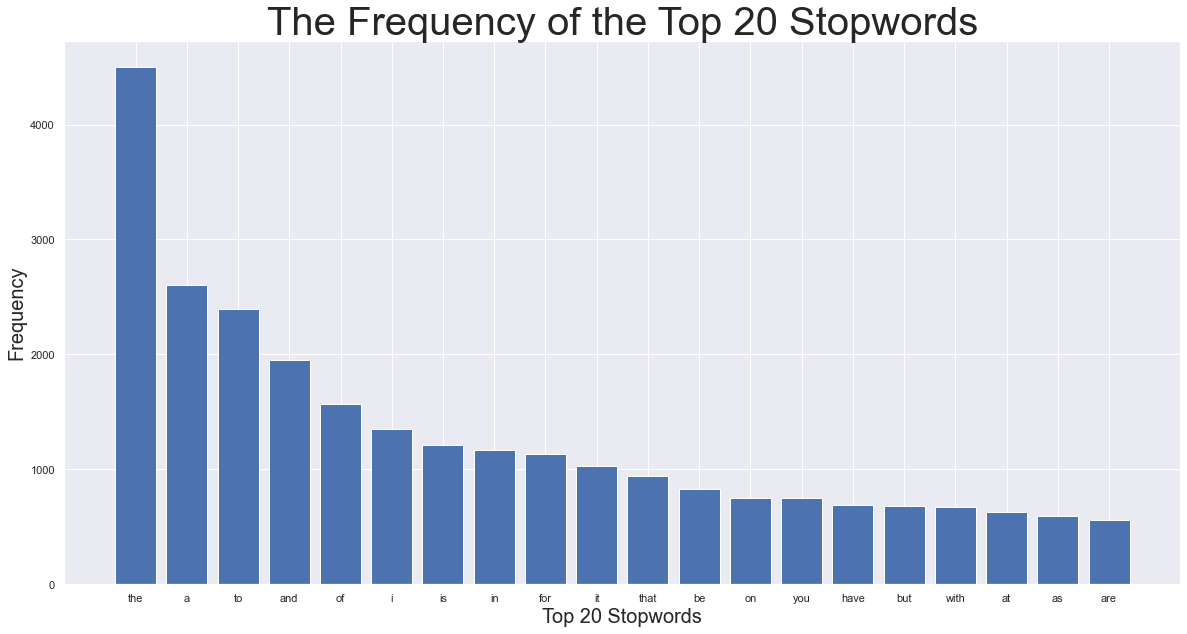

In [253]:
# plotting the top stopwords in the data
plot_top_stopwords_barchart(speakEV_fiat500_combined['Comment'])

In [254]:
speakEV_Stopwords = ['the','a','to','and','of','i','is','in','for','it','that','be','on','you','with',
                'but','hav','are','as','at','car','year','ev','fiat','don','d','ve','www','like','need','think','m',
                's','t','e','o','ll','didn','doesn','aren','isn','km','kg','etc','se','g','5k','se','ac',
                'fiat','isn','vw','mini','zoe','bmw','corsa','leaf','tesla','nissan','bev','evs','ev','e208','panda',
                'etc','model','new','vauxhall','peugeote','peugeot','renault','honda','mercedes','volkswagen','volvo','i3',
                'hyundai','ioniq','citroen','ev6','kia','kona','cat','com','op','zs','12v','ok','id4','wouldn']

In [255]:
# Text Cleaning
# Create the corpus
clean_corpus_combined = [cleaning_text_speakEV(comment) for comment in speakEV_fiat500_combined['Comment']]

# add clean corpus to dataframe
speakEV_fiat500_combined['Clean_Corpus'] = clean_corpus_combined

In [256]:
# Check Discussion Date 2020-01-01 - now
speak_bev_hybrid = speakEV_fiat500_combined.copy()
speak_bev_hybrid['date'] = pd. to_datetime(speak_bev_hybrid['Discussion Date'])
speak_bev_hybrid['month_year'] = pd.to_datetime(speak_bev_hybrid['date']).dt.to_period('M')
speak_bev_hybrid = speak_bev_hybrid.loc[speak_bev_hybrid['month_year'].between('2020-01-01','2022-08-01', inclusive=True)]


### Model mentioned counts through time

In [257]:
# model mentioned counts through time
speak_bev_hybrid_df = speak_bev_hybrid.groupby(['month_year']) ['Fiat500e','Fiat500hybrid'].sum().reset_index()
speak_bev_hybrid_df['month_year'] = pd.to_datetime(speak_bev_hybrid_df['month_year'].astype(str))
speak_bev_hybrid_df

,month_year,Fiat500e,Fiat500hybrid
0,2020-01-01,3.0,4.0
1,2020-02-01,124.0,42.0
2,2020-03-01,10.0,14.0
3,2020-04-01,2.0,3.0
4,2020-05-01,5.0,6.0
5,2020-06-01,1.0,1.0
6,2020-07-01,7.0,8.0
7,2020-08-01,0.0,3.0
8,2020-09-01,8.0,13.0
9,2020-10-01,16.0,18.0


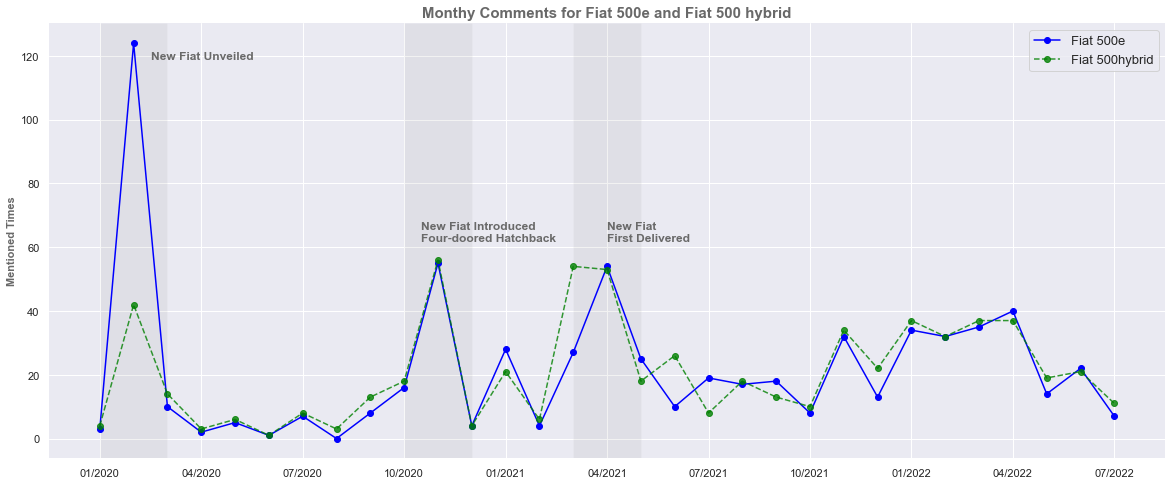

In [258]:
# Import Library
import matplotlib.pyplot as plt
# Plot Mentioned Counts
fig = plt.figure(figsize = (20,8), facecolor = None)
ax = fig.add_subplot(111)

# ax.plot(speak_bev_hybrid_df['month_year'],speak_bev_hybrid_df["Fiat500e"], marker='o', label = 'Fiat 500e', c= 'blue')
# ax.plot(speak_bev_hybrid_df['month_year'],speak_bev_hybrid_df["Fiat500hybrid"], marker='o',label = 'Fiat 500hybrid', c= 'green',ls ='--',alpha = 0.8)

t = np.arange(0,31,1)
ax.plot(t,speak_bev_hybrid_df["Fiat500e"], marker='o', label = 'Fiat 500e', c= 'blue')
ax.plot(t,speak_bev_hybrid_df["Fiat500hybrid"], marker='o',label = 'Fiat 500hybrid', c= 'green',ls ='--',alpha = 0.8)

ax.set_xticks(range(0,31,3))
ax.set_xticklabels([speak_bev_hybrid_df['month_year'].dt.strftime('%m/%Y')[i] for i in range(0,31,3)])

# Display
## aest
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#highlight the peak 
plt.axvspan(0,2, facecolor='grey', alpha=0.1)
plt.axvspan(9,11, facecolor='grey', alpha=0.1)
plt.axvspan(14,16, facecolor='grey', alpha=0.1)

# add text annotation
# 1st Peak # New Fiat was unveiled on March 4, 2020 in Milan
ax.annotate("New Fiat Unveiled", xy=(1, 124), xytext=(1.5, 119), weight='bold',
            size = 12 , color="dimgray")

# 2nd Peak # Fiat introduced a four-doored hatchback in 2020-10
ax.annotate("New Fiat Introduced \nFour-doored Hatchback", xy=(9.5, 62), xytext=(9.5, 62), weight='bold',
            size = 12 , color="dimgray")

# 3rd Peak  # new fiat first deliveries are expected to arrive in March 2021.
ax.annotate("New Fiat \nFirst Delivered", xy=(15, 62), xytext=(15,62), weight='bold',
            size = 12 , color="dimgray")


# Labelling 
# plt.xlabel("Discussion Date")
plt.ylabel("Mentioned Times", color = 'dimgray', size = 11, fontweight='bold')
plt.title("Monthy Comments for Fiat 500e and Fiat 500 hybrid", color = 'dimgray', size = 15, fontweight='bold')

plt.legend(prop = {'size':13})
plt.show()


## Topic Modelling - Fiat 500 BEV & Fiat 500 Hybrid

Iteration: 0	Log-likelihood: -8.114351713857774
Iteration: 10	Log-likelihood: -8.114351713857774
Iteration: 20	Log-likelihood: -8.114351713857774
Iteration: 30	Log-likelihood: -8.114351713857774
Iteration: 40	Log-likelihood: -8.114351713857774
Iteration: 50	Log-likelihood: -8.114351713857774
Iteration: 60	Log-likelihood: -8.114351713857774
Iteration: 70	Log-likelihood: -8.114351713857774
Iteration: 80	Log-likelihood: -8.114351713857774
Iteration: 90	Log-likelihood: -8.114351713857774
Iteration: 100	Log-likelihood: -8.114351713857774
Iteration: 110	Log-likelihood: -8.114351713857774
Iteration: 120	Log-likelihood: -8.114351713857774
Iteration: 130	Log-likelihood: -8.114351713857774
Iteration: 140	Log-likelihood: -8.114351713857774
Iteration: 150	Log-likelihood: -8.114351713857774
Iteration: 160	Log-likelihood: -8.114351713857774
Iteration: 170	Log-likelihood: -8.114351713857774
Iteration: 180	Log-likelihood: -8.114351713857774
Iteration: 190	Log-likelihood: -8.114351713857774
Iteration: 

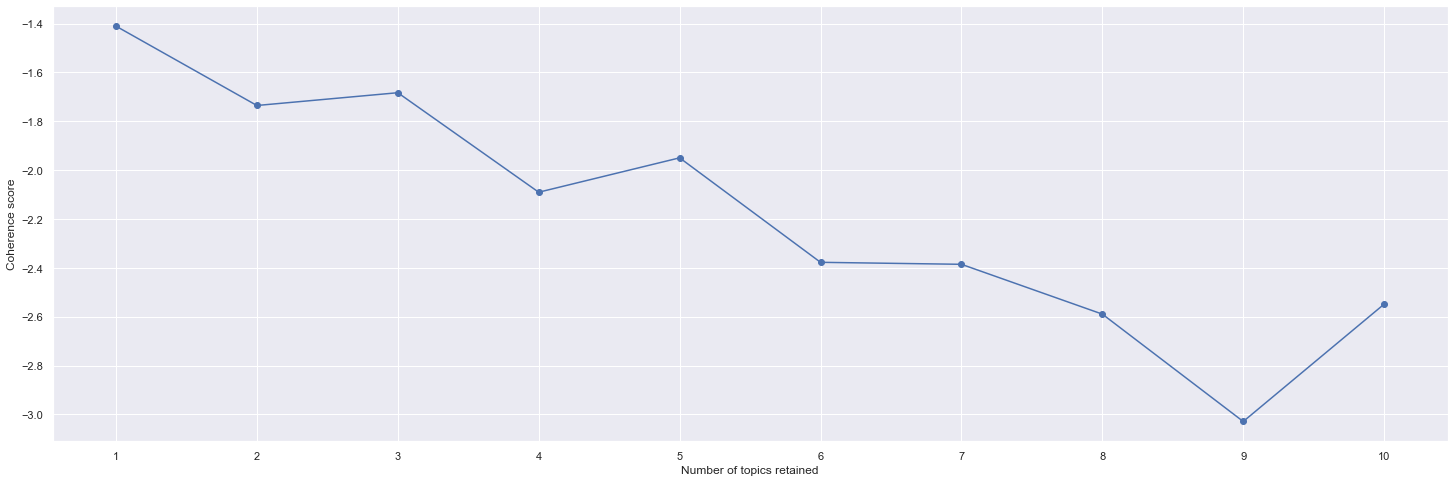

In [259]:
## Training LDAs to choose the best topic size
speaknEV_cvs, speaknEV_corpus, speaknEV_best_mdl, speaknEV_topic_size, speaknEV_docs_phrased,drop_index_combined = tm_combined(df= speakEV_fiat500_combined, comments= speakEV_fiat500_combined['Clean_Corpus'],k=10, Stopwords = speakEV_Stopwords)

In [260]:
speakEV_best_mdl_trained = train_tm(speaknEV_best_mdl)

Iteration: 0	Log-likelihood: -8.668484449379722
Iteration: 4	Log-likelihood: -8.476257320880265
Iteration: 8	Log-likelihood: -8.394745541784445
Iteration: 12	Log-likelihood: -8.33587021748273
Iteration: 16	Log-likelihood: -8.29866729123145
Iteration: 20	Log-likelihood: -8.284088994919376
Iteration: 24	Log-likelihood: -8.251661138334443
Iteration: 28	Log-likelihood: -8.239496779357705
Iteration: 32	Log-likelihood: -8.225801880624289
Iteration: 36	Log-likelihood: -8.224325783120861
Iteration: 40	Log-likelihood: -8.209675474800504
Iteration: 44	Log-likelihood: -8.19335904942675
Iteration: 48	Log-likelihood: -8.189522732650218
Iteration: 52	Log-likelihood: -8.173111686872462
Iteration: 56	Log-likelihood: -8.179575545962564
Iteration: 60	Log-likelihood: -8.175891495041258
Iteration: 64	Log-likelihood: -8.15980872221583
Iteration: 68	Log-likelihood: -8.158116797105736
Iteration: 72	Log-likelihood: -8.161022667788616
Iteration: 76	Log-likelihood: -8.160010142977175
Iteration: 80	Log-likelihoo

In [261]:
# Topic to word probabilities to understand words with the highest probabilities to occur in a topic and then
# to perhaps go back and include those words in custom stopwords in the LDA code
speakEV_wt_fiat500 = pd.DataFrame()
for k in range(speakEV_best_mdl_trained.k):
    words, probs = [], []
    for word, prob in speaknEV_best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    speakEV_wt_fiat500 = pd.concat([speakEV_wt_fiat500, tmp], ignore_index=False)
    del tmp

In [262]:
speakEV_wt_fiat500.sort_values('prob', ascending=False).head(10)

,word,prob,k,sort
0,electric,0.082,8,0
0,battery,0.077,6,0
0,charge,0.061,0,0
0,vehicle,0.051,1,0
1,mile,0.051,0,1
0,drive,0.048,5,0
0,price,0.046,4,0
0,month,0.040,7,0
0,500e,0.038,3,0
1,grant,0.037,4,1


In [263]:
# Dataframe withe final topics
topics_speakEV_fiat500 = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in speaknEV_best_mdl.docs]),
    columns=["Topic {}".format(i + 1) for i in range(speaknEV_best_mdl.k)])
topics_speakEV_fiat500

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,0.051550,0.016252,0.237338,0.124471,0.054931,0.028214,0.036307,0.269279,0.181658
1,0.073907,0.023301,0.231847,0.070030,0.078754,0.040450,0.160476,0.169217,0.152019
2,0.019918,0.269260,0.091703,0.194193,0.138104,0.127781,0.101688,0.045604,0.011749
3,0.073907,0.023301,0.231847,0.178453,0.187177,0.040450,0.160476,0.060794,0.043596
4,0.060737,0.019148,0.368735,0.146652,0.064720,0.033241,0.220980,0.049960,0.035827
...,...,...,...,...,...,...,...,...,...
941,0.024152,0.007615,0.288358,0.200045,0.167464,0.048651,0.017010,0.232459,0.014247
942,0.054480,0.004366,0.348177,0.114700,0.075703,0.068526,0.009753,0.316126,0.008169
943,0.029388,0.003756,0.142221,0.168566,0.152497,0.146323,0.130718,0.009799,0.216732
944,0.065052,0.005213,0.197422,0.258251,0.090395,0.106083,0.011646,0.110635,0.155303


In [264]:
# inspecting topic themes as a dataframe just out of curiosity.
speakEV_values = {}
for k in range(speaknEV_best_mdl.k):
    speakEV_values['Topic {}'.format(k+1)]= [("{},({})".format(word, str(np.round(prob, 3)))) for word, prob in speaknEV_best_mdl.get_topic_words(k)]
    # print the table
    #return (table)
speakEV_table_fiat500 = pd.DataFrame(speakEV_values)  
speakEV_table_fiat500

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,"charge,(0.061)","vehicle,(0.051)","look,(0.031)","500e,(0.038)","price,(0.046)","drive,(0.048)","battery,(0.077)","month,(0.04)","electric,(0.082)"
1,"mile,(0.051)","co2,(0.02)","good,(0.024)","dealer,(0.019)","grant,(0.037)","work,(0.027)","energy,(0.017)","lease,(0.033)","thing,(0.017)"
2,"charger,(0.022)","emission,(0.014)","range,(0.024)","try,(0.016)","cost,(0.026)","buy,(0.019)","power,(0.016)","pay,(0.03)","point,(0.016)"
3,"time,(0.021)","van,(0.013)","old,(0.019)","issue,(0.015)","ice,(0.018)","mph,(0.017)","fuel,(0.015)","buy,(0.024)","sound,(0.011)"
4,"range,(0.019)","fine,(0.011)","want,(0.019)","charge,(0.014)","people,(0.017)","sell,(0.015)","big,(0.014)","cost,(0.022)","co_uk,(0.011)"
5,"drive,(0.016)","customer,(0.009)","uk,(0.017)","come,(0.013)","market,(0.016)","engine,(0.015)","kwh,(0.013)","cheap,(0.019)","different,(0.01)"
6,"trip,(0.016)","plan,(0.009)","know,(0.016)","seat,(0.013)","manufacturer,(0.014)","want,(0.013)","mile,(0.011)","tax,(0.015)","road,(0.01)"
7,"use,(0.013)","camping,(0.009)","order,(0.016)","set,(0.013)","sale,(0.012)","fun,(0.012)","way,(0.011)","deal,(0.014)","review,(0.01)"
8,"long,(0.013)","industry,(0.009)","long,(0.014)","thank,(0.012)","money,(0.012)","owner,(0.012)","high,(0.011)","company,(0.013)","hybrid,(0.009)"
9,"home,(0.013)","spot,(0.009)","bit,(0.013)","cable,(0.01)","current,(0.011)","wheel,(0.01)","come,(0.01)","price,(0.013)","auto,(0.009)"


In [265]:
speak_table_rename = speakEV_table_fiat500.copy()
topic_labels = ['Charge Speed and Mile Range', 'Vehicle CO2 Emission', 'Quality Feeling' ,'La_prima Test Drive',
'Price and Car Grant','Configuration and Infortainment','Battery size and Power',
'Purchases and Lease','Safety and Car Insurance']
speak_table_rename.columns = topic_labels
speak_table_rename

,Charge Speed and Mile Range,Vehicle CO2 Emission,Quality Feeling,La_prima Test Drive,Price and Car Grant,Configuration and Infortainment,Battery size and Power,Purchases and Lease,Safety and Car Insurance
0,"charge,(0.061)","vehicle,(0.051)","look,(0.031)","500e,(0.038)","price,(0.046)","drive,(0.048)","battery,(0.077)","month,(0.04)","electric,(0.082)"
1,"mile,(0.051)","co2,(0.02)","good,(0.024)","dealer,(0.019)","grant,(0.037)","work,(0.027)","energy,(0.017)","lease,(0.033)","thing,(0.017)"
2,"charger,(0.022)","emission,(0.014)","range,(0.024)","try,(0.016)","cost,(0.026)","buy,(0.019)","power,(0.016)","pay,(0.03)","point,(0.016)"
3,"time,(0.021)","van,(0.013)","old,(0.019)","issue,(0.015)","ice,(0.018)","mph,(0.017)","fuel,(0.015)","buy,(0.024)","sound,(0.011)"
4,"range,(0.019)","fine,(0.011)","want,(0.019)","charge,(0.014)","people,(0.017)","sell,(0.015)","big,(0.014)","cost,(0.022)","co_uk,(0.011)"
5,"drive,(0.016)","customer,(0.009)","uk,(0.017)","come,(0.013)","market,(0.016)","engine,(0.015)","kwh,(0.013)","cheap,(0.019)","different,(0.01)"
6,"trip,(0.016)","plan,(0.009)","know,(0.016)","seat,(0.013)","manufacturer,(0.014)","want,(0.013)","mile,(0.011)","tax,(0.015)","road,(0.01)"
7,"use,(0.013)","camping,(0.009)","order,(0.016)","set,(0.013)","sale,(0.012)","fun,(0.012)","way,(0.011)","deal,(0.014)","review,(0.01)"
8,"long,(0.013)","industry,(0.009)","long,(0.014)","thank,(0.012)","money,(0.012)","owner,(0.012)","high,(0.011)","company,(0.013)","hybrid,(0.009)"
9,"home,(0.013)","spot,(0.009)","bit,(0.013)","cable,(0.01)","current,(0.011)","wheel,(0.01)","come,(0.01)","price,(0.013)","auto,(0.009)"


In [266]:
topic_larger_combined = topics_speakEV_fiat500.apply(lambda row: row.nlargest(2),axis=1)
topic_larger_combined = topic_larger_combined.div(topic_larger_combined.sum(axis=1), axis=0)
topic_larger_combined = topic_larger_combined.replace(np.nan,0)
topic_larger_combined

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,0.0,0.000000,0.468476,0.000000,0.000000,0.0,0.000000,0.531524,0.000000
1,0.0,0.000000,0.578080,0.000000,0.000000,0.0,0.000000,0.421920,0.000000
2,0.0,0.580986,0.000000,0.419014,0.000000,0.0,0.000000,0.000000,0.000000
3,0.0,0.000000,0.553302,0.000000,0.446698,0.0,0.000000,0.000000,0.000000
4,0.0,0.000000,0.625276,0.000000,0.000000,0.0,0.374724,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
941,0.0,0.000000,0.553665,0.000000,0.000000,0.0,0.000000,0.446335,0.000000
942,0.0,0.000000,0.524124,0.000000,0.000000,0.0,0.000000,0.475876,0.000000
943,0.0,0.000000,0.000000,0.437495,0.000000,0.0,0.000000,0.000000,0.562505
944,0.0,0.000000,0.433254,0.566746,0.000000,0.0,0.000000,0.000000,0.000000


In [267]:
# find the top 2 main topics
g = topic_larger_combined.filter(like='Topic')
topic_larger_combined['Main_topic1'] = g.idxmax(axis=1)
topic_larger_combined['Main_topic2'] = g.mask(g.eq(g.max(axis=1), axis=0) & g.apply(lambda x: ~x.duplicated(), axis=1)).idxmax(axis=1)
topic_larger_combined

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Main_topic1,Main_topic2
0,0.0,0.000000,0.468476,0.000000,0.000000,0.0,0.000000,0.531524,0.000000,Topic 8,Topic 3
1,0.0,0.000000,0.578080,0.000000,0.000000,0.0,0.000000,0.421920,0.000000,Topic 3,Topic 8
2,0.0,0.580986,0.000000,0.419014,0.000000,0.0,0.000000,0.000000,0.000000,Topic 2,Topic 4
3,0.0,0.000000,0.553302,0.000000,0.446698,0.0,0.000000,0.000000,0.000000,Topic 3,Topic 5
4,0.0,0.000000,0.625276,0.000000,0.000000,0.0,0.374724,0.000000,0.000000,Topic 3,Topic 7
...,...,...,...,...,...,...,...,...,...,...,...
941,0.0,0.000000,0.553665,0.000000,0.000000,0.0,0.000000,0.446335,0.000000,Topic 3,Topic 8
942,0.0,0.000000,0.524124,0.000000,0.000000,0.0,0.000000,0.475876,0.000000,Topic 3,Topic 8
943,0.0,0.000000,0.000000,0.437495,0.000000,0.0,0.000000,0.000000,0.562505,Topic 9,Topic 4
944,0.0,0.000000,0.433254,0.566746,0.000000,0.0,0.000000,0.000000,0.000000,Topic 4,Topic 3


In [268]:
prepared_data= topic_plot_data(speaknEV_best_mdl)
pyLDAvis.display(prepared_data)

Topic Modelling for Fiat500e & Fiat500hybrid:
- Topic 0: Charge Speeds and Mile Range
- Topic 1: Vehicle CO2 Emission
- Topic 2: Quality Feeling
- Topic 3: La_Prima Test Drive
- Topic 4: Price and Car Grant
- Topic 5: Configuration and Infotainment
- Topic 6: Battery size and Power
- Topic 7: Purchases and Lease
- Topic 8: Safety and Car Insurance 


In [44]:
# Find the most representative document for each topic
def top_n_topics (df_with_topics, df_with_tweets, df_with_words, n):
    for i in range (df_with_topics.shape[1]):
        words =  df_with_words[df_with_words.columns[i]].values.tolist()
        print("TOP", n, "documents for topic", i, ":")
        print(words)
        df_with_topics_sorted = df_with_topics.sort_values(df_with_topics.columns[i], ascending = False)
        ind = []
        for j in range (n):
            ind.append(df_with_topics_sorted.index[j])
        for j in range (n):
            print(j, ': ', df_with_tweets['Comment'][ind[j]])
        print ("_\n")

In [45]:
top_n_topics(topics_speakEV_fiat500,speakEV_fiat500_combined,speakEV_table_fiat500, 9 )

TOP 9 documents for topic 0 :
['charge,(0.061)', 'mile,(0.051)', 'charger,(0.022)', 'time,(0.021)', 'range,(0.019)', 'drive,(0.016)', 'trip,(0.016)', 'use,(0.013)', 'long,(0.013)', 'home,(0.013)']
0 :  ha! i''m told i must try harder at "briefly"  i'll do my best...

if your leased car is written off, your motor insurer will pay (to the finance company) what they (the motor insurer) believe the car to have been worth at the time of loss (the "market value").

separately, your finance company will declare their early termination fee (settlement figure). the calculation used to arrive at this settlement figure can vary considerably from one finance company to another. it's usually a combination of the sum of both what they (the finance company) believe the vehicle to have been worth at the time of loss (not usually too far removed from the motor insurer's valuation) plus something towards the sum of the rentals that you've not yet paid, but would have paid until the original end date of 

## Visualisation 1: Topic Trend through Time series in Combined Dataset

In [269]:
topic_trend_combined = topic_larger_combined.copy()
topic_trend_combined['Discussion Date'] =  speakEV_fiat500_combined['Discussion Date']

In [270]:
topic_trend_combined['date'] = pd. to_datetime(topic_trend_combined['Discussion Date'])
topic_trend_combined['month_year'] = pd.to_datetime(topic_trend_combined['date']).dt.to_period('Q')
# topic_trend_combined = topic_trend_combined.loc[topic_trend_combined['month_year'].between('2020-01-01','2022-08-01', inclusive=True)]

In [271]:
# topic mentioned counts through time
topics_trend_combined_df = pd.DataFrame()
topics_trend_combined_df['month_year'] = topic_trend_combined['month_year']
topics_trend_combined_df['Main_topic1'] = topic_trend_combined['Main_topic1']
topics_trend_combined_df['count'] = 1
topics_trend_combined_df= topics_trend_combined_df.loc[topics_trend_combined_df['month_year'].between('2020-01','2022-06', inclusive=True)]

# group topic counts
topics_trend= topics_trend_combined_df.groupby(['month_year', 'Main_topic1']).size().unstack(fill_value=0)
topic_labels = ['Charge Speed and Mile Range', 'Vehicle CO2 Emission', 'Quality Feeling' ,'La_prima Test Drive',
'Price and Car Grant','Configuration and Infortainment','Battery size and Power',
'Purchases and Lease','Safety and Car Insurance']
topics_trend.columns = topic_labels
topics_trend = topics_trend.reset_index()
topics_trend

,month_year,Charge Speed and Mile Range,Vehicle CO2 Emission,Quality Feeling,La_prima Test Drive,Price and Car Grant,Configuration and Infortainment,Battery size and Power,Purchases and Lease,Safety and Car Insurance
0,2020Q1,12,2,37,7,50,4,10,16,12
1,2020Q2,3,0,1,2,1,0,0,4,0
2,2020Q3,0,0,12,4,2,0,2,2,2
3,2020Q4,14,1,21,11,8,3,1,13,6
4,2021Q1,11,2,23,9,25,0,9,17,0
5,2021Q2,26,10,29,22,10,6,8,9,8
6,2021Q3,3,1,16,13,7,4,2,9,2
7,2021Q4,7,3,22,16,4,1,5,7,3
8,2022Q1,11,4,31,32,14,6,5,13,5
9,2022Q2,19,1,21,17,16,5,6,8,8


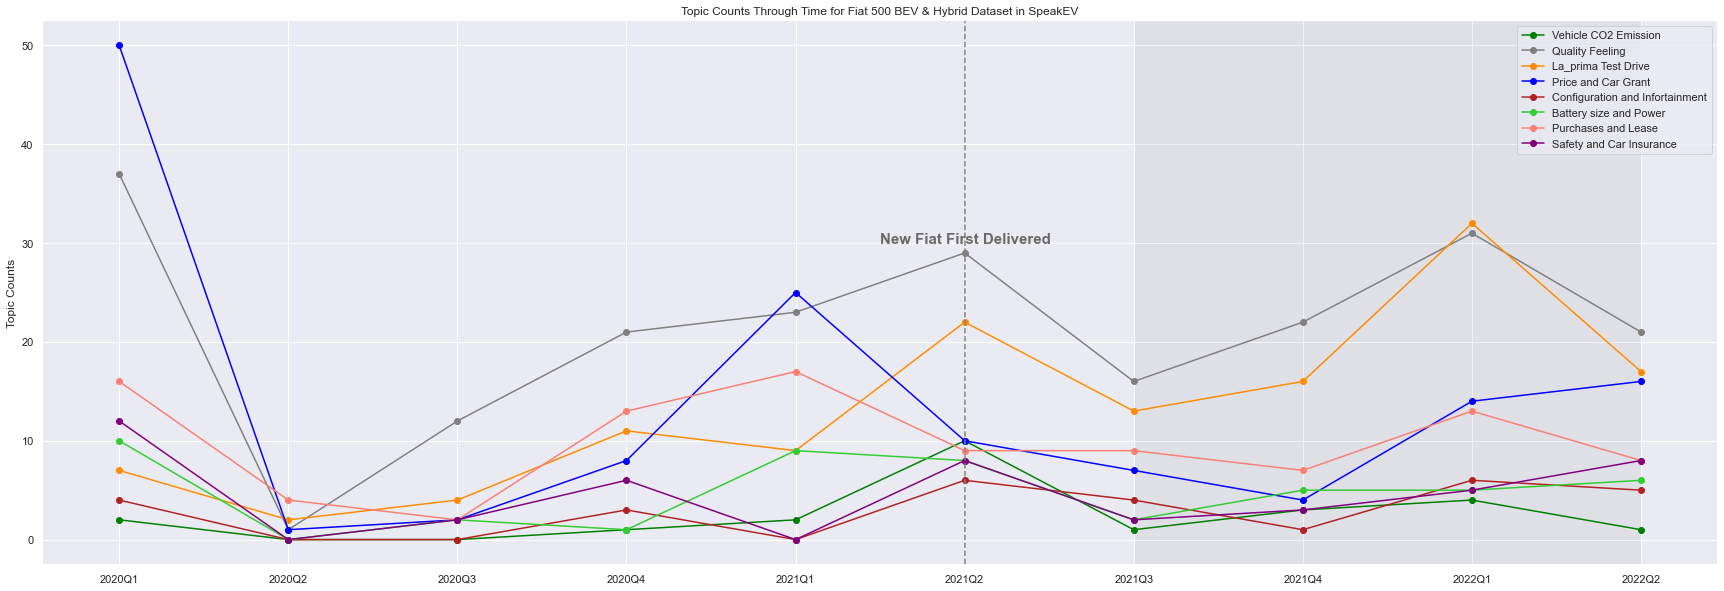

In [272]:
# sns.set_style("whitegrid")
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 1, 1)
colors = ["lightblue","green","grey","darkorange","blue","firebrick","limegreen",'salmon','purple','lightcoral']
topic_labels = ['Charge Speed and Mile Range', 'Vehicle CO2 Emission', 'Quality Feeling' ,'La_prima Test Drive',
'Price and Car Grant','Configuration and Infortainment','Battery size and Power',
'Purchases and Lease','Safety and Car Insurance']

t = np.arange(0,10,1)

for i in range(1, 9):
    ax.plot(t, topics_trend[topic_labels[i]], marker = 'o', label = topic_labels[i], c= colors[i])

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False) 

ax.axvline(5,linestyle = '--',color='grey')
# 3rd Peak  # new fiat first deliveries are expected to arrive in March 2021.
ax.annotate("New Fiat First Delivered", xy=(4.5, 30), xytext=(4.5,30), weight='bold',
        size = 15 , color="dimgray")
ax.legend()

ax.axvspan(6,9,facecolor = 'grey',alpha=0.1)

# Labelling 
ax.set_xticks(range(0,10,1))
# ax.set_xticklabels([topics_trend['month_year'].dt.strftime('%m/%Y')[i] for i in range(0,10,1)])
ax.set_xticklabels([topics_trend['month_year'][j] for j in range(0,10,1)])

plt.ylabel("Topic Counts")
plt.title('Topic Counts Through Time for Fiat 500 BEV & Hybrid Dataset in SpeakEV')
plt.legend()


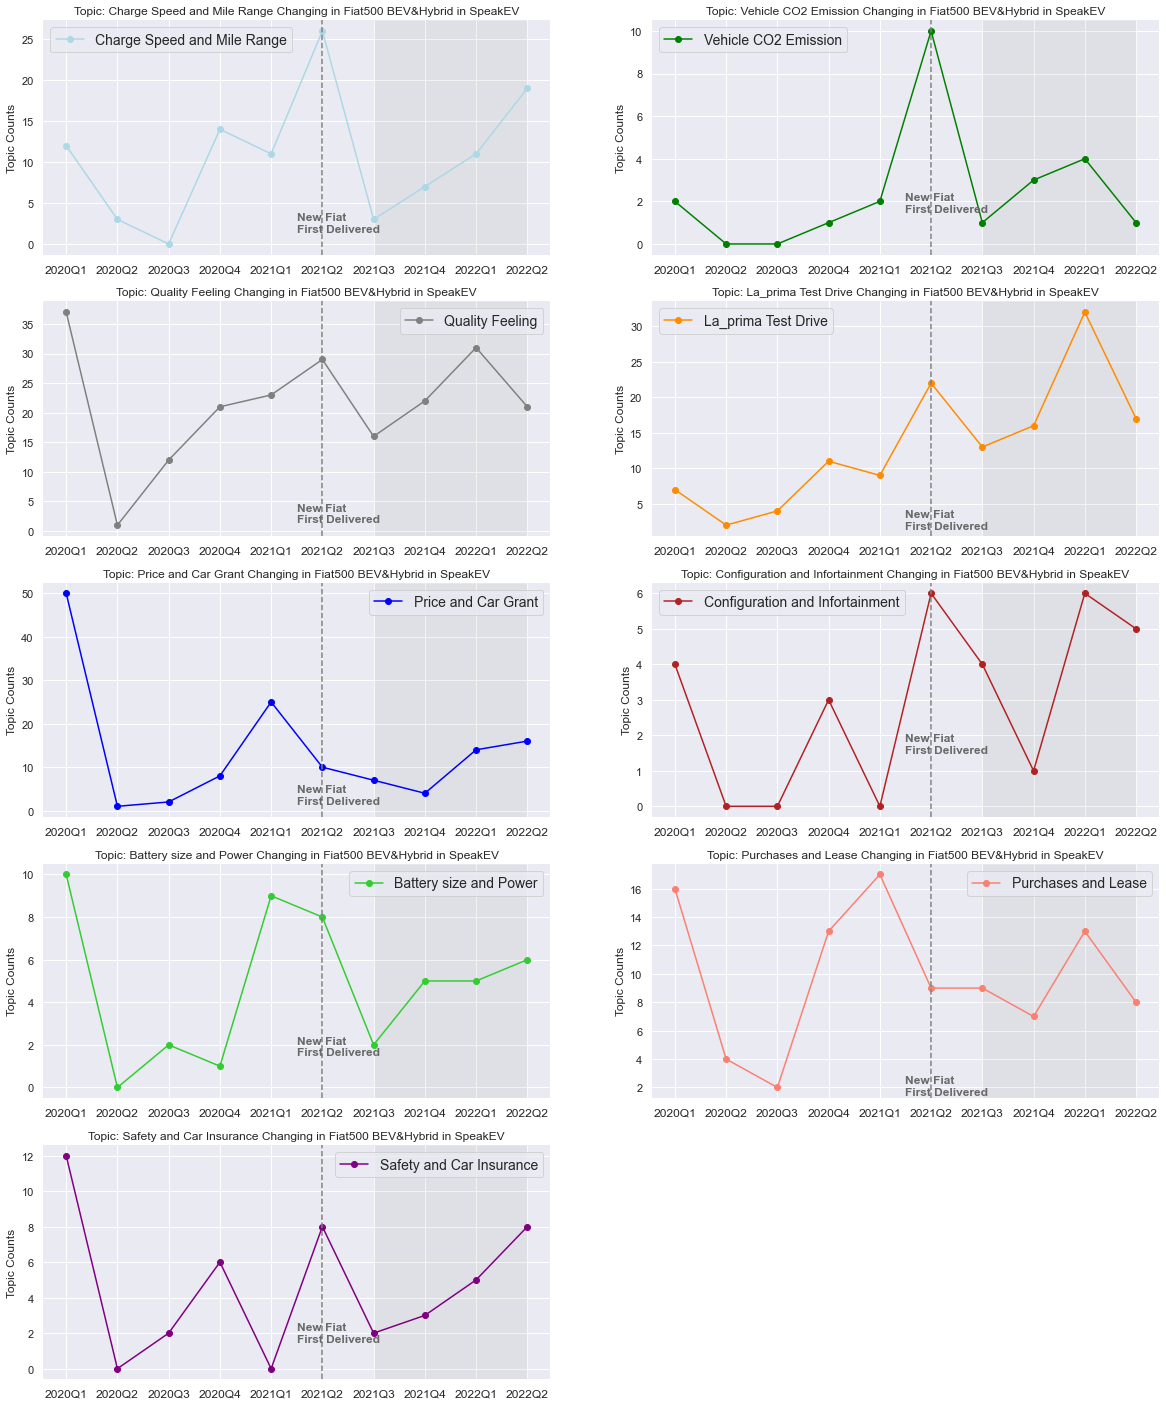

In [273]:
# sns.set_style("whitegrid")
fig = plt.figure(figsize=(20,25))
colors = ["lightblue","green","grey","darkorange","blue","firebrick","limegreen",'salmon','purple','lightcoral']
topic_labels = ['Charge Speed and Mile Range', 'Vehicle CO2 Emission', 'Quality Feeling' ,'La_prima Test Drive',
'Price and Car Grant','Configuration and Infortainment','Battery size and Power',
'Purchases and Lease','Safety and Car Insurance']

t = np.arange(0,10,1)

for i in range(1, 10):
    ax = fig.add_subplot(5,2,i)
    ax.plot(t, topics_trend[topic_labels[i-1]], marker = 'o', label = topic_labels[i-1], c= colors[i-1])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False) 
    ax.set_ylabel("Topic Counts",size = 12)

    ax.axvline(5,linestyle = '--',color='grey')
    # 3rd Peak  # new fiat first deliveries are expected to arrive in March 2021.
    ax.annotate("New Fiat \nFirst Delivered", xy=(4.5, 1.5), xytext=(4.5,1.5), weight='bold',
            size = 12 , color="dimgray")
    ax.legend(fontsize = 14)

    ax.axvspan(6,9,facecolor = 'grey',alpha=0.1)

    # Labelling 
    ax.set_xticks(range(0,10,1))
    # ax.set_xticklabels([topics_trend['month_year'].dt.strftime('%m/%Y')[j] for j in range(0,11,1)])
    ax.set_xticklabels([topics_trend['month_year'][j] for j in range(0,10,1)],size = 12)

    # Title
    ax.set_title('Topic: {} Changing in Fiat500 BEV&Hybrid in SpeakEV'.format(topic_labels[i-1]),size = 12)

Main Takeaways From Topic Counts Changing By Quarter:
- Overall, Topic 'Price' has significnat drop in Q1-2020 and Q1-2021. Topic 'La_prima Test Drive' increased constantly. 
- Once New Fiat first delivered in Q2-2021, people dicussed most is about Topic 'Quality feeling' and Topic 'La_prima test drive'.
- Since Q3-2021, people in general continously discussed on Topics 'Charge Speed and Mile Range', 'Battery Size and Power' and 'Safety and Car Insurance'

## Sentiment Analysis

In [274]:
# Create the corpus for sentiment analysis
corpus_sentiment_combined = [cleaning_text_sentiment_speakEV(comment) for comment in speakEV_fiat500_combined['Clean_Corpus']]
speakEV_fiat500_combined.loc[:,'Sentiment_corpus'] =  corpus_sentiment_combined

In [275]:
speakEV_fiat500_combined = sentiment(speakEV_fiat500_combined, 'Comment')

100%|██████████| 951/951 [00:00<00:00, 1509758.93it/s]


In [276]:
speakEV_fiat500_combined = speakEV_fiat500_combined.drop(drop_index_combined)
speakEV_fiat500_combined = speakEV_fiat500_combined.reset_index(drop=True)
speakEV_fiat500_combined.shape

(946, 18)

## Combined Sentiemnt and Topic Modelling Result about Fiat 500 BEV and Fiat 500 Hybrid

In [277]:
topic_larger_combined['Comment'] = speakEV_fiat500_combined['Comment']
topic_larger_combined['Thread_Title'] = speakEV_fiat500_combined['Thread_Title']

In [278]:
competitor_list = ['mini','vauxhall','renault','peugeote','honda','volkswagen','bmw','mercedes','volvo','tesla','nissan','hyundai']
model_list = [['mini','minielectric'],['vauxhall','corsa-e','corsa','e-corsa'],['renault','zoe'],['peugeote','peugeote-208','e208','e-208'],
                    ['honda','honda-e','honda e'],['vw','volkswagen'],['bmw','i3'],['mercedes'],['volvo'],['tesla'],['nissan','leaf','nissan leafs'],['hyundai','ioniq']]
for i in range(len(competitor_list)):
    extract_model_speakEV(topic_larger_combined,'Comment','Thread_Title',model = competitor_list[i], model_list = model_list[i])

In [279]:
for col in competitor_list:
    print("Number of comments related to {}: {}".format(col, sum(topic_larger_combined[col])))

Number of comments related to mini: 56
Number of comments related to vauxhall: 23
Number of comments related to renault: 66
Number of comments related to peugeote: 14
Number of comments related to honda: 25
Number of comments related to volkswagen: 40
Number of comments related to bmw: 42
Number of comments related to mercedes: 10
Number of comments related to volvo: 2
Number of comments related to tesla: 77
Number of comments related to nissan: 79
Number of comments related to hyundai: 40


In [280]:
topic_larger_combined['Fiat500e'] = speakEV_fiat500_combined['Fiat500e']
topic_larger_combined['Fiat500hybrid'] = speakEV_fiat500_combined['Fiat500hybrid']
topic_larger_combined['compound'] = speakEV_fiat500_combined['compound']
topic_larger_combined['sentiment'] = speakEV_fiat500_combined['sentiment']
topic_larger_combined['Discussion Date'] =  speakEV_fiat500_combined['Discussion Date']
topic_larger_combined['UserID'] = speakEV_fiat500_combined['UserID']
topic_larger_combined['Username'] = speakEV_fiat500_combined['Username']
topic_larger_combined['Num of posts per user'] = speakEV_fiat500_combined['Num of posts per user']
topic_larger_combined['Link of user profile'] = speakEV_fiat500_combined['Link of user profile']

In [281]:
# Inspect in the number of comments that mentions the following models and brands
print('''
Number of comments per car model:
Fiat 500 hybrid: {}
Fiat 500e: {}
'''.format(sum(topic_larger_combined['Fiat500hybrid']),sum(topic_larger_combined['Fiat500e'])))


Number of comments per car model:
Fiat 500 hybrid: 707.0
Fiat 500e: 764.0



In [282]:
# seperate the subset Fiat500e & Fiat 500hybrid
topic_senti_fiat500e_df = topic_larger_combined.loc[(topic_larger_combined['Fiat500e']  == 1) & (topic_larger_combined['Fiat500hybrid']  != 1) &(topic_larger_combined['mini']  != 1) &
                                                    (topic_larger_combined['vauxhall']  != 1) & (topic_larger_combined['renault']  != 1) & (topic_larger_combined['peugeote']  != 1) &
                                                    (topic_larger_combined['honda']  != 1) & (topic_larger_combined['volkswagen']  != 1) & (topic_larger_combined['bmw']  != 1) &
                                                    (topic_larger_combined['mercedes']  != 1) & (topic_larger_combined['volvo']  != 1) & (topic_larger_combined['tesla']  != 1) &
                                                    (topic_larger_combined['nissan']  != 1) & (topic_larger_combined['hyundai']  != 1)]
topic_senti_fiat500e_df = topic_senti_fiat500e_df.reset_index(drop = True)
print('Number of comments only mentioned Fiat 500e: {}'.format(topic_senti_fiat500e_df.shape[0]))

topic_senti_fiat500hybrid_df =  topic_larger_combined.loc[(topic_larger_combined['Fiat500e']  != 1) & (topic_larger_combined['Fiat500hybrid']  == 1) &(topic_larger_combined['mini']  != 1) &
                                                    (topic_larger_combined['vauxhall']  != 1) & (topic_larger_combined['renault']  != 1) & (topic_larger_combined['peugeote']  != 1) &
                                                    (topic_larger_combined['honda']  != 1) & (topic_larger_combined['volkswagen']  != 1) & (topic_larger_combined['bmw']  != 1) &
                                                    (topic_larger_combined['mercedes']  != 1) & (topic_larger_combined['volvo']  != 1) & (topic_larger_combined['tesla']  != 1) &
                                                    (topic_larger_combined['nissan']  != 1) & (topic_larger_combined['hyundai']  != 1)]
topic_senti_fiat500hybrid_df = topic_senti_fiat500hybrid_df.reset_index(drop = True)
print('Number of comments only mentioned Fiat 500 hybrid: {}'.format(topic_senti_fiat500hybrid_df.shape[0]))

Number of comments only mentioned Fiat 500e: 205
Number of comments only mentioned Fiat 500 hybrid: 104


In [283]:
topics_prob_combined = topic_larger_combined[list(topic_larger_combined.columns.values)[:-21]].mean()
print('the mean probabilities for topics of combined subset is:\n{}'.format(topics_prob_combined))
print('------------------------------------')
print('------------------------------------')

topics_prob_fiat500e = topic_senti_fiat500e_df[list(topic_senti_fiat500e_df.columns.values)[:-21]].mean()
print('the mean probabilities for topics of fiat500e subset is:\n{}'.format(topics_prob_fiat500e))
print('------------------------------------')
print('------------------------------------')

topics_prob_fiat500hybrid = topic_senti_fiat500hybrid_df[list(topic_senti_fiat500hybrid_df.columns.values)[:-21]].mean()
print('the mean probabilities for topics of fiat500hybrid subset is:\n{}'.format(topics_prob_fiat500hybrid))

the mean probabilities for topics of combined subset is:
Topic 1    0.137791
Topic 2    0.029293
Topic 3    0.251285
Topic 4    0.142085
Topic 5    0.145156
Topic 6    0.044505
Topic 7    0.088275
Topic 8    0.111429
Topic 9    0.050182
dtype: float64
------------------------------------
------------------------------------
the mean probabilities for topics of fiat500e subset is:
Topic 1    0.108740
Topic 2    0.015184
Topic 3    0.287222
Topic 4    0.153047
Topic 5    0.171691
Topic 6    0.031603
Topic 7    0.115940
Topic 8    0.069748
Topic 9    0.046825
dtype: float64
------------------------------------
------------------------------------
the mean probabilities for topics of fiat500hybrid subset is:
Topic 1    0.178614
Topic 2    0.074964
Topic 3    0.229688
Topic 4    0.053771
Topic 5    0.160682
Topic 6    0.051140
Topic 7    0.052480
Topic 8    0.175326
Topic 9    0.023336
dtype: float64


In [284]:
from numpy import average
def weighted_avg(df,topics):
    weighted_avg_sentiment=[]
    for i in topic_senti_fiat500e_df.columns.values[0:k+1]:
        weighted_avg_topic= round(average(df['compound'], weights = df[i]),2)
        weighted_avg_sentiment.append(weighted_avg_topic)
    return weighted_avg_sentiment

In [285]:
weighted_avg_senti_combined = weighted_avg(df = topic_larger_combined,topics=k)
print('The weighted average compound for topics of combined subset is:\n {}'.format(weighted_avg_senti_combined))
print('------------------------------------')
print('------------------------------------')

weighted_avg_senti_fiat500e = weighted_avg(df = topic_senti_fiat500e_df,topics=k)
print('The weighted average compound for topics of Fiat500e is:{}'.format(weighted_avg_senti_fiat500e))
print('------------------------------------')
print('------------------------------------')

weighted_avg_senti_fiat500hybrid = weighted_avg(df = topic_senti_fiat500hybrid_df,topics=k)
print('The weighted average compound for topics of Fiat500hybrid is:{}'.format(weighted_avg_senti_fiat500hybrid))

The weighted average compound for topics of combined subset is:
 [0.32, 0.38, 0.35, 0.31, 0.35, 0.31, 0.45, 0.42, 0.35]
------------------------------------
------------------------------------
The weighted average compound for topics of Fiat500e is:[0.25, 0.59, 0.2, 0.19, 0.27, 0.11, 0.29, 0.28, 0.03]
------------------------------------
------------------------------------
The weighted average compound for topics of Fiat500hybrid is:[0.29, 0.31, 0.32, 0.41, 0.38, 0.36, 0.29, 0.4, 0.3]



    Data information
    --------------------------------------
    Total number of comments: 946
    Average lenght of each reply: 532.21 characters
    Average words per comment: 95.8 words
    
    Number of positive comments (compound >0.05) is 651 (68.8%)
    Number of negative comments (compound <-0.05) is 177 (18.7%)
    Number of neutral comments (compound is between -0.05 and 0.05) is 118 (12.5%)
    
    Number of super positive comments (compound > 0.5) is 439 (46.4%)
    Number of super negative comments (compound < -0.5) is 68 (7.2%)
    --------------------------------------
    


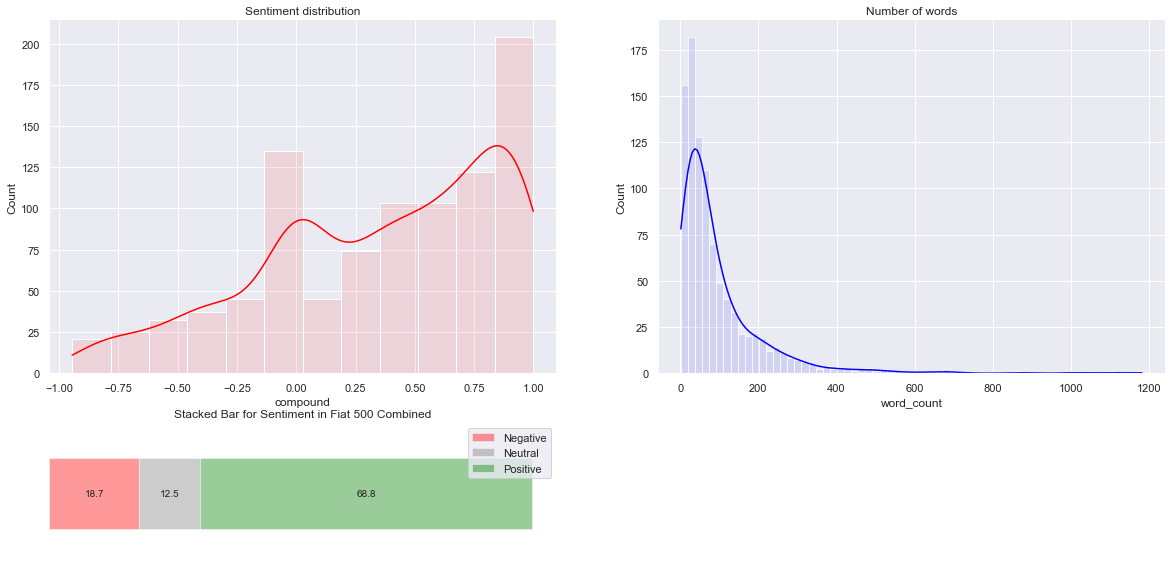

In [286]:
# Sentiment Distribution on Fiat 500 Combined Dataset
sentiment_explor_speakEV(topic_larger_combined,'Comment','Fiat 500 Combined')


    Data information
    --------------------------------------
    Total number of comments: 205
    Average lenght of each reply: 215.31 characters
    Average words per comment: 38.9 words
    
    Number of positive comments (compound >0.05) is 113 (55.1%)
    Number of negative comments (compound <-0.05) is 41 (20.0%)
    Number of neutral comments (compound is between -0.05 and 0.05) is 51 (24.9%)
    
    Number of super positive comments (compound > 0.5) is 60 (29.3%)
    Number of super negative comments (compound < -0.5) is 9 (4.4%)
    --------------------------------------
    


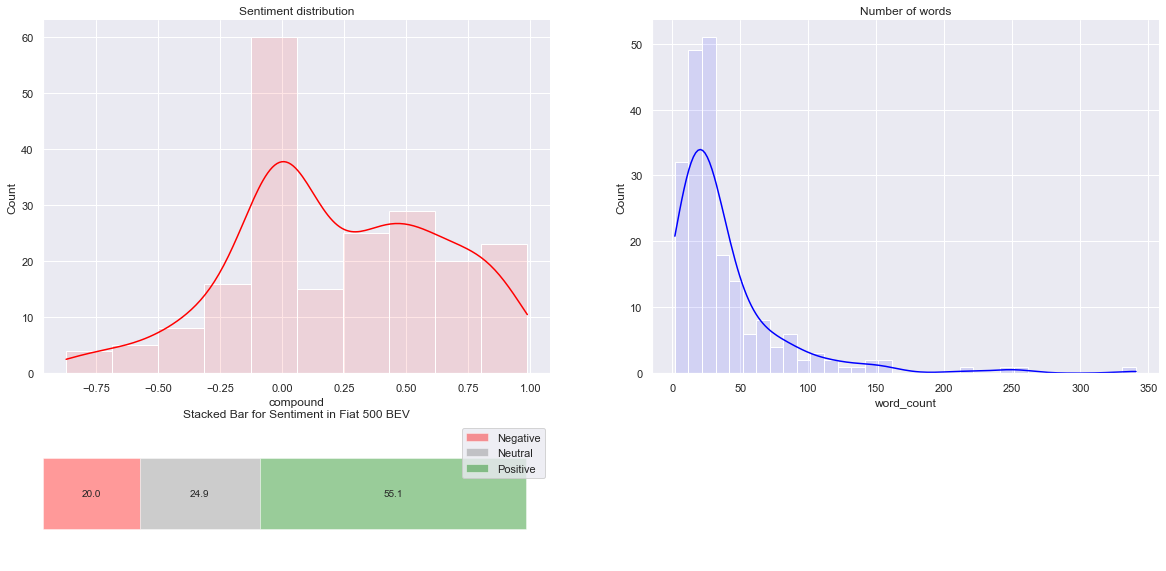

In [287]:
# Sentiment Distribution on Fiat 500 BEV Dataset
sentiment_explor_speakEV(topic_senti_fiat500e_df,'Comment','Fiat 500 BEV')


    Data information
    --------------------------------------
    Total number of comments: 104
    Average lenght of each reply: 487.44 characters
    Average words per comment: 88.9 words
    
    Number of positive comments (compound >0.05) is 75 (72.1%)
    Number of negative comments (compound <-0.05) is 22 (21.2%)
    Number of neutral comments (compound is between -0.05 and 0.05) is 7 (6.7%)
    
    Number of super positive comments (compound > 0.5) is 53 (51.0%)
    Number of super negative comments (compound < -0.5) is 11 (10.6%)
    --------------------------------------
    


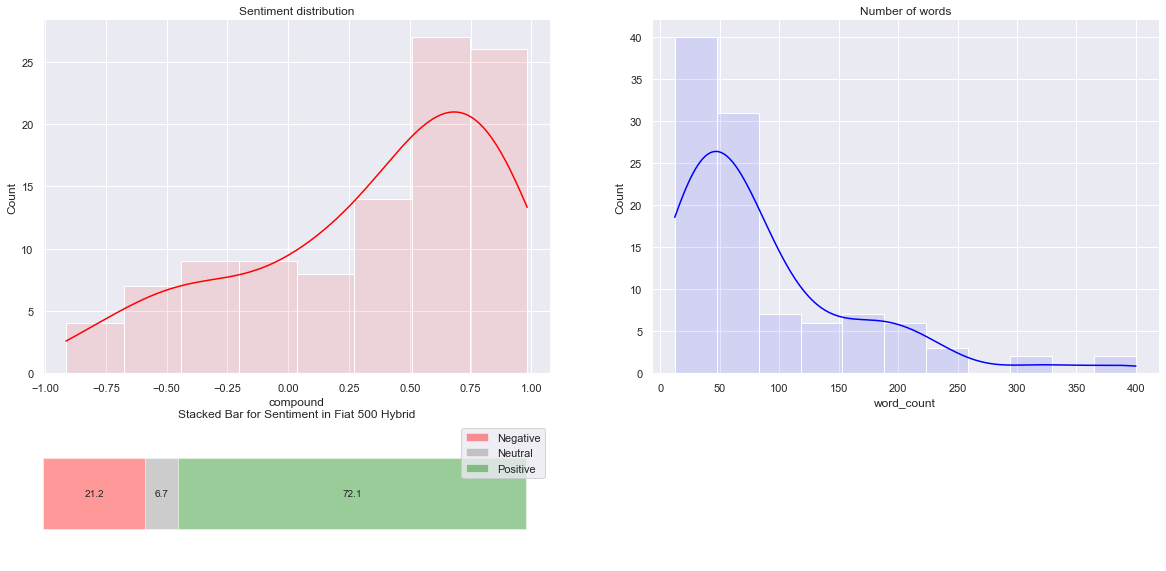

In [288]:
# Sentiment Distribution on Fiat 500 Hybrid Dataset
sentiment_explor_speakEV(topic_senti_fiat500hybrid_df,'Comment','Fiat 500 Hybrid')

Main Takeaways:
- Overall, Fiat 500 BEV has a lower postiive percentage than Fiat 500 Hybrid.
- People are more likely to have neural attitude towards Fiat 500 BEV than Fiat 500 Hybrid, with 24.9% and 6.7% respectively. -> It is because that most of people have experienced Fiat 500 hybrid since it launched in 2020-Q1. As for Fiat 500 BEV,   people do not have enough experiences since Fiat 500 BEV just launched in Q2-2021, also indicates that people are still confused about the new technology innovation. 

- People has obviously attitude towards Fiat 500 Hybrid, with 51.0% super postiive and 10.6% super negative attitudes, whereas Fiat 500 BEV 29.3% of super positive and 4.4% of super negative attitudes. 


- Go Deeper:
    - The number of super positive comments in Fiat 500 hybrid is 96. Mainly consists of Topic 1,3,8 (with 19%, 18% and 19%) of super positive comments. 



In [289]:
# Find the sentiment for each topic
def sentiment_topic(topic_senti_df, topic_larger_df):
    for topic in topic_senti_df.index:
        temp = topic_larger_df[topic_larger_df['Main_topic1']== topic]['sentiment'].value_counts()
        if topic == topic_senti_df.index[0]:
            sentiments_wholeev = temp
        else:
            sentiments_wholeev = pd.concat([sentiments_wholeev, temp], axis=1)

    sentiments_wholeev = sentiments_wholeev.T.set_index(topic_senti_df.index)
    topic_senti_wholeev = pd.concat([topic_senti_df, sentiments_wholeev], axis=1)

    topic_senti_wholeev = topic_senti_wholeev.replace(np.nan,0) #
    
    return topic_senti_wholeev

In [290]:
topic_larger_combined[topic_larger_combined['Main_topic1'] == 'Topic 1']['sentiment'].value_counts()

pos    91
neg    31
neu    15
Name: sentiment, dtype: int64

In [291]:
# show the dataframe combine the result
topic_senti_combined = pd.DataFrame()

topic_senti_combined['Prob_combined'] =  topics_prob_combined
topic_senti_combined['WeightedSenti_EV'] = weighted_avg_senti_combined

topic_senti_combined = sentiment_topic(topic_senti_combined,topic_larger_combined)
topic_senti_combined['combined_pos_percentage'] = (topic_senti_combined.iloc[:,2]/(topic_senti_combined.iloc[:, 2:5].sum(axis=1))).round(2)

topic_senti_combined['Prob_500e'] =  topics_prob_fiat500e
topic_senti_combined['WeightedSenti_500e'] = weighted_avg_senti_fiat500e
topic_senti_combined = sentiment_topic(topic_senti_combined,topic_senti_fiat500e_df)
topic_senti_combined['500e_pos_percentage'] = (topic_senti_combined.iloc[:,8]/(topic_senti_combined.iloc[:, 8:11].sum(axis=1))).round(2)

topic_senti_combined['Prob_500hybrid'] =  topics_prob_fiat500hybrid
topic_senti_combined['WeightedSenti_500hybrid'] = weighted_avg_senti_fiat500hybrid
topic_senti_combined = sentiment_topic(topic_senti_combined,topic_senti_fiat500hybrid_df)
topic_senti_combined['500hybrid_pos_percentage'] = (topic_senti_combined.iloc[:,14]/(topic_senti_combined.iloc[:, 14:17].sum(axis=1))).round(2)
topic_senti_combined

,Prob_combined,WeightedSenti_EV,pos,neg,neu,combined_pos_percentage,Prob_500e,WeightedSenti_500e,pos,neu,neg,500e_pos_percentage,Prob_500hybrid,WeightedSenti_500hybrid,pos,neg,neu,500hybrid_pos_percentage
Topic 1,0.137791,0.32,91,31,15,0.66,0.108740,0.25,15.0,6.0,5.0,0.58,0.178614,0.29,12.0,3.0,2.0,0.71
Topic 2,0.029293,0.38,17,7,2,0.65,0.015184,0.59,1.0,0.0,0.0,1.00,0.074964,0.31,5.0,3.0,0.0,0.62
Topic 3,0.251285,0.35,150,42,37,0.66,0.287222,0.20,29.0,17.0,15.0,0.48,0.229688,0.32,14.0,6.0,2.0,0.64
Topic 4,0.142085,0.31,85,23,31,0.61,0.153047,0.19,14.0,15.0,3.0,0.44,0.053771,0.41,5.0,1.0,0.0,0.83
Topic 5,0.145156,0.35,106,25,13,0.74,0.171691,0.27,24.0,6.0,5.0,0.69,0.160682,0.38,13.0,2.0,1.0,0.81
Topic 6,0.044505,0.31,22,6,4,0.69,0.031603,0.11,3.0,0.0,1.0,0.75,0.051140,0.36,3.0,0.0,1.0,0.75
Topic 7,0.088275,0.45,67,16,6,0.75,0.115940,0.29,17.0,3.0,6.0,0.65,0.052480,0.29,5.0,2.0,0.0,0.71
Topic 8,0.111429,0.42,78,18,7,0.76,0.069748,0.28,6.0,2.0,2.0,0.60,0.175326,0.40,15.0,5.0,1.0,0.71
Topic 9,0.050182,0.35,35,9,3,0.74,0.046825,0.03,4.0,2.0,4.0,0.40,0.023336,0.30,3.0,0.0,0.0,1.00


In [292]:
# # Visualising the results per sentiment

# from turtle import color


# topic_labels = ['Charge Speed and Mile Range', 'Vehicle CO2 Emission', 'Quality Feeling' ,'La_prima Test Drive',
#           'Price and Car Grant','Configuration and Infortainment','Battery size and Power',
#           'Purchases and Lease','Safety and Car Insurance']

# x = np.arange(topic_senti_combined.shape[0])  # the label locations
# width = 0.30  # the width of the bar

# fig = plt.figure(figsize=(25,10))

# ax1 = fig.add_subplot(1,2,1)
# ax2 = fig.add_subplot(1,2,2)

# ## Add the plot for BEV
# rects1 = ax1.bar(x - width/3,topic_senti_combined.iloc[:, 8], width, label='Pos',color = 'limegreen',alpha= 0.7)
# rects2 = ax1.bar(x + width/3+0.1, topic_senti_combined.iloc[:, 9], width, label='Neg',color = 'coral',alpha= 0.7)
# rects3 = ax1.bar(x + width/3+0.4, topic_senti_combined.iloc[:, 10], width, label='Neu', color = 'grey',alpha= 0.7)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax1.set_ylabel('Comment Counts')
# ax1.set_title('Comments and Sentiment Counts for Each Topic in Fiat 500 BEV')
# ax1.set_xticks(x, topic_labels)
# ax1.legend()

# ax1.bar_label(rects1, padding=3)
# ax1.bar_label(rects2, padding=3)
# ax1.bar_label(rects3, padding=3)
    
# ax1.spines['right'].set_visible(False)
# ax1.spines['top'].set_visible(False)


# ## Add the plot for hybrid
# rects1e = ax2.bar(x - width/3, topic_senti_combined.iloc[:, -4], width, label='Pos',color = 'limegreen',alpha= 0.7)
# rects2e = ax2.bar(x + width/3+0.1, topic_senti_combined.iloc[:, -3], width, label='Neg', color = 'coral',alpha= 0.7)
# rects3e = ax2.bar(x + width/3+0.4, topic_senti_combined.iloc[:, -2], width, label='Neu',color = 'grey',alpha= 0.7)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax2.set_ylabel('Comment Counts')
# ax2.set_title('Comments and Sentiment Counts for Each Topic in Fiat 500 Hybrid')
# ax2.set_ylim(0,30)
# ax2.set_xticks(x, topic_labels)
# ax2.legend()

# ax2.bar_label(rects1e, padding=3)
# ax2.bar_label(rects2e, padding=3)
# ax2.bar_label(rects3e, padding=3)

# ax2.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)

# plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
# plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
         
# fig.tight_layout()

# plt.show()

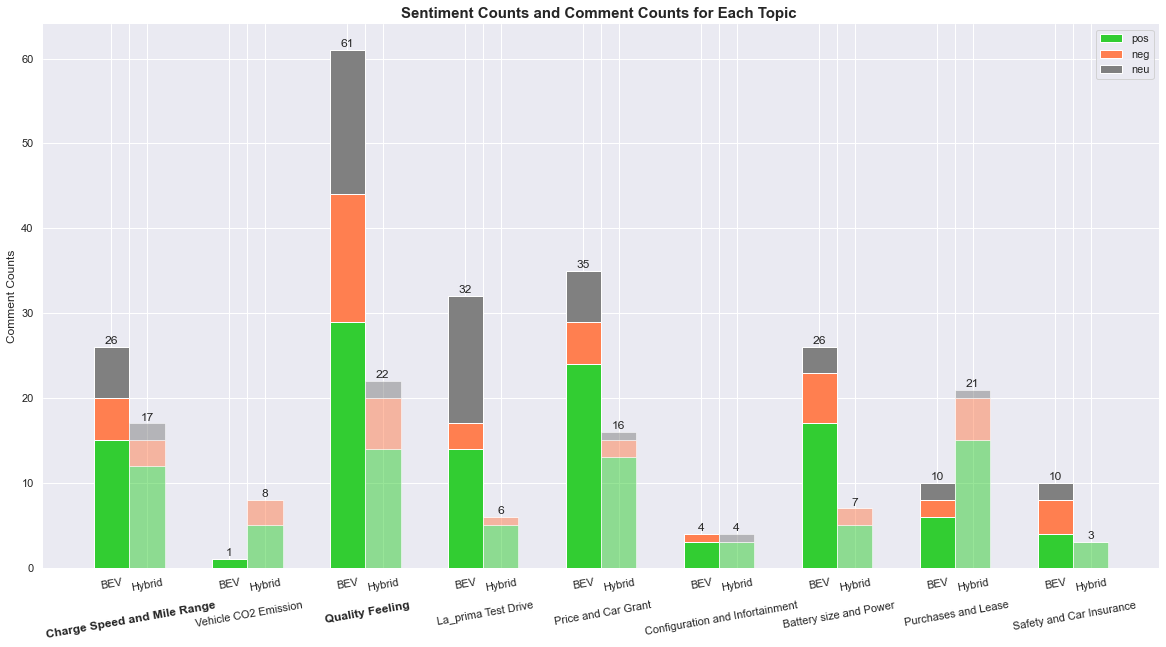

In [293]:
# def topics_sentiment_stack(df, column_name1, column_name2):

import xxlimited

topic_labels = ['Charge Speed and Mile Range', 'Vehicle CO2 Emission', 'Quality Feeling' ,'La_prima Test Drive',
        'Price and Car Grant','Configuration and Infortainment','Battery size and Power',
        'Purchases and Lease','Safety and Car Insurance']
sentiment_labels = ['pos','neg','neu']
colors = ["limegreen","coral","grey"]
width =0.30

# x_pos = np.arange(0,18)
# x = np.arange(topic_senti_combined.shape[0])  # the label location

x = list()
ind = np.arange(9)
# x labels position: i = 1st bar, i+w/2 = category, i+w = 2nd bar
for i in ind:
    x.extend([i, i+width/2., i+width])  

# sns.set_style("whitegrid")
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)

temp_combined = topic_senti_combined.iloc[:,2:5]
temp_bev= topic_senti_combined.iloc[:,8:11]
temp_hybrid = topic_senti_combined.iloc[:,14:17]

#bev
ax.bar(ind, temp_bev[sentiment_labels[0]], width,  label = sentiment_labels[0], color = colors[0],alpha = 1)
ax.bar(ind, temp_bev[sentiment_labels[1]], width,   label = sentiment_labels[1], color = colors[1],bottom= temp_bev[sentiment_labels[0]] ,alpha = 1)
ax.bar(ind, temp_bev[sentiment_labels[2]], width,   label = sentiment_labels[2], color = colors[2],bottom= temp_bev[sentiment_labels[0]] + temp_bev[sentiment_labels[1]],alpha =1 )

bev_count = topic_senti_combined.iloc[:, 8:11].sum(axis=1)
hybrid_count =  topic_senti_combined.iloc[:, 14:17].sum(axis=1)

for a, b in zip(ind, bev_count):   
    plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=12)
for a, b in zip(ind+width, hybrid_count):   
    plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=12)

#hybrid
ax.bar(ind+width, temp_hybrid[sentiment_labels[0]], width,  color = colors[0],alpha = 0.5)
ax.bar(ind+width, temp_hybrid[sentiment_labels[1]], width,  color = colors[1],bottom=  temp_hybrid[sentiment_labels[0]] , alpha = 0.5)
ax.bar(ind+width, temp_hybrid[sentiment_labels[2]], width,  color = colors[2],bottom=  temp_hybrid[sentiment_labels[0]] + temp_hybrid[sentiment_labels[1]], alpha = 0.5)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False) 


# Labelling 
# plt.xlabel("Discussion Date")
plt.ylabel("Comment Counts")
plt.xticks(x)

ax.set_xticklabels(('BEV','\n\nCharge Speed and Mile Range', 'Hybrid', 'BEV','\n\nVehicle CO2 Emission', 'Hybrid',
                    'BEV','\n\nQuality Feeling', 'Hybrid','BEV','\n\nLa_prima Test Drive', 'Hybrid',
                    'BEV','\n\nPrice and Car Grant', 'Hybrid','BEV','\n\nConfiguration and Infortainment', 'Hybrid',
                    'BEV','\n\nBattery size and Power', 'Hybrid','BEV','\n\nPurchases and Lease', 'Hybrid',
                    'BEV','\n\nSafety and Car Insurance', 'Hybrid'),ha='center',rotation = 10)

ax.set_title('Sentiment Counts and Comment Counts for Each Topic ',fontdict={'size': 15, 'weight': 700})

x_label = ax.get_xticklabels() 
# temp_labels = [x_label[1],x_label[7],x_label[10],x_label[13],x_label[19]]
temp_labels = [x_label[1],x_label[7]]
for label in temp_labels:
    label.set_fontweight('bold') 
    label.set_fontsize(12)

plt.legend()


Main Takeaways:
- Overall, topic 'Qualtiy Feeling' has more discussion in general within Fiat 500 BEV and Hybrid. 
- People are more likely to discuss topics regarding 'La_prima Test Drive' in Fiat 500 BEV while 'Purchases and Lease' in Fiat 500 Hybrid.



Text(0.5, 1.0, 'Comment Sentiment Percentage for Each Topic')

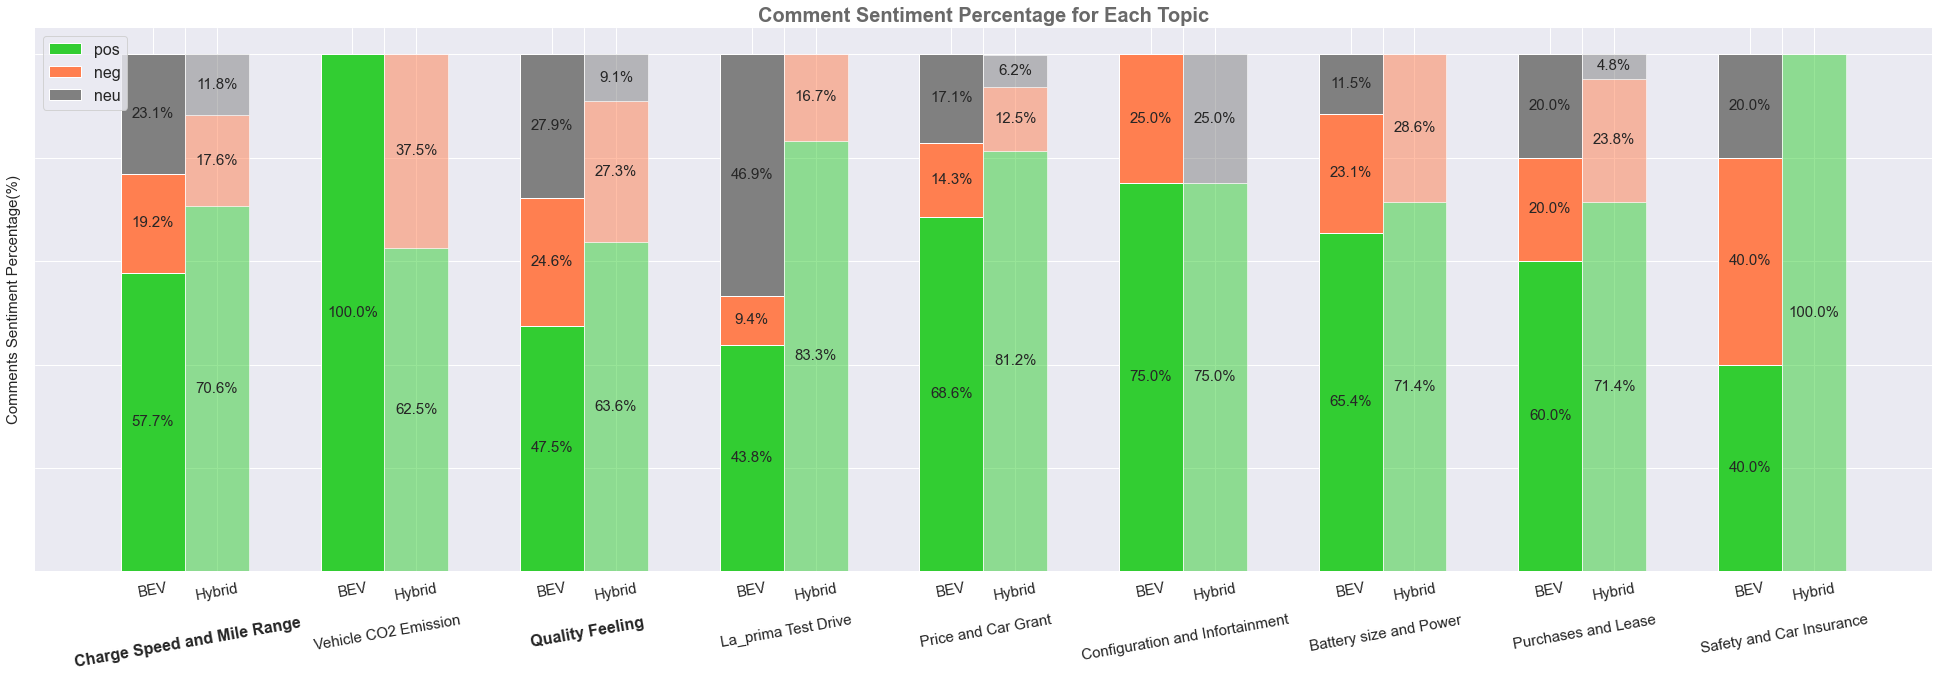

In [294]:
# def topics_sentiment_stack(df, column_name1, column_name2):

import xxlimited

topic_labels = ['Charge Speed and Mile Range', 'Vehicle CO2 Emission', 'Quality Feeling' ,'La_prima Test Drive',
        'Price and Car Grant','Configuration and Infortainment','Battery size and Power',
        'Purchases and Lease','Safety and Car Insurance']

sentiment_labels = ['pos','neg','neu']
colors = ["limegreen","coral","grey"]
width =0.32

# x_pos = np.arange(0,18)
# x = np.arange(topic_senti_combined.shape[0])  # the label location

x = list()
ind = np.arange(9)
# x labels position: i = 1st bar, i+w/2 = category, i+w = 2nd bar
for i in ind:
    x.extend([i, i+width/2., i+width])  

# sns.set_style("whitegrid")
fig = plt.figure(figsize=(34, 10))
ax = fig.add_subplot(1, 1, 1)

temp_bev= topic_senti_combined.iloc[:,8:11]
temp_hybrid = topic_senti_combined.iloc[:,14:17]

temp_bev['sum'] = temp_bev['pos']+temp_bev['neu']+temp_bev['neg']
temp_hybrid['sum'] = temp_hybrid['pos']+temp_hybrid['neu']+temp_hybrid['neg']


temp_bev['pos_temp'] = round(temp_bev['pos']/temp_bev['sum']*100, 1)
temp_bev['neg_temp'] = round(temp_bev['neg']/temp_bev['sum']*100, 1)
temp_bev['neu_temp'] = round(temp_bev['neu']/temp_bev['sum']*100, 1)

temp_hybrid['pos_temp'] = round(temp_hybrid['pos']/temp_hybrid['sum']*100, 1)
temp_hybrid['neg_temp'] = round(temp_hybrid['neg']/temp_hybrid['sum']*100, 1)
temp_hybrid['neu_temp'] = round(temp_hybrid['neu']/temp_hybrid['sum']*100, 1)


#bev
ax.bar(ind, temp_bev['pos_temp'], width,  label = sentiment_labels[0], color = colors[0],alpha = 1)
ax.bar(ind, temp_bev['neg_temp'], width,   label = sentiment_labels[1], color = colors[1],bottom= temp_bev['pos_temp'] ,alpha = 1)
ax.bar(ind, temp_bev['neu_temp'], width,   label = sentiment_labels[2], color = colors[2],bottom= temp_bev['pos_temp'] + temp_bev['neg_temp'],alpha =1 )

ax.legend(fontsize = 16)

# hybrid
ax.bar(ind+width, temp_hybrid['pos_temp'], width,  label = sentiment_labels[0], color = colors[0],alpha = 0.5)
ax.bar(ind+width, temp_hybrid['neg_temp'], width,   label = sentiment_labels[1], color = colors[1],bottom= temp_hybrid['pos_temp'] ,alpha = 0.5)
ax.bar(ind+width, temp_hybrid['neu_temp'], width,   label = sentiment_labels[2], color = colors[2],bottom= temp_hybrid['pos_temp'] + temp_hybrid['neg_temp'],alpha = 0.5 )


# text
for a, b in zip(ind, temp_bev['pos_temp']):   
    plt.text(a, b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)
for a, b in zip(ind+width, temp_hybrid['pos_temp']):   
    plt.text(a, b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)

for a, b, c in zip(ind, temp_bev['neg_temp'], temp_bev['pos_temp']):   
    if b!= 0:
        plt.text(a, c+b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)
for a, b, c in zip(ind+width, temp_hybrid['neg_temp'], temp_hybrid['pos_temp']):   
    if b!=0:
        plt.text(a, c+b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)

for a, b, c  in zip(ind, temp_bev['neu_temp'], temp_bev['neg_temp']+temp_bev['pos_temp']):   
    if b!= 0:
        plt.text(a, c+b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)
for a, b, c in zip(ind+width,temp_hybrid['neu_temp'], temp_hybrid['neg_temp']+temp_hybrid['pos_temp']): 
    if b!= 0:  
        plt.text(a, c+b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False) 


# Labelling 
plt.ylabel("Comments Sentiment Percentage(%)", size = 15)
# Ticks
ax.axes.yaxis.set_ticklabels([])

plt.xticks(x)

ax.set_xticklabels(('BEV','\n\nCharge Speed and Mile Range', 'Hybrid', 
                    'BEV','\n\nVehicle CO2 Emission', 'Hybrid',
                    'BEV','\n\nQuality Feeling', 'Hybrid',
                    'BEV','\n\nLa_prima Test Drive', 'Hybrid',
                    'BEV','\n\nPrice and Car Grant', 'Hybrid',
                    'BEV','\n\nConfiguration and Infortainment', 'Hybrid',
                    'BEV','\n\nBattery size and Power', 'Hybrid',
                    'BEV','\n\nPurchases and Lease', 'Hybrid',
                    'BEV','\n\nSafety and Car Insurance', 'Hybrid'),ha='center',rotation = 10, size = 15) 

x_label = ax.get_xticklabels() 
temp_labels = [x_label[1],x_label[7]]  #,x_label[19],x_label[25]
for label in temp_labels:
    label.set_fontweight('bold') 
    label.set_fontsize(16)
# Title
ax.set_title('Comment Sentiment Percentage for Each Topic', color = 'dimgray', fontdict={'size': 20, 'weight': 700})


Main Takeaways:
- Overall, BEV has lower positive percentage than Hybrid except for topics 'Vehicle CO2 emission' and 'Configuration and Infortainment'.
- Less than over 10% of positive comments in top dicussion topics ('Qualtiy Feeling','Price and Car Grant' and 'Charge Speed and Mile Rnage')
- People have more neural attitude towards 'la_prima test drive' in Fiat 500 BEV discussion.
- People have more positive attitude towards 'Purchases and Lease' in Fiat 500 Hybrid.
- Need to notice that people have lower postive attitude towards Safety and Car Insurance in Fiat 500 BEV.

- Topic Selection Criteria


In [206]:
topic_larger_combined.to_csv('topic_larger_combined_update.csv')

## PMI - Q1

In [303]:
pmi_topic_combined = pd.concat([topic_larger_combined,speakEV_fiat500_combined[['Sentiment_corpus']]],axis=1)
pmi_topic_combined

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Main_topic1,...,Fiat500hybrid,compound,sentiment,Discussion Date,UserID,Username,Num of posts per user,Link of user profile,word_count,Sentiment_corpus
0,0.0,0.000000,0.468476,0.000000,0.000000,0.0,0.000000,0.531524,0.000000,Topic 8,...,0.0,0.4926,pos,"Mar 24, 2022",96270,Alnair,579,https://www.speakev.com/members/alnair.96270/,28,good point confirm look deal insurance new ele...
1,0.0,0.000000,0.578080,0.000000,0.000000,0.0,0.000000,0.421920,0.000000,Topic 3,...,0.0,0.4939,pos,"Mar 10, 2022",2505,cah197,"26,262",https://www.speakev.com/members/cah197.2505/,9,different pretty cheap material
2,0.0,0.580986,0.000000,0.419014,0.000000,0.0,0.000000,0.000000,0.000000,Topic 2,...,0.0,0.8122,pos,"Jan 18, 2022",2505,cah197,"26,262",https://www.speakev.com/members/cah197.2505/,57,look cool promise come cheap fiat panda aim...
3,0.0,0.000000,0.553302,0.000000,0.446698,0.0,0.000000,0.000000,0.000000,Topic 3,...,0.0,0.0000,neu,"Jan 18, 2022",2505,cah197,"26,262",https://www.speakev.com/members/cah197.2505/,10,money run gear
4,0.0,0.000000,0.625276,0.000000,0.000000,0.0,0.374724,0.000000,0.000000,Topic 3,...,0.0,0.0000,neu,"Jan 18, 2022",97879,CHERYLWARD,402,https://www.speakev.com/members/cherylward.97879/,31,ev ground old come fudge ev year old platform
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,0.0,0.000000,0.553665,0.000000,0.000000,0.0,0.000000,0.446335,0.000000,Topic 3,...,1.0,0.6808,pos,"Sep 10, 2021",98903,LaserTam,46,https://www.speakev.com/members/lasertam.98903/,72,thank yes offer deposit contribution finance p...
942,0.0,0.000000,0.524124,0.000000,0.000000,0.0,0.000000,0.475876,0.000000,Topic 3,...,1.0,0.4767,pos,"Sep 20, 2021",99112,marko68,15,https://www.speakev.com/members/marko68.99112/,99,hi laser tam join order fiat manage pound r...
943,0.0,0.000000,0.000000,0.437495,0.000000,0.0,0.000000,0.000000,0.562505,Topic 9,...,1.0,0.9052,pos,"Jul 31, 2022",98703,Mkultra,558,https://www.speakev.com/members/mkultra.98703/,132,new trading condition affect new ish product m...
944,0.0,0.000000,0.433254,0.566746,0.000000,0.0,0.000000,0.000000,0.000000,Topic 4,...,1.0,0.9181,pos,"Jul 31, 2022",98703,Mkultra,558,https://www.speakev.com/members/mkultra.98703/,100,sure article clear point good think receive ro...


In [304]:
# BEV
pmi_bev_df =pmi_topic_combined.loc[(pmi_topic_combined['Fiat500e'] == 1) & (pmi_topic_combined['Fiat500hybrid'] != 1)]
bev_neg_df = pmi_bev_df.loc[(pmi_bev_df['sentiment'] == 'neg')]
bev_neu_df = pmi_bev_df.loc[(pmi_bev_df['sentiment'] == 'neu')]
bev_pos_df = pmi_bev_df.loc[(pmi_bev_df['sentiment'] == 'pos')]

#Hybrid
pmi_hybrid_df =pmi_topic_combined.loc[(pmi_topic_combined['Fiat500e'] != 1) & (pmi_topic_combined['Fiat500hybrid'] == 1)]
hybrid_neg_df = pmi_hybrid_df.loc[(pmi_hybrid_df['sentiment'] == 'neg')]
hybrid_neu_df = pmi_hybrid_df.loc[(pmi_hybrid_df['sentiment'] == 'neu')]
hybrid_pos_df = pmi_hybrid_df.loc[(pmi_hybrid_df['sentiment'] == 'pos')]


## PMI - Focus on Topic Discussion (Topic 3 Quality Feeling )

### PMI Topic 3 Quality Feeling in Fiat 500 BEV

PMI Topic 3 Quality Feeling in Fiat 500 BEV - Negative

In [305]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_tp3_bev_neg(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(1)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(1)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [306]:
tp3_bev_neg_df = bev_neg_df.loc[(bev_neg_df['Main_topic1'] == 'Topic 3')] 
tp3_bev_neg_bigrams, tp3_bev_neg_trigrams = pmi_tp3_bev_neg(df = tp3_bev_neg_df, column_name='Sentiment_corpus')
print(tp3_bev_neg_bigrams)
print('----------')
print(tp3_bev_neg_trigrams)

Number of words in the corpus: 193
[('absolutely', 'idea'), ('allow', 'hike'), ('arrive', 'edit'), ('blame', 'load'), ('blue', 'good'), ('body', 'low'), ('boxy', 'body'), ('budget', 'slightly'), ('buyer', 'sell'), ('cancel', 'preorder'), ('celestial', 'blue'), ('cost', 'extra'), ('crap', 'think'), ('december', 'cost'), ('deliver', 'hear'), ('demand', 'pop'), ('demonstrator', 'march'), ('deposit', 'sure'), ('electric', 'tesla'), ('eu', 'allow'), ('face', 'emoji'), ('fiat', 'panda'), ('find', 'lct'), ('forum', 'know'), ('glib', 'wouldn'), ('good', 'marker'), ('government', 'increase'), ('hear', 'hope'), ('hike', 'solar'), ('hyundai', 'kia'), ('increase', 'tax'), ('insist', 'celestial'), ('jealous', 'haven'), ('later', 'wasn'), ('lct', 'demand'), ('letter', 'box'), ('limited', 'quality'), ('list', 'huge'), ('load', 'crap'), ('long', 'budget'), ('march', 'window'), ('mini', 'electric'), ('mrs', 'oilymo'), ('news', 'deliver'), ('picture', 'rhd'), ('plate', 'buyer'), ('platform', 'boxy'), ('

PMI Topic 3 Quality Feeling in Fiat 500 Hybrid - Positive

In [307]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_tp3_hybrid_pos(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(1)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [308]:
tp3_hybrid_pos_df = hybrid_pos_df.loc[(hybrid_pos_df['Main_topic1'] == 'Topic 3')] 
tp3_hybrid_pos_bigrams, tp3_hybrid_pos_trigrams = pmi_tp3_hybrid_pos(df = tp3_hybrid_pos_df, column_name='Sentiment_corpus')
print(tp3_hybrid_pos_bigrams)
print('----------')
print(tp3_hybrid_pos_trigrams)


Number of words in the corpus: 744
[('save', 'money'), ('long', 'distance'), ('low', 'cost'), ('renault', 'zoe'), ('value', 'base'), ('year', 'old'), ('week', 'month'), ('think', 'bit'), ('wbac', 'price'), ('car', 'small'), ('mile', 'year')]
----------
[('ago', 'wouldn', 'fancy'), ('ask', 'hear', 'rumour'), ('board', 'ask', 'hear'), ('boot', 'floor', 'tomorrow'), ('boxbrownie', 'l', 'navara'), ('bumper', 'expect', 'honour'), ('cafe', 'app', 'open'), ('change', 'complete', 'funding'), ('check', 'odd', 'website'), ('cheer', 'matt', 'pricey'), ('chevy', 'volt', 'prius'), ('competitive', 'priority', 'shell'), ('complete', 'funding', 'round'), ('conversion', 'skoda', 'enviaq'), ('cut', 'ok', 'doesn'), ('edit', 'check', 'odd'), ('example', 'interestingly', 'bad'), ('fancy', 'material', 'recycle'), ('floor', 'tomorrow', 'll'), ('forget', 'referral', 'code'), ('funding', 'round', 'idea'), ('grandad', 'pass', 'suv'), ('height', 'boot', 'floor'), ('hit', 'yea', 'realize'), ('hopefully', 'razzle'

Main takeaway:
Topic 3 Quality Feeling: (impacting consumer perception regarding value for money)
- Neg for BEV: low delivery efficiency, words occurrence ('deliver', 'hear', 'hope'),  ('news', 'deliver', 'hear') e.g. ('i’ve emailed the dealer to chase and today i’ve been told delivery in 8 to 12 weeks' ; 'i test drove and ordered one in may. still no news of when it’s going to be delivered.' )

- Pos for Fiat 500 Hybrid: 
    mile range ('long', 'distance'), the hybrid available for your long distance trips
    charging related ('priority', 'shell', 'recharge') ('munro', 'home', 'charger') shell recharging offering - home charger or charge at work  
    https://shellrecharge.com/en-gb
    

## PMI - Focus on Trending Topic Discussion (Topic 1 Charge Speed and Mile Range )

PMI Topic 1 Charging Speed and Mile Rnage in Fiat 500 BEV - Negative

In [309]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_tp1_bev_neg(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [310]:
tp1_bev_neg_df = bev_neg_df.loc[(bev_neg_df['Main_topic1'] == 'Topic 1')] 
tp1_bev_neg_bigrams, tp1_bev_neg_trigrams = pmi_tp1_bev_neg(df = tp1_bev_neg_df, column_name='Sentiment_corpus')
print(tp1_bev_neg_bigrams)
print('----------')
print(tp1_bev_neg_trigrams)

Number of words in the corpus: 239
[('high', 'ice'), ('eur', 'km'), ('hour', 'day'), ('charging', 'point'), ('solar', 'panel'), ('electricity', 'road'), ('green', 'electricity'), ('public', 'charging'), ('public', 'charge')]
----------
[('public', 'charging', 'point')]


PMI Topic 1 Charging Speed and Mile Rnage in Fiat 500 Hybrid - Positive

In [311]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_tp1_hybrid_pos(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [312]:
tp1_hybrid_pos_df = hybrid_pos_df.loc[(hybrid_pos_df['Main_topic1'] == 'Topic 1')] 
tp1_hybrid_pos_bigrams, tp1_hybrid_pos_trigrams = pmi_tp1_hybrid_pos(df = tp1_hybrid_pos_df, column_name='Sentiment_corpus')
print(tp1_hybrid_pos_bigrams)
print('----------')
print(tp1_hybrid_pos_trigrams)

Number of words in the corpus: 1097
[('form', 'transport'), ('involve', 'store'), ('ioniq5', 'ev6'), ('pass', 'bay'), ('vast', 'majority'), ('nissan', 'leaf'), ('long', 'term'), ('battery', 'swap'), ('mileage', 'low'), ('year', 'ago'), ('trickle', 'charger'), ('couple', 'week'), ('don', 'worry'), ('time', 'enjoy'), ('city', 'drive'), ('work', 'home'), ('display', 'mile'), ('base', 'time'), ('round', 'trip'), ('mile', 'round'), ('bring', 'charge'), ('car', 'club'), ('month', 'mile'), ('road', 'trip'), ('mile', 'day'), ('need', 'long'), ('charge', 'station'), ('don', 'need'), ('charge', 'rapid'), ('fast', 'charge'), ('long', 'trip'), ('mile', 'week'), ('easy', 'charge'), ('mile', 'road'), ('mile', 'year'), ('drive', 'mile'), ('need', 'car'), ('mile', 'charge'), ('charge', 'time'), ('time', 'car'), ('car', 'mile')]
----------
[('bring', 'charge', 'time'), ('mile', 'round', 'trip'), ('mile', 'road', 'trip')]


Main takeaway:
Topic 1 Charging Speed and Range Mile: 
- Neg for BEV: complain about public charging point e.g. 'the commercial public charging points are too expensive and do not offer green electricity, resulting in operating prices higher than ice's and little environmental benefits.'

- Pos for Fiat 500 Hybrid: ('fast','charge') e.g.'ignoring everything else the choice is between more range or much faster charging.'
- Notice: people mentioned the charging capable supported the peak rate could reduce 15 mins charging time which does influence his choice of car


## PMI - Focus on Trending Topic Discussion (Topic 7 Battery size and Power )

PMI Topic 7 Battery size and power in Fiat 500 BEV - Negative

In [400]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_tp7_bev_neg(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(1)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(1)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [395]:
tp7_bev_neg_df = bev_neg_df.loc[(bev_neg_df['Main_topic1'] == 'Topic 7')] 
tp7_bev_neg_bigrams, tp7_bev_neg_trigrams = pmi_tp7_bev_neg(df = tp7_bev_neg_df, column_name='Sentiment_corpus')
print(tp7_bev_neg_bigrams)
print('----------')
print(tp7_bev_neg_trigrams)

Number of words in the corpus: 157
[('add', 'big'), ('allow', 'usual'), ('big', 'polluter'), ('bms', 'cms'), ('boiler', 'usually'), ('box', 'multiple'), ('burn', 'oil'), ('choose', 'huge'), ('dc', 'mind'), ('degradation', 'worry'), ('difficult', 'life'), ('duty', 'wire'), ('energy', 'waste'), ('etc', 'small'), ('ev', 'realise'), ('far', 'quickly'), ('filter', 'dc'), ('find', 'transistor'), ('fuel', 'poverty'), ('hmmm', 'similar'), ('imperfectly', 'filter'), ('input', 'find'), ('inverter', 'input'), ('life', 'hard'), ('likelihood', 'individual'), ('load', 'complicated'), ('mind', 'add'), ('moment', 'massive'), ('multiple', 'connection'), ('oil', 'trivial'), ('output', 'inverter'), ('pack', 'cool'), ('polluter', 'doesn'), ('realise', 'energy'), ('response', 'imperfectly'), ('sense', 'ideally'), ('small', 'light'), ('source', 'heat'), ('subsidise', 'electric'), ('switch', 'hmmm'), ('task', 'sense'), ('thing', 'ev'), ('transistor', 'switch'), ('trivial', 'task'), ('understand', 'point'), (

PMI Topic 7 Battery size and power in Fiat 500 BEV -  Positive (over 65% of positive)

In [406]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_tp7_bev_neg(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [408]:
tp7_bev_pos_df = bev_pos_df.loc[(bev_pos_df['Main_topic1'] == 'Topic 7')] 
tp7_bev_pos_bigrams, tp7_bev_pos_trigrams = pmi_tp7_bev_neg(df = tp7_bev_pos_df, column_name='Sentiment_corpus')
print(tp7_bev_pos_bigrams)
print('----------')
print(tp7_bev_pos_trigrams)

Number of words in the corpus: 913
[('highly', 'unlikely'), ('seperate', 'useable'), ('split', 'seperate'), ('useable', 'unit'), ('new', 'type'), ('free', 'motoring'), ('photon', 'event'), ('single', 'photon'), ('long', 'distance'), ('ocean', 'cold'), ('ultra', 'high'), ('petrol', 'diesel'), ('hand', 'large'), ('tech', 'improve'), ('capacity', 'd'), ('fuel', 'tank'), ('look', 'like'), ('large', 'heavy'), ('double', 'energy'), ('heat', 'slightly'), ('size', 'weight'), ('far', 'great'), ('heavy', 'ampera'), ('panel', 'wire'), ('current', 'tech'), ('energy', 'density'), ('high', 'density'), ('petrol', 'tank'), ('density', 'petrol'), ('mile', 'away'), ('battery', 'split'), ('range', 'kg'), ('type', 'battery'), ('ampera', 'battery'), ('mile', 'range'), ('wire', 'mile'), ('massive', 'battery'), ('battery', 'tech'), ('kg', 'battery'), ('weight', 'battery'), ('think', 'mile'), ('mile', 'battery')]
----------
[('seperate', 'useable', 'unit'), ('split', 'seperate', 'useable'), ('single', 'photon

PMI Topic 7 Battery size and power in Fiat 500 Hybrid -  Positive 

In [414]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_tp7_hybrid_pos(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(1)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [415]:
tp7_hybrid_pos_df = hybrid_pos_df.loc[(hybrid_pos_df['Main_topic1'] == 'Topic 7')] 
tp7_hybrid_pos_bigrams, tp7_hybrid_pos_trigrams = pmi_tp7_hybrid_pos(df = tp7_hybrid_pos_df, column_name='Sentiment_corpus')
print(tp7_hybrid_pos_bigrams)
print('----------')
print(tp7_hybrid_pos_trigrams)

Number of words in the corpus: 511
[('aero', 'wheel'), ('fossil', 'fuel'), ('coil', 'fast'), ('voltage', 'stuff'), ('reduce', 'cost'), ('high', 'voltage'), ('hold', 'kwh'), ('extra', 'efficiency'), ('mile', 'range'), ('motor', 'nm'), ('great', 'car'), ('km', 'kwh'), ('battery', 'swap'), ('energy', 'km'), ('kwh', 'energy')]
----------
[('affordable', 'compromise', 'job'), ('bmwi3', 'vw', 'id3'), ('capacity', 'fiesta', 'd'), ('care', 'absolute', 'improvement'), ('classified', 'm', 'stll'), ('control', 'push', 'frame'), ('dealer', 'cope', 'competently'), ('design', 'tesla', 'release'), ('engineering', 'affordable', 'compromise'), ('fiesta', 'd', 'suggest'), ('flexible', 'tall', 'stone'), ('generalise', 'ultimately', 'wrong'), ('green', 'wash', 'deal'), ('happy', 'bmwi3', 'vw'), ('help', 'capacity', 'fiesta'), ('huge', 'mileage', 'history'), ('hyundai', 'thread', 'interested'), ('interested', 'yr', 'wty'), ('key', 'point', 'wait'), ('limit', 'achieve', 'driver'), ('little', 'help', 'capaci

Main takeaway:
Topic 7 Battery size and Power: 
- Neg for BEV: ('change', 'behaviour', 'difficult') e.g. need subsidise electric heating 
- Pos for BEV: ('energy','density'), ('split', 'seperate', 'useable') positive comments on energy saving density 


## PMI - Focus on Trending Topic Discussion (Topic 9 Safety and Car Insurance) -- General discussion的内容

PMI Topic 9 Safety and Car Insurance in Fiat 500 BEV & Hybrid

In [489]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_tp9_combined(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [490]:
tp9_combined_df = pmi_topic_combined.loc[(pmi_topic_combined['Main_topic1'] == 'Topic 9')] 
tp9_combined_bigrams, tp9_combined_trigrams = pmi_tp9_combined(df = tp9_combined_df, column_name='Sentiment_corpus')
print(tp9_combined_bigrams)
print('----------')
print(tp9_combined_trigrams)

Number of words in the corpus: 2063
[('assist', 'ect'), ('available', 'worcestershire'), ('bonus', 'cologique'), ('camionnette', 'lectrique'), ('kidderminster', 'stourbridge'), ('stourbridge', 'birmingham'), ('west', 'midlands'), ('worcestershire', 'west'), ('auto', 'express'), ('conversion', 'kit'), ('dealer', 'kidderminster'), ('detailed', 'result'), ('hyundai', 'skoda'), ('maserati', 'ram'), ('phase', 'ac'), ('specialise', 'hyundai'), ('sport', 'tourer'), ('wife', 'citigo'), ('euro', 'ncap'), ('lectrique', 'ou'), ('mg', 'zs'), ('motor', 'trade'), ('ou', 'hybride'), ('picture', 'video'), ('voiture', 'ou'), ('low', 'insurance'), ('result', 'crash'), ('vs', 'rival'), ('allelectric', 'co'), ('fix', 'stellantis'), ('jeep', 'maseratis'), ('mph', 'secs'), ('une', 'camionnette'), ('une', 'voiture'), ('ds', 'tense'), ('forum', 'apology'), ('gwm', 'ora'), ('nissan', 'leaf'), ('opel', 'vauxhall'), ('ora', 'eu'), ('petrol', 'diesel'), ('rival', 'mg'), ('eu', 'com'), ('euroncap', 'com'), ('offse

In general, discussion about safety rating in euro ncap  ('euro', 'ncap', 'safety') 
fiat 500e 4 out of 5 stars (https://www.euroncap.com/en/results/fiat/500e/44198) less safety equipment

## Specific Topic Dispersion & Sentiment Dispersion Over Time for Car Model

In [295]:
# topic_sentiment_timeseries = pd.concat([topic_larger_combined, speakEV_fiat500_combined[['Discussion Date']]],axis=1)
topic_sentiment_timeseries = topic_larger_combined.copy()
topic_sentiment_timeseries['Discussion Date'] = pd.to_datetime(topic_sentiment_timeseries['Discussion Date'])
topic_sentiment_timeseries['month_update'] = topic_sentiment_timeseries['Discussion Date'].dt.month
topic_sentiment_timeseries['year_update'] = topic_sentiment_timeseries['Discussion Date'].dt.year
topic_sentiment_timeseries = topic_sentiment_timeseries.loc[topic_sentiment_timeseries['Discussion Date'].between('2020-01-01','2022-08-01', inclusive=True)]

df_time_sentiment = topic_sentiment_timeseries.copy()
for topic in topic_larger_combined.columns[:9].to_list():
    df_time_sentiment.loc[:,topic] = topic_larger_combined[topic] *  topic_larger_combined['compound']


df_time_sentiment['Discussion Date']= pd.to_datetime(df_time_sentiment['Discussion Date'])
df_time_sentiment['month_update'] = df_time_sentiment['Discussion Date'].dt.month
df_time_sentiment['year_update'] = df_time_sentiment['Discussion Date'].dt.year


In [296]:
def spec_topics_per_month(df, column_name1, column_name2,topic_labels,topic_num):
       
   topic_labels = ['Charge Speed and Mile Range', 'Vehicle CO2 Emission', 'Quality Feeling' ,'La_prima Test Drive',
   'Price and Car Grant','Configuration and Infortainment','Battery size and Power',
   'Purchases and Lease','Safety and Car Insurance']

   colors = ["lightblue","green","grey","darkorange","blue","firebrick","limegreen",'salmon','purple','lightcoral']

   width = 20
   df['date'] = pd.to_datetime(df['Discussion Date'])
   df['month_year'] = pd.to_datetime(df['date']).dt.to_period('Q')
   df = df.loc[df['month_year'].between('2020-01','2022-06', inclusive=True)]
   df = df.loc[(df[column_name1] ==1) & (df[column_name2] !=1)]

   topics_df = pd.DataFrame()
   topics_df['month_year'] = df['month_year']
   topics_df['Main_topic1'] = df['Main_topic1']
   topics_df['count'] = 1

   df_topics= df.groupby(['month_year', 'Main_topic1']).size().unstack(fill_value=0)
   df_topics.columns = topic_labels
   # sns.set_style("whitegrid")
   fig = plt.figure(figsize=(20, 10))
   ax = fig.add_subplot(1, 1, 1)


   bottom=[0]
   plt.bar(df_topics.index.to_timestamp(),df_topics[topic_labels[topic_num]], width, label = topic_labels[topic_num], color = colors[topic_num])

   # for i in range(1, 9):
   #     bottom.append(bottom[i-1] + df_topics[topic_labels[i-1]])
   #     plt.bar(df_topics.index.to_timestamp(),df_topics[topic_labels[i]], width, label = topic_labels[i], color = colors[i], bottom = bottom[i])

   ax.spines['right'].set_visible(False)
   ax.spines['left'].set_visible(False)
   ax.spines['top'].set_visible(False)
   ax.spines['bottom'].set_visible(False) 

   # Labelling 
#    ax.set_xticks(range(0,10,1))
   ax.set_xticklabels([topics_trend['month_year'].dt.strftime('%m/%Y')[i] for i in range(0,10,1)])
   ax.set_xticklabels([topics_trend['month_year'][j] for j in range(0,10,1)])

   plt.ylabel("Topic Counts")
   plt.title('Topic Counts Through Time for {} in SpeakEV'.format(column_name1))
   plt.legend()
   
   return df_topics

In [297]:
def topic_sentiment_dispersion_plot(df, topic1, colname1, colname2, topic_labels):
    
   colors = ["lightblue","green","grey","darkorange","blue","firebrick","limegreen",'salmon','purple','lightcoral']

   sent_colors = ['red', 'grey', 'green']

   width = 20

   df['date'] = pd.to_datetime(df['Discussion Date'])
   df['month_year'] = pd.to_datetime(df['date']).dt.to_period('Q')
   df = df.loc[df['month_year'].between('2020-01','2022-06', inclusive=True)]
   df = df.loc[(df[colname1] ==1) & (df[colname2] !=1)]

   topics_sent_dispersion = df.groupby(['month_year', 'sentiment', 'Main_topic1', colname1, colname2])['Main_topic1'].size().unstack('Main_topic1', fill_value=0)
   topics_sent_dispersion = topics_sent_dispersion.reset_index()
   
   fig = plt.figure(figsize=(20, 10))
   ax1 = fig.add_subplot(1, 1, 1)

   df_topics= df.groupby(['month_year', 'Main_topic1']).size().unstack(fill_value=0)
   df_topics.reset_index(inplace=True)
   quarter1 = df_topics['month_year'].dt.to_timestamp()

   print(topics_sent_dispersion)
   for topic, ax in zip([topic1], [ax1]):
    topic_name = "Topic "+str(topic)
    #topics_sent_dispersion_topic = topics_sent_dispersion.loc[topics_sent_dispersion[topic] == topic_name]
    y_sent_pos = pd.DataFrame(topics_sent_dispersion.loc[topics_sent_dispersion['sentiment']== 'pos'])
    y_sent_pos = y_sent_pos.merge(df_topics, left_on = 'month_year', right_on = 'month_year', how = 'right', suffixes=('', '_drop'))
    y_sent_pos['sentiment'] = y_sent_pos['sentiment'].fillna('pos')
    y_sent_pos = y_sent_pos.fillna(0)
    y_sent_pos = y_sent_pos[topic_name]

    y_sent_neu = pd.DataFrame(topics_sent_dispersion.loc[topics_sent_dispersion['sentiment']== 'neu'])
    y_sent_neu = y_sent_neu.merge(df_topics, left_on = 'month_year', right_on = 'month_year', how = 'right', suffixes=('', '_drop'))
    y_sent_neu['sentiment'] = y_sent_neu['sentiment'].fillna('neu')
    y_sent_neu = y_sent_neu.fillna(0)
    y_sent_neu = y_sent_neu[topic_name]

    y_sent_neg = pd.DataFrame(topics_sent_dispersion.loc[topics_sent_dispersion['sentiment']== 'neg'])
    y_sent_neg = y_sent_neg.merge(df_topics, left_on = 'month_year', right_on = 'month_year', how = 'right', suffixes=('', '_drop'))
    y_sent_neg['sentiment'] = y_sent_neg['sentiment'].fillna('neg')
    y_sent_neg = y_sent_neg.fillna(0)
    y_sent_neg = y_sent_neg[topic_name]


    ax.bar(quarter1, y_sent_neg, width, label = 'neg', color = sent_colors[0])
    ax.bar(quarter1, y_sent_neu, width, label = 'neu', color = sent_colors[1], bottom = y_sent_neg)
    ax.bar(quarter1, y_sent_pos, width, label = 'pos', color = sent_colors[2], bottom = y_sent_neg + y_sent_neu)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False) 
    
    # Labelling 

    ax.set_xticklabels([topics_trend['month_year'].dt.strftime('%m/%Y')[i] for i in range(0,10,1)])
    ax.set_xticklabels([topics_trend['month_year'][j] for j in range(0,10,1)])
    ax.set_ylabel("Comment Counts")
    ax.set_title("Dispersion of Sentiment over time in {}: ".format(colname1) + topic_labels[topic-1])
   
   plt.legend()
   plt.show()

   # return topics_sent_dispersion

### Topic 'La_prima Test Drive' for Fiat 500 BEV

,Charge Speed and Mile Range,Vehicle CO2 Emission,Quality Feeling,La_prima Test Drive,Price and Car Grant,Configuration and Infortainment,Battery size and Power,Purchases and Lease,Safety and Car Insurance
month_year,,,,,,,,,
2020Q1,5,2,26,2,27,3,7,8,10
2020Q2,0,0,0,0,1,0,0,0,0
2021Q1,4,0,5,2,2,0,1,1,0
2021Q2,4,0,12,7,4,0,2,1,0
2021Q3,1,0,6,10,2,0,0,1,0
2021Q4,0,1,0,1,0,0,0,0,0
2022Q1,1,1,4,5,2,0,1,1,0
2022Q2,3,0,9,9,2,1,0,0,0


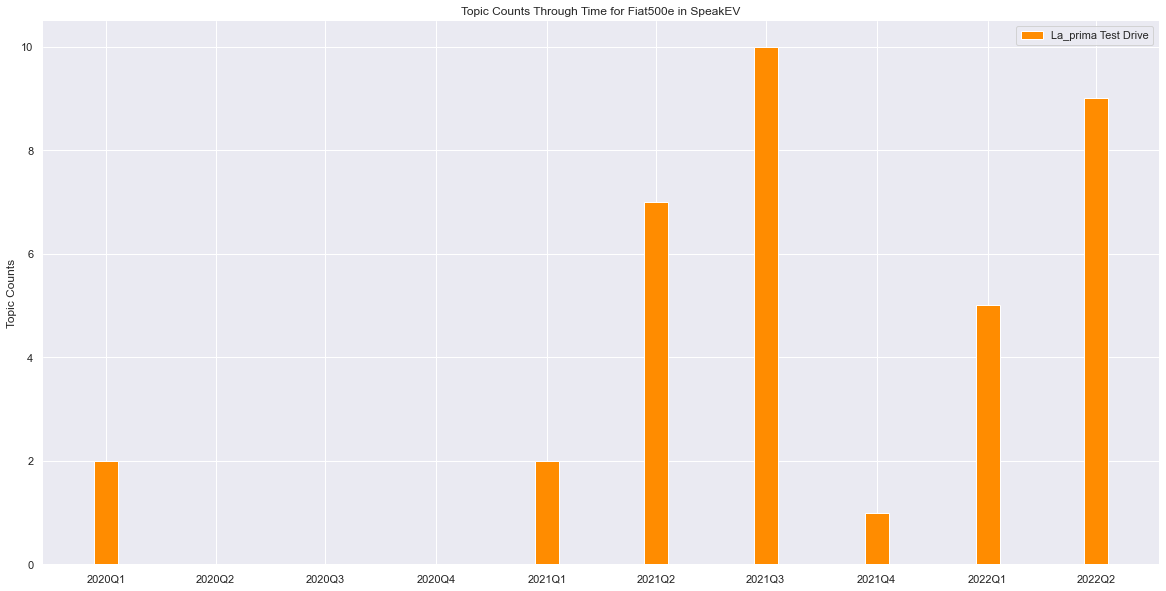

In [298]:
spec_topics_per_month(df_time_sentiment, 'Fiat500e', 'Fiat500hybrid', topic_labels = topic_labels,topic_num = 3)

In [299]:
speakEV_fiat500_combined['Main_topic1']= topic_larger_combined['Main_topic1']
topic_labels = ['Charge Speed and Mile Range', 'Vehicle CO2 Emission', 'Quality Feeling' ,'La_prima Test Drive',
   'Price and Car Grant','Configuration and Infortainment','Battery size and Power',
   'Purchases and Lease','Safety and Car Insurance']

Main_topic1 month_year sentiment  Fiat500e  Fiat500hybrid  Topic 1  Topic 2  \
0               2020Q1       neg       1.0            0.0        1        0   
1               2020Q1       neu       1.0            0.0        0        0   
2               2020Q1       pos       1.0            0.0        4        2   
3               2020Q2       pos       1.0            0.0        0        0   
4               2021Q1       neg       1.0            0.0        1        0   
5               2021Q1       neu       1.0            0.0        2        0   
6               2021Q1       pos       1.0            0.0        1        0   
7               2021Q2       neg       1.0            0.0        2        0   
8               2021Q2       neu       1.0            0.0        1        0   
9               2021Q2       pos       1.0            0.0        1        0   
10              2021Q3       neg       1.0            0.0        0        0   
11              2021Q3       neu       1.0          

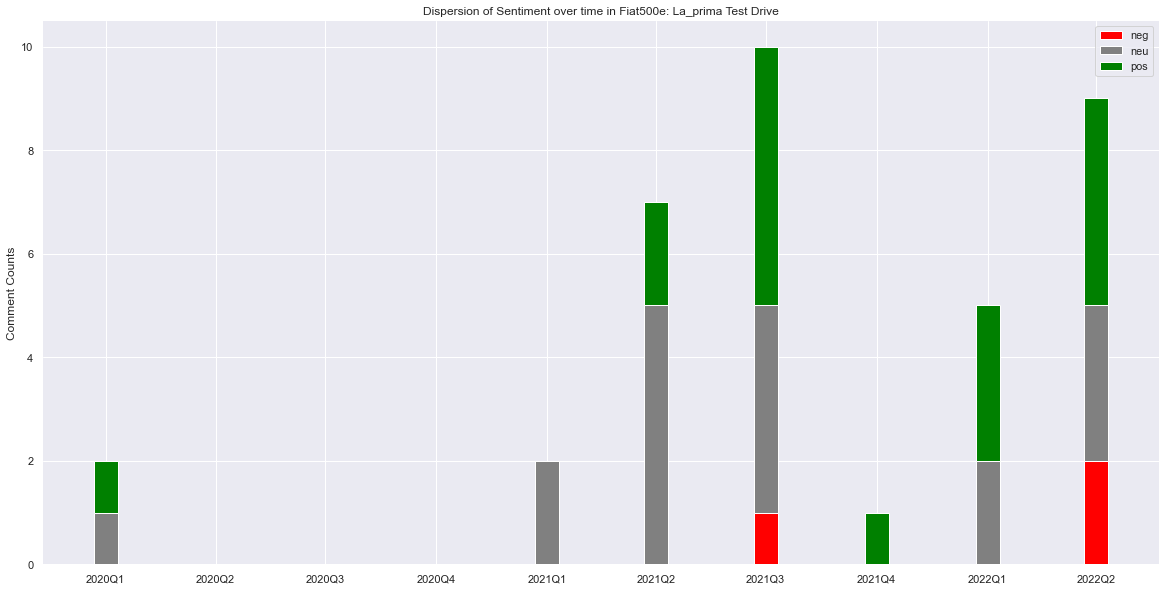

In [300]:
# bev
topic_sentiment_dispersion_plot(speakEV_fiat500_combined,  4, 'Fiat500e', 'Fiat500hybrid',  topic_labels)

PMI Topic 4 La_prima Test Drive in Fiat 500 BEV - Positive

In [301]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_tp4_bev_pos(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(1)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(1)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [313]:
tp4_bev_pos_df = bev_pos_df.loc[(bev_pos_df['Main_topic1'] == 'Topic 4')] 
tp4_bev_pos_bigrams, tp4_bev_pos_trigrams = pmi_tp4_bev_pos(df = tp4_bev_pos_df, column_name='Sentiment_corpus')
print(tp4_bev_pos_bigrams)
print('----------')
print(tp4_bev_pos_trigrams)

Number of words in the corpus: 317
[('add', 'foot'), ('afternoon', 'excite'), ('amp', 'kw'), ('aren', 'wallbox'), ('authority', 'override'), ('basketball', 'player'), ('beam', 'cheer'), ('bonnet', 'begin'), ('box', 'stupid'), ('bulb', 'improve'), ('chancellor', 'mouth'), ('characterful', 'wouldn'), ('cheer', 'easywallbox'), ('describe', 'hear'), ('distract', 'left'), ('don', 'know'), ('ease', 'granny'), ('easywallbox', 'product'), ('edition', 'ebay'), ('electric', 'feel'), ('electrician', 'fix'), ('emabc', 'great'), ('exactly', 'basketball'), ('excite', 'bet'), ('expensive', 'gov'), ('explicit', 'instruction'), ('fix', 'lot'), ('foot', 'length'), ('fuel', 'tank'), ('fully', 'grow'), ('fun', 'characterful'), ('gaz', 'yes'), ('glove', 'box'), ('got', 'distract'), ('gov', 'grand'), ('grand', 'stop'), ('granddaughter', 'child'), ('grow', 'man'), ('hear', 'word'), ('hing', 'glove'), ('hitch', 'rate'), ('impression', 'zoe'), ('inform', 'ownership'), ('instruction', 'gaz'), ('ip', 'edition'),

PMI Topic 4 La_prima Test Drive in Fiat 500 BEV - Neural

In [314]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_tp4_bev_neu(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(1)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(1)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [315]:
tp4_bev_neu_df = bev_neu_df.loc[(bev_neu_df['Main_topic1'] == 'Topic 4')] 
tp4_bev_neu_bigrams, tp4_bev_neu_trigrams = pmi_tp4_bev_neu(df = tp4_bev_neu_df, column_name='Sentiment_corpus')
print(tp4_bev_neu_bigrams)
print('----------')
print(tp4_bev_neu_trigrams)

Number of words in the corpus: 113
[('actually', 'suggest'), ('add', 'winter'), ('afternoon', 'jordans'), ('aka', 'toaster'), ('allow', 'register'), ('appointment', 'monday'), ('ask', 'people'), ('blue', 'try'), ('boot', 'irrational'), ('box', 'appear'), ('celestial', 'blue'), ('compare', 'actually'), ('control', 'whiff'), ('czero', 'heavy'), ('delivery', 'date'), ('demonstrate', 'control'), ('door', 'like'), ('dramatically', 'lighten'), ('ev', 'czero'), ('exist', 'future'), ('ft', 'weigh'), ('future', 'ev'), ('glove', 'box'), ('heavy', 'steel'), ('hull', 'weren'), ('icon', 'dramatically'), ('irrational', 'ask'), ('item', 'add'), ('jordans', 'hull'), ('lead', 'pick'), ('lift', 'plus'), ('lighten', 'exist'), ('m', 'aware'), ('meantime', 'mighty'), ('non', 'cabrio'), ('old', 'glove'), ('pack', 'm'), ('people', 'race'), ('permanently', 'wire'), ('platform', 'relate'), ('plus', 'boot'), ('race', 'ft'), ('relate', 'old'), ('reseal', 'permanently'), ('ring', 'celestial'), ('saturday', 'place

Main Takeaway: Topic 4 La_prima Test Drive BEV 
- Postive: 
    - ('cheer','easywallbox') - quickest and simplest way to charge at home.
    - ('fun', 'characterful')，('love', 'la', 'prima')


- Neural:
    - ('heavy', 'steel', 'door')
    - ('old', 'glove', 'box'),
    - ('wait', 'delivery', 'date'),
    - ('short', 'cable'), e.g.  permanently wired and upgraded to 7kw, but has a very short cable

### Topic 'Purchase and Lease' for Fiat 500 Hybrid

,Charge Speed and Mile Range,Vehicle CO2 Emission,Quality Feeling,La_prima Test Drive,Price and Car Grant,Configuration and Infortainment,Battery size and Power,Purchases and Lease,Safety and Car Insurance
month_year,,,,,,,,,
2020Q1,0,0,5,2,3,0,0,3,0
2020Q2,1,0,0,0,0,0,2,0,0
2020Q3,0,0,2,0,5,1,0,1,0
2020Q4,0,0,2,1,0,0,0,0,0
2021Q1,3,0,7,0,12,0,2,13,0
2021Q2,9,8,9,2,4,2,1,4,0
2021Q3,3,0,1,1,0,0,0,0,0
2021Q4,3,1,3,1,1,1,2,1,2
2022Q1,2,0,2,1,2,4,2,5,2


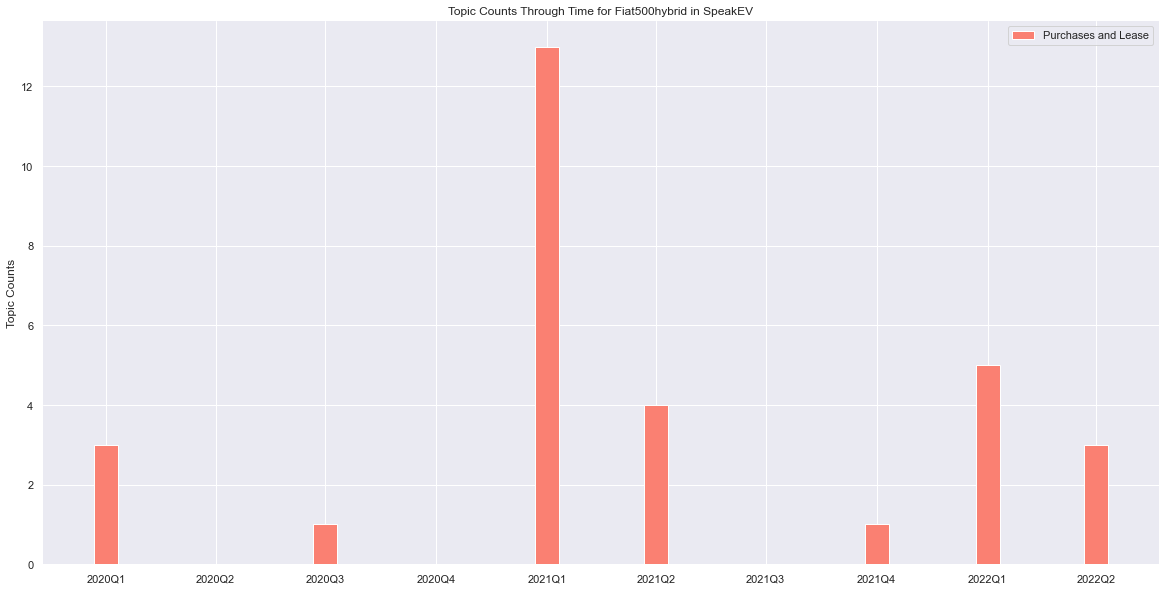

In [316]:
spec_topics_per_month(df_time_sentiment,  'Fiat500hybrid', 'Fiat500e', topic_labels = topic_labels, topic_num = 7)

Main_topic1 month_year sentiment  Fiat500hybrid  Fiat500e  Topic 1  Topic 2  \
0               2020Q1       neu            1.0       0.0        0        0   
1               2020Q1       pos            1.0       0.0        0        0   
2               2020Q2       neg            1.0       0.0        1        0   
3               2020Q2       pos            1.0       0.0        0        0   
4               2020Q3       neg            1.0       0.0        0        0   
5               2020Q3       neu            1.0       0.0        0        0   
6               2020Q3       pos            1.0       0.0        0        0   
7               2020Q4       pos            1.0       0.0        0        0   
8               2021Q1       neg            1.0       0.0        1        0   
9               2021Q1       neu            1.0       0.0        1        0   
10              2021Q1       pos            1.0       0.0        1        0   
11              2021Q2       neg            1.0     

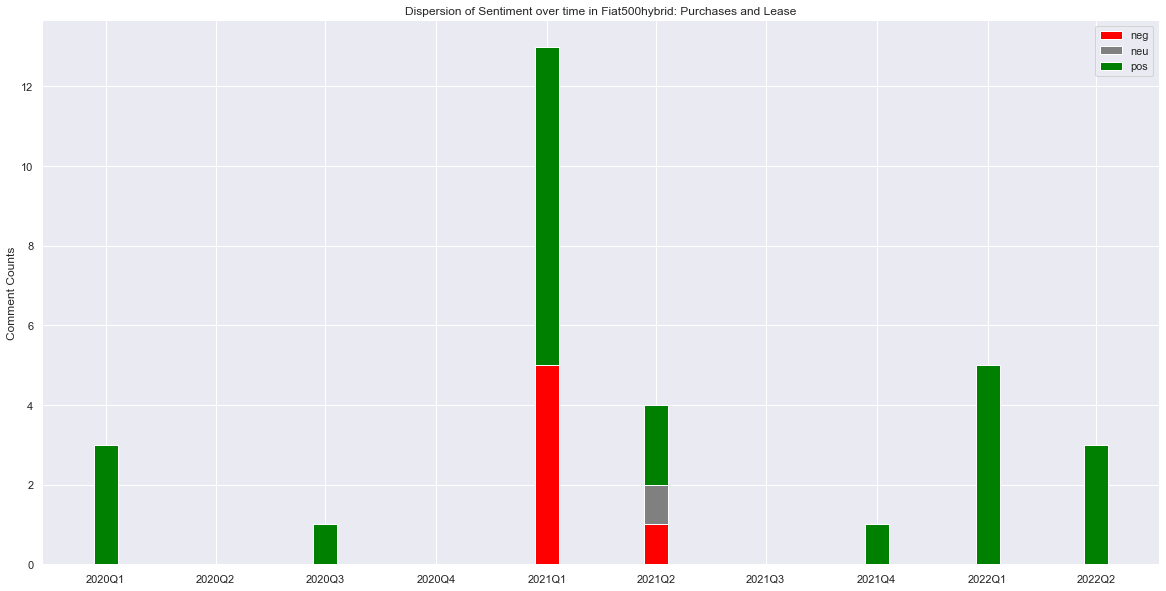

In [317]:
# bev
topic_sentiment_dispersion_plot(speakEV_fiat500_combined,  8,  'Fiat500hybrid','Fiat500e',  topic_labels)

PMI Topic 8 Purchases and Lease in Fiat 500 Hybrid - Positive

In [318]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_tp8_hybrid_pos(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [319]:
tp8_hybrid_pos_df = hybrid_pos_df.loc[(hybrid_pos_df['Main_topic1'] == 'Topic 8')] 
tp8_bev_pos_bigrams, tp8_bev_pos_trigrams = pmi_tp8_hybrid_pos(df = tp8_hybrid_pos_df, column_name='Sentiment_corpus')
print(tp8_bev_pos_bigrams)
print('----------')
print(tp8_bev_pos_trigrams)

Number of words in the corpus: 1105
[('wheel', 'rim'), ('bank', 'account'), ('customer', 'switch'), ('revenue', 'sale'), ('excess', 'immediately'), ('hand', 'key'), ('don', 'understand'), ('item', 'deduction'), ('line', 'item'), ('retail', 'price'), ('value', 'score'), ('tax', 'ni'), ('tax', 'thing'), ('earn', 'deduction'), ('maybe', 'good'), ('buy', 'cash'), ('lose', 'interest'), ('low', 'mileage'), ('pcp', 'interest'), ('lease', 'firm'), ('interest', 'payment'), ('net', 'revenue'), ('govt', 'pay'), ('quid', 'month'), ('gross', 'net'), ('net', 'save'), ('work', 'cheap'), ('previous', 'lease'), ('great', 'deal'), ('past', 'year'), ('vat', 'net'), ('month', 'score'), ('car', 'sell'), ('demo', 'car'), ('lease', 'great'), ('month', 'add'), ('grant', 'vat'), ('cheap', 'deal'), ('pay', 'tax'), ('drive', 'car'), ('year', 've'), ('pay', 'grant'), ('buy', 'car'), ('price', 'car'), ('car', 'cost'), ('car', 'year'), ('month', 'pay'), ('car', 'month'), ('car', 'lease'), ('lease', 'car')]
--------

Main Takeaway: Topic 8 Purchase and Lease in Fiat 500 Hybrid
- Postive: 
    - ('pcp', 'interest')
    - ('month','pay)
    - ('cheap', 'deal')



## Super Postivie / Negative in Fiat 500 BEV/ Hybrid, calculate the Topic Counts

In [320]:
# Super positive / negative in Fiat 500 BEV
bev_pos_df  = bev_pos_df.copy()
bev_pos_df = bev_pos_df.loc[(bev_pos_df['Main_topic1'] != 'Topic 2') & (bev_pos_df['Main_topic1'] != 'Topic 4') & (bev_pos_df['Main_topic1'] != 'Topic 5') & (bev_pos_df['Main_topic1'] != 'Topic 6') ]
sup_bev_pos_df = bev_pos_df.loc[bev_pos_df['compound'] > 0.5]

bev_neg_df  = bev_neg_df.copy()
bev_neg_df = bev_neg_df.loc[(bev_neg_df['Main_topic1'] != 'Topic 2') & (bev_neg_df['Main_topic1'] != 'Topic 4') & (bev_neg_df['Main_topic1'] != 'Topic 5') & (bev_neg_df['Main_topic1'] != 'Topic 6') ]
sup_bev_neg_df = bev_neg_df.loc[bev_neg_df['compound'] < -0.5]

# Neural in Fiat 500 BEV
bev_neu_df  = bev_neu_df.copy()
bev_neu_df = bev_neu_df.loc[(bev_neu_df['Main_topic1'] != 'Topic 2') & (bev_neu_df['Main_topic1'] != 'Topic 4') & (bev_neu_df['Main_topic1'] != 'Topic 5') & (bev_neu_df['Main_topic1'] != 'Topic 6') ]

# Super positive / negative in Fiat 500 Hybrid
hybrid_pos_df  = hybrid_pos_df.copy()
hybrid_pos_df = hybrid_pos_df.loc[(hybrid_pos_df['Main_topic1'] != 'Topic 2') & (hybrid_pos_df['Main_topic1'] != 'Topic 4') & (hybrid_pos_df['Main_topic1'] != 'Topic 5') & (hybrid_pos_df['Main_topic1'] != 'Topic 6') ]
sup_hybrid_pos_df = hybrid_pos_df.loc[hybrid_pos_df['compound'] > 0.5]

hybrid_neg_df  = hybrid_neg_df.copy()
hybrid_neg_df = hybrid_neg_df.loc[(hybrid_neg_df['Main_topic1'] != 'Topic 2') & (hybrid_neg_df['Main_topic1'] != 'Topic 4') & (hybrid_neg_df['Main_topic1'] != 'Topic 5') & (hybrid_neg_df['Main_topic1'] != 'Topic 6') ]
sup_hybrid_neg_df = hybrid_neg_df.loc[hybrid_neg_df['compound'] < -0.5]



In [321]:
sup_bev_pos_df['Main_topic1'].value_counts().sort_values(ascending = False)

Topic 3    17
Topic 7    14
Topic 1    10
Topic 8     4
Topic 9     3
Name: Main_topic1, dtype: int64

In [322]:
sup_hybrid_pos_df['Main_topic1'].value_counts().sort_values(ascending = False)

Topic 8    18
Topic 1    18
Topic 3    17
Topic 7     9
Topic 9     3
Name: Main_topic1, dtype: int64

In [323]:
sup_bev_neg_df['Main_topic1'].value_counts().sort_values(ascending = False)

Topic 3    4
Topic 9    3
Topic 7    2
Topic 1    1
Name: Main_topic1, dtype: int64

In [324]:
sup_hybrid_neg_df['Main_topic1'].value_counts().sort_values(ascending = False)

Topic 8    4
Topic 1    3
Topic 3    2
Topic 7    1
Name: Main_topic1, dtype: int64

In [325]:
# Neural in Fiat 500 BEV
bev_neu_df['Main_topic1'].value_counts().sort_values(ascending = False)

Topic 3    18
Topic 1     6
Topic 7     3
Topic 9     2
Topic 8     2
Name: Main_topic1, dtype: int64

PMI Topic Quality Feeling Fiat 500 BEV Neural

In [326]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_tp3_bev_neu(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(1)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(1)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [327]:
tp3_bev_neu_df = bev_neu_df.loc[(bev_neu_df['Main_topic1'] == 'Topic 3')] 
tp3_bev_neu_bigrams, tp3_bev_neu_trigrams = pmi_tp3_bev_neu(df = tp3_bev_neu_df, column_name='Sentiment_corpus')
print(tp3_bev_neu_bigrams)
print('----------')
print(tp3_bev_neu_trigrams)

Number of words in the corpus: 128
[('addition', 'find'), ('apparently', 'mean'), ('base', 'routemaster'), ('case', 'maintain'), ('charge', 'cable'), ('civilized', 'country'), ('con', 'use'), ('convertible', 'showroom'), ('country', 'south'), ('couple', 'month'), ('currently', 'list'), ('decent', 'discount'), ('delivery', 'end'), ('demonstrator', 'wrexham'), ('deposit', 'pay'), ('diesel', 'stoke'), ('drive', 'tomorrow'), ('e', 'don'), ('early', 'july'), ('electric', 'highway'), ('end', 'march'), ('eu', 'insist'), ('existent', 'puzzle'), ('fiat', 'apparently'), ('field', 'eu'), ('find', 'paperwork'), ('gov', 'uk'), ('hang', 'couple'), ('heater', 'switch'), ('highway', 'technology'), ('insist', 'negotiation'), ('instal', 'podpoint'), ('korea', 'road'), ('level', 'playing'), ('list', 'status'), ('litre', 'petrol'), ('ll', 'hang'), ('local', 'tesco'), ('maintain', 'level'), ('mean', 'sit'), ('money', 'run'), ('month', 'test'), ('negotiation', 'non'), ('non', 'existent'), ('paperwork', 'cha

Main Takeaway:
- People generally discussed about the delivery waiting time  ('sit', 'wait', 'ship')('delivery', 'end', 'march'), ('deposit', 'pay', 'delivery')
- Charging installation ('find', 'paperwork', 'charge'), ('instal', 'podpoint')

# Q2 The differences between Fiat 500 Brand and Fiat Brand

## Visualisation1: Dicussion Trending of Brand Over Time -- Remove

In [328]:
speakEV_brand_full_df = pd.concat([speakEV_fiat_brand, speakEV_fiat500_brand],axis=0)

# Check Discussion Date 2020-01-01 - now
speakEV_brand_full_df['date'] = pd. to_datetime(speakEV_brand_full_df['Discussion Date'])
speakEV_brand_full_df['month_year'] = pd.to_datetime(speakEV_brand_full_df['date']).dt.to_period('Q')
speakEV_brand_full_df = speakEV_brand_full_df.loc[speakEV_brand_full_df['month_year'].between('2020-01','2022-07', inclusive=True)]


In [329]:
# brand mentioned counts through time
speakEV_brand_discussion_df = speakEV_brand_full_df.groupby(['month_year']) ['Fiat500','Fiat_Brand'].sum().reset_index()
# speakEV_brand_discussion_df['month_year'] = pd.to_datetime(speakEV_brand_discussion_df['month_year'].astype(str))
# speakEV_brand_discussion_df = speakEV_brand_discussion_df.drop([10])

In [330]:
# # Import Library
# import matplotlib.pyplot as plt
# # Plot Mentioned Counts
# fig = plt.figure(figsize = (20,8), facecolor = None)
# ax = fig.add_subplot()
# # plt.plot(speakEV_brand_discussion_df['month_year'],speakEV_brand_discussion_df["Fiat500"], marker='o', label = 'Fiat 500 Bramd', c= 'blue')
# # plt.plot(speakEV_brand_discussion_df['month_year'],speakEV_brand_discussion_df["Fiat_Brand"], marker='o',label = 'Fiat Brand', c= 'green',ls ='--',alpha = 0.8)
# colors = ['blue','green']
# brand_labels = ['Fiat 500 Brand','Fiat Brand']
# brand_columns = ['Fiat500','Fiat_Brand']
# t = np.arange(0,10,1)
# for i in range(0,2):
#     ax.plot(t,speakEV_brand_discussion_df[brand_columns[i]],marker = 'o', label = brand_labels[i], c = colors[i])

# # Labelling 
# plt.ylabel("Mentioned Times")
# plt.title("Quarterly Comments for Fiat 500 Brand and Fiat Brand",color = 'dimgray', size = 15, fontweight='bold')

# # Display
# ## aest
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# # Labelling 
# ax.set_xticks(range(0,10,1))
# # ax.set_xticklabels([topics_trend['month_year'].dt.strftime('%m/%Y')[i] for i in range(0,10,1)])
# ax.set_xticklabels([speakEV_brand_discussion_df['month_year'][j] for j in range(0,10,1)], size = 12)

# plt.axvspan(7.5,8.5, facecolor='grey', alpha=0.1)

# # Peak  # fiat 500X
# ax.annotate("Fiat Panda \nElectrifying Planning", xy=(8, 85), xytext=(8,85), weight='bold',
#             size = 14 , color="dimgray")

# plt.legend(loc=1)
# plt.show()

## Sentiment Analysis - Q2 Brand

In [331]:
# Text Cleaning
# Create the corpus
clean_corpus_brand = [cleaning_text_speakEV(comment) for comment in speakEV_brand_full_df['Comment']]

# add clean corpus to dataframe
speakEV_brand_full_df['Clean_Corpus'] = clean_corpus_brand

In [332]:
# Create the corpus for sentiment analysis

corpus_sentiment_brand = [cleaning_text_sentiment_speakEV(comment) for comment in speakEV_brand_full_df['Clean_Corpus']]
speakEV_brand_full_df.loc[:,'Sentiment_corpus'] =  corpus_sentiment_brand

In [334]:
# speakEV_brand_full_df = sentiment(speakEV_brand_full_df, 'Comment')

In [335]:
speakEV_fiat_brand = speakEV_brand_full_df.loc[(speakEV_brand_full_df['Fiat500'] !=1) & (speakEV_brand_full_df['Fiat_Brand'] ==1)]
speakEV_fiat500_brand = speakEV_brand_full_df.loc[(speakEV_brand_full_df['Fiat500'] ==1) & (speakEV_brand_full_df['Fiat_Brand'] !=1)]
print('Number of comments only mentioned Fiat 500 Brand: {}'.format(speakEV_fiat500_brand.shape[0]))
print('Number of comments only mentioned Fiat Brand: {}'.format(speakEV_fiat_brand.shape[0]))

Number of comments only mentioned Fiat 500 Brand: 848
Number of comments only mentioned Fiat Brand: 161



    Data information
    --------------------------------------
    Total number of comments: 848
    Average lenght of each reply: 515.7 characters
    Average words per comment: 92.7 words
    
    Number of positive comments (compound >0.05) is 577 (68.0%)
    Number of negative comments (compound <-0.05) is 159 (18.8%)
    Number of neutral comments (compound is between -0.05 and 0.05) is 112 (13.2%)
    
    Number of super positive comments (compound > 0.5) is 382 (45.0%)
    Number of super negative comments (compound < -0.5) is 59 (7.0%)
    --------------------------------------
    


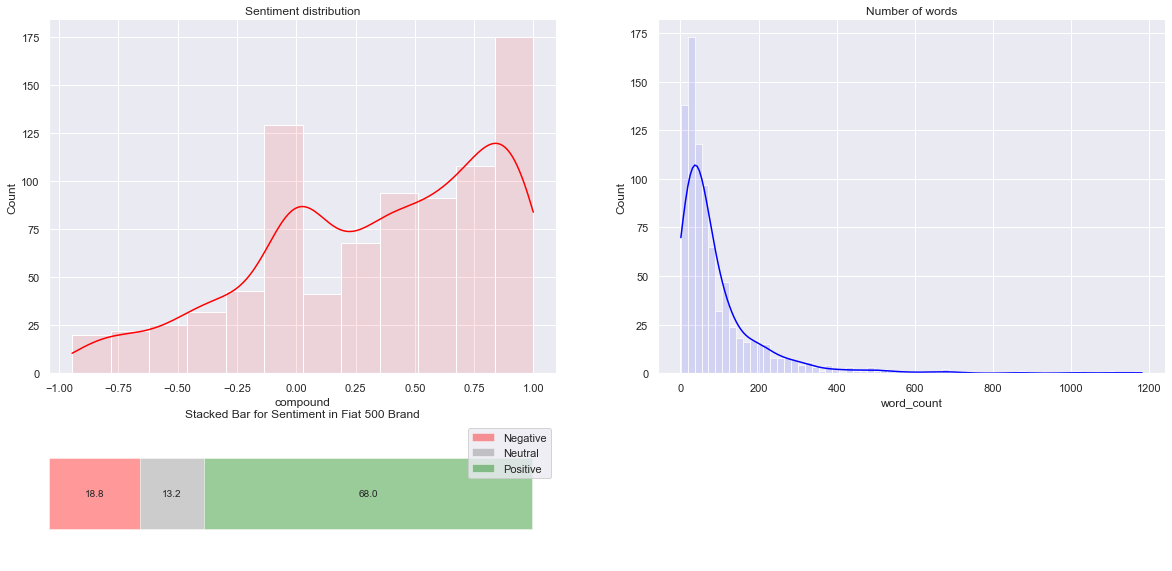

In [336]:
sentiment_explor_speakEV(speakEV_fiat500_brand,'Comment','Fiat 500 Brand')



    Data information
    --------------------------------------
    Total number of comments: 161
    Average lenght of each reply: 431.83 characters
    Average words per comment: 76.9 words
    
    Number of positive comments (compound >0.05) is 103 (64.0%)
    Number of negative comments (compound <-0.05) is 45 (28.0%)
    Number of neutral comments (compound is between -0.05 and 0.05) is 13 (8.1%)
    
    Number of super positive comments (compound > 0.5) is 70 (43.5%)
    Number of super negative comments (compound < -0.5) is 20 (12.4%)
    --------------------------------------
    


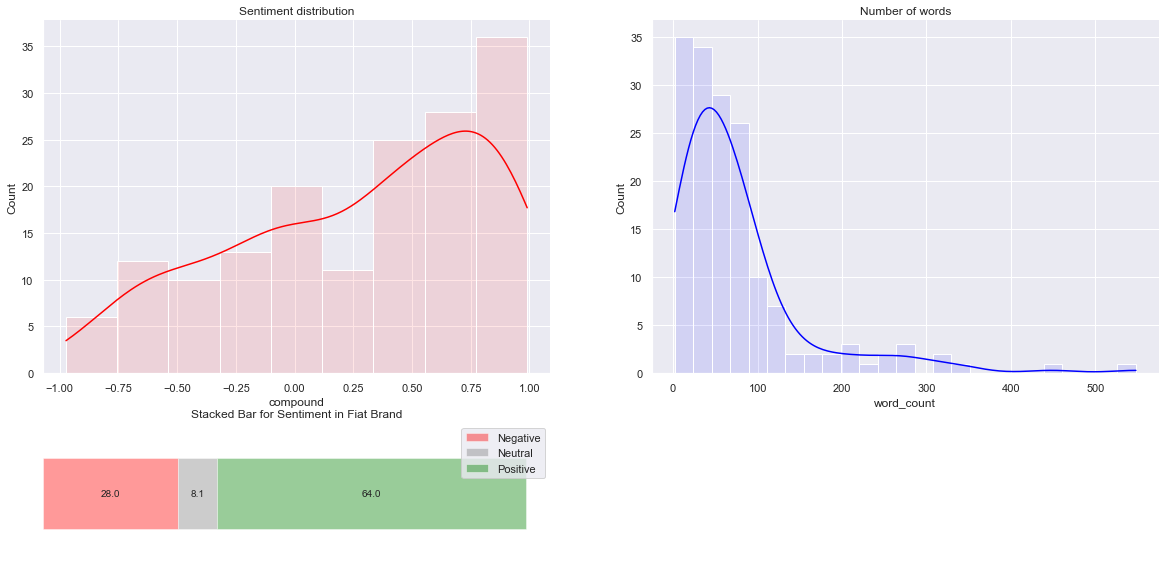

In [337]:
sentiment_explor_speakEV(speakEV_fiat_brand,'Comment', 'Fiat Brand')

Main Takeaway:
- In general, Fiat 500 brand discussed more positively than Fiat brand
- Fiat Brand has more 12.4% of super negative comments, compared with 7.0% of Fiat 500 Brand -> deeper in super negative comments in Fiat Brand.
- Fiat 500 Brand has 45% of super postive comments -> deeper in super postive comments in Fiat 500 Brand


### Sentiment Dispersion Over Time

In [338]:
# brand mentioned counts through time
speakEV_fiat500_brand_discussion_df = speakEV_fiat500_brand.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)
speakEV_fiat_brand_discussion_df = speakEV_fiat_brand.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)
speakEV_fiat_brand_discussion_df

sentiment,neg,neu,pos
month_year,,,
2020Q1,3,0,0
2020Q2,1,0,2
2020Q4,5,0,0
2021Q1,3,0,1
2021Q2,3,0,6
2021Q3,2,1,8
2021Q4,2,1,6
2022Q1,20,10,53
2022Q2,6,1,25


In [339]:
line = pd.DataFrame({"neg": 0, "neu": 0,'pos':0}, index=['2020Q3'])
speakEV_fiat_brand_discussion_df_update= pd.concat([speakEV_fiat_brand_discussion_df.iloc[:2], line, speakEV_fiat_brand_discussion_df.iloc[2:]])
speakEV_fiat_brand_discussion_df_update

sentiment,neg,neu,pos
2020Q1,3,0,0
2020Q2,1,0,2
2020Q3,0,0,0
2020Q4,5,0,0
2021Q1,3,0,1
2021Q2,3,0,6
2021Q3,2,1,8
2021Q4,2,1,6
2022Q1,20,10,53
2022Q2,6,1,25


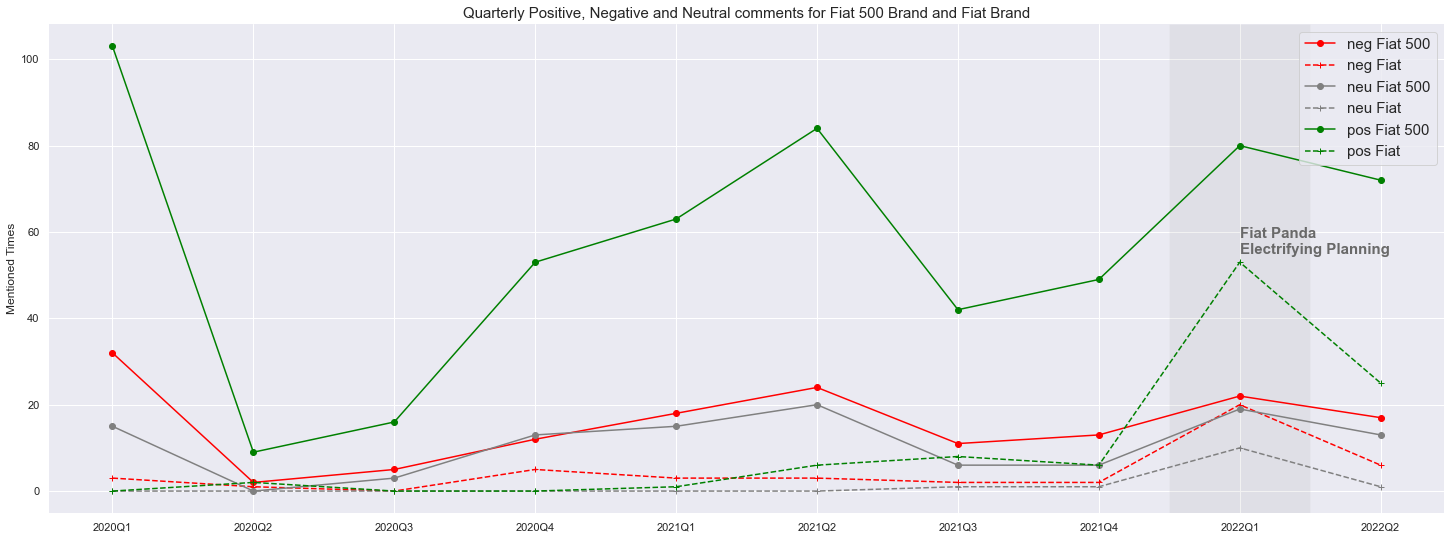

In [340]:
# Import Library
import matplotlib.pyplot as plt
# Plot Mentioned Counts
fig = plt.figure(figsize = (25,9), facecolor = None)
ax = fig.add_subplot()
label = ['neg','neu','pos']
label1 = ['neg Fiat 500','neu Fiat 500','pos Fiat 500']
label2= ['neg Fiat','neu Fiat','pos Fiat']
color = ['red','grey','green']


quarter1 = np.arange(0,10,1)
for i in range(0,3):
    ax.plot(quarter1,speakEV_fiat500_brand_discussion_df[label[i]][0:10], marker='o', label = label1[i], c= color[i])
    ax.plot(quarter1,speakEV_fiat_brand_discussion_df_update[label[i]][0:10], marker='+',label = label2[i], c= color[i],ls ='--')


# Labelling 
ax.set_xticks(range(0,10,1))
# ax.set_xticklabels([topics_trend['month_year'].dt.strftime('%m/%Y')[i] for i in range(0,10,1)])
ax.set_xticklabels(speakEV_fiat_brand_discussion_df_update.index[j] for j in range(0,10,1))

plt.ylabel("Mentioned Times")
plt.title("Quarterly Positive, Negative and Neutral comments for Fiat 500 Brand and Fiat Brand", size = 15)


plt.axvspan(7.5,8.5, facecolor='grey', alpha=0.1)

# Peak  # fiat 500X
ax.annotate("Fiat Panda \nElectrifying Planning", xy=(8, 55), xytext=(8,55), weight='bold',
            size = 15 , color="dimgray")

# Display
## aest
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.legend(loc=1,fontsize=15)
plt.show()

In [341]:
brand_2021Q1 = speakEV_brand_full_df.loc[(speakEV_brand_full_df['month_year'] == '2022Q1')& (speakEV_brand_full_df['Fiat500'] !=1) & (speakEV_brand_full_df['Fiat_Brand'] ==1)]
brand_2021Q1_panda = brand_2021Q1[brand_2021Q1['Comment'].str.contains('pandas|panda')]
brand_2021Q1_panda_electric = brand_2021Q1[brand_2021Q1['Comment'].str.contains('pandas|panda') & brand_2021Q1['Comment'].str.contains('ev|electric|electrify') ]
panda_percentage = brand_2021Q1_panda.shape[0]/ brand_2021Q1.shape[0]
print('{}%  of comments in 2021Q1 related to pandas'.format(round(panda_percentage *100,2)))
panda_electric_percentage = brand_2021Q1_panda_electric.shape[0]/brand_2021Q1_panda.shape[0]
print('{}%  of comments mentioned panda related to electric/ev edition'.format(round(panda_electric_percentage *100,2)))
print('{}% of people with postiive sentiment towards panda ev edition'.format(round(np.sum(brand_2021Q1_panda_electric['sentiment'] == 'pos')/brand_2021Q1_panda_electric.shape[0] *100,2)))

22.89%  of comments in 2021Q1 related to pandas
47.37%  of comments mentioned panda related to electric/ev edition
66.67% of people with postiive sentiment towards panda ev edition


In [342]:
def senti_dipersion_brand(df,brand,label1):
    # Plot Mentioned Counts
    fig = plt.figure(figsize = (25,8), facecolor = None)
    ax = fig.add_subplot()
    label = ['neg','neu','pos']
    width = 0.3
    # label2= ['neg Fiat','neu Fiat','pos Fiat']
    color = ['red','grey','green']

    quarter1 = np.arange(0,11,1)

    bottom = [0]
    plt.bar(quarter1,df[label[0]], width, label = label1[0], color = color[0])

    for i in range(1, 3):
        bottom.append(bottom[i-1] + df[label[i-1]])
        plt.bar(quarter1,df[label[i]], width, label = label1[i], color = color[i], bottom = bottom[i])

    # Labelling 
    # Labelling 
    ax.set_xticks(range(0,11,1))
    # ax.set_xticklabels([topics_trend['month_year'].dt.strftime('%m/%Y')[i] for i in range(0,10,1)])
    ax.set_xticklabels(df.index[j] for j in range(0,11,1))

    plt.ylabel("Mentioned Times")
    plt.title("Quarterly Positive, Negative and Neutral comments for {}".format(brand), size = 15)


    # Display
    ## aest
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.legend()
    plt.show()

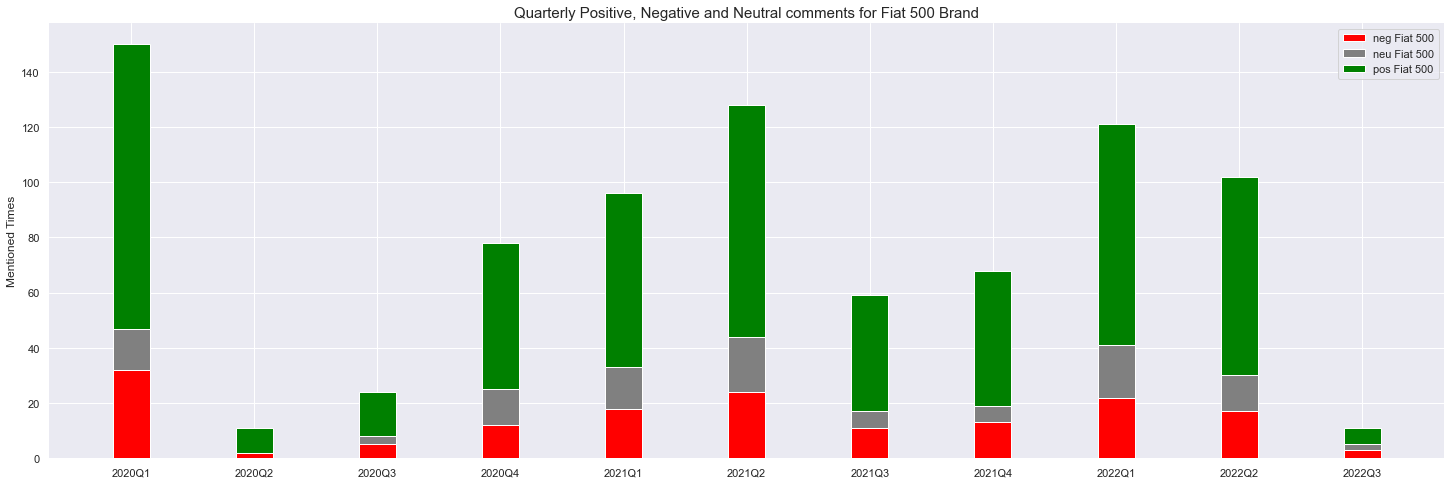

In [343]:
senti_dipersion_brand(speakEV_fiat500_brand_discussion_df,brand='Fiat 500 Brand',  label1 = ['neg Fiat 500','neu Fiat 500','pos Fiat 500'])

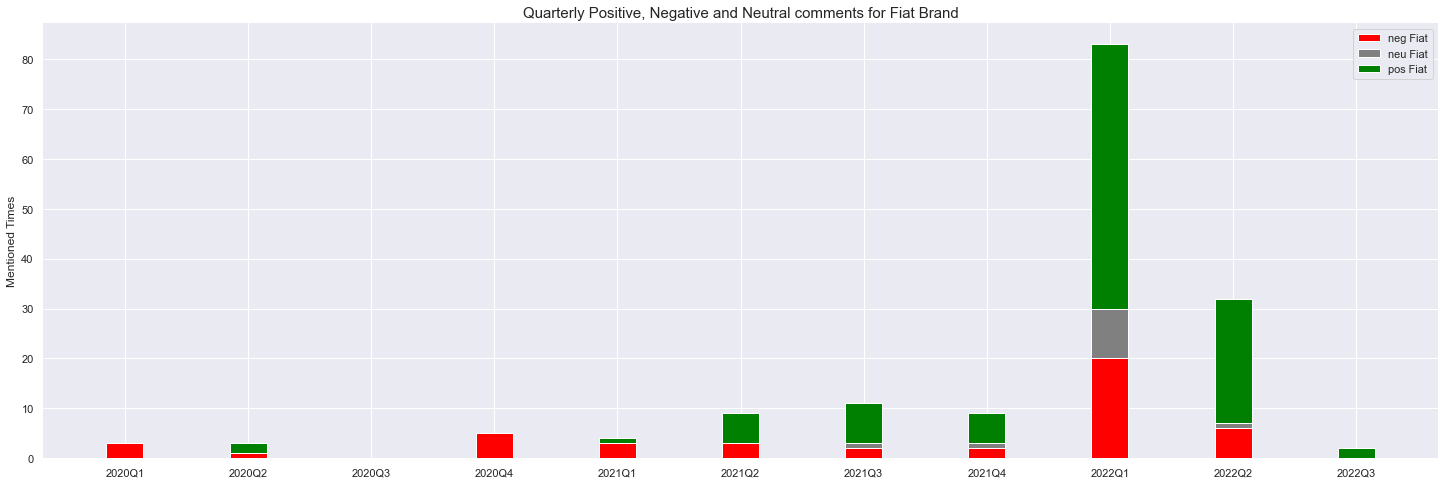

In [344]:
senti_dipersion_brand(speakEV_fiat_brand_discussion_df_update,brand='Fiat Brand',label1 = ['neg Fiat','neu Fiat','pos Fiat'])

In [345]:
brand_2022Q1 = speakEV_brand_full_df.loc[(speakEV_brand_full_df['month_year'] == '2022Q1')& (speakEV_brand_full_df['Fiat500'] !=1) & (speakEV_brand_full_df['Fiat_Brand'] ==1)]
brand_2022Q1_pos = brand_2022Q1[brand_2022Q1['sentiment'] == 'pos']
print('{}% of comments are postiive'.format(round(brand_2022Q1_pos.shape[0]/brand_2022Q1.shape[0] * 100, 2)))

brand_2022Q1_pos_panda = brand_2022Q1_pos[brand_2022Q1_pos['Comment'].str.contains('pandas|panda')]
print('{}% of positive comments in Q1-2022 related to Fiat Panda'.format(round(brand_2022Q1_pos_panda.shape[0]/brand_2022Q1_pos.shape[0] *100),2))

brand_2022Q1_pos_pandaev = brand_2022Q1_pos[brand_2022Q1_pos['Comment'].str.contains('pandas|panda') & brand_2022Q1_pos['Comment'].str.contains('ev|electric|electrify') ]
print('People interested in Fiat Panda in Q1-2022, with {}% of positive attitudes towards EV edition'.format(round(brand_2022Q1_pos_pandaev.shape[0]/brand_2022Q1_pos_panda.shape[0] *100),2))

63.86% of comments are postiive
28% of positive comments in Q1-2022 related to Fiat Panda
People interested in Fiat Panda in Q1-2022, with 40% of positive attitudes towards EV edition


Main Takeaway:
https://www.electrive.com/2022/01/20/fiat-considers-electrifying-the-panda/
- Discussion Trend for Fiat 500 Brand is stable, a spike for Fiat Brand in 2022Q1 since the company announced the Fiat Panda Electrifying Planning, impacting the general dicussion within Fiat Brand. 28% of positive comments related to Fiat Panda. People interested in Fiat Panda in Q1-2022, with 40% of positive attitudes towards EV edition. 

### Mentioned Times and Sentiment Compound Changed Through Time -- Brand

In [346]:
speakEV_fiat500_full_df = pd.read_csv('0801_Fiat500_subforum_speakEV.csv',index_col=0)

# Extract Fiat 500e & Fiat 500hybrid subset
speakEV_fiat500_full_df['Comment'] = speakEV_fiat500_full_df['Comment'].str.lower()
speakEV_fiat500_full_df['Thread Title'] = speakEV_fiat500_full_df['Thread Title'].str.lower()
speakEV_fiat500_full_df = speakEV_fiat500_full_df.rename(columns = {'Thread Title':'Thread_Title'})

# append Fiat 500e column
speakEV_fiat500_full_df = extracting_BEV(speakEV_fiat500_full_df, 'Comment','Thread_Title')

# append Fiat 500 hybrid column
speakEV_fiat500_full_df = extracting_hybrid(speakEV_fiat500_full_df)

# append both Fiat 500e and 500 hybrid column; combined dataset
speakEV_fiat500_combined, speakEV_fiat500e,speakEV_fiat500hyb,speakEV_fiat500_full_df = extracting_combined(speakEV_fiat500_full_df)

# mentioned fiat
speakEV_fiat_brand, speakEV_fiat500_brand, speakEV_fiat500_full_df =  extracting_fiat(speakEV_fiat500_full_df)

print("The number of comments mentioned Fiat brand: {}.".format(speakEV_fiat_brand.shape))
print("The number of comments mentioned Fiat500 brand: {}.".format(speakEV_fiat500_brand.shape))
print("The number of comments mentioned both Fiat 500e and 500 hybrid: {}.".format(sum(speakEV_fiat500_combined['Compare']==1)))
print("The number of comments mentioned Fiat 500e: {}.".format(speakEV_fiat500e.shape))
print("The number of comments mentioned Fiathybrid/Fiat 500: {}.".format(speakEV_fiat500hyb.shape))

The number of comments mentioned Fiat brand: (162, 14).
The number of comments mentioned Fiat500 brand: (951, 14).
The number of comments mentioned both Fiat 500e and 500 hybrid: 951.
The number of comments mentioned Fiat 500e: (241, 10).
The number of comments mentioned Fiathybrid/Fiat 500: (182, 10).


In [347]:
speakEV_brand_full_df = pd.DataFrame()
speakEV_brand_full_df = pd.concat([speakEV_fiat_brand, speakEV_fiat500_brand],axis=0)

# Check Discussion Date 2020-01-01 - now
speakEV_brand_full_df['date'] = pd. to_datetime(speakEV_brand_full_df['Discussion Date'])
speakEV_brand_full_df['month_year'] = pd.to_datetime(speakEV_brand_full_df['date']).dt.to_period('M')
speakEV_brand_full_df = speakEV_brand_full_df.loc[speakEV_brand_full_df['month_year'].between('2020-01','2022-07', inclusive=True)]

# Text Cleaning
# Create the corpus
clean_corpus_brand = [cleaning_text_speakEV(comment) for comment in speakEV_brand_full_df['Comment']]

# add clean corpus to dataframe
speakEV_brand_full_df['Clean_Corpus'] = clean_corpus_brand

# Create the corpus for sentiment analysis

corpus_sentiment_brand = [cleaning_text_sentiment_speakEV(comment) for comment in speakEV_brand_full_df['Clean_Corpus']]
speakEV_brand_full_df.loc[:,'Sentiment_corpus'] =  corpus_sentiment_brand


In [348]:
speakEV_brand_full_df = sentiment(speakEV_brand_full_df, 'Comment')

100%|██████████| 1009/1009 [00:00<00:00, 1899485.07it/s]


In [349]:
speakEV_fiat_brand = speakEV_brand_full_df.loc[(speakEV_brand_full_df['Fiat500'] !=1) & (speakEV_brand_full_df['Fiat_Brand'] ==1)]
speakEV_fiat500_brand = speakEV_brand_full_df.loc[(speakEV_brand_full_df['Fiat500'] ==1) & (speakEV_brand_full_df['Fiat_Brand'] !=1)]
print('Number of comments only mentioned Fiat 500 Brand: {}'.format(speakEV_fiat500_brand.shape[0]))
print('Number of comments only mentioned Fiat Brand: {}'.format(speakEV_fiat_brand.shape[0]))

Number of comments only mentioned Fiat 500 Brand: 848
Number of comments only mentioned Fiat Brand: 161


In [350]:
speakEV_fiat500_brand_compound = speakEV_fiat500_brand.groupby('month_year') \
       .agg({'compound':'mean'}) 

speakEV_fiat_brand_compound = speakEV_fiat_brand.groupby('month_year') \
       .agg({'compound':'mean'})

In [351]:
speakEV_brand_compound_df = pd.concat([speakEV_fiat500_brand_compound,speakEV_fiat_brand_compound],axis= 1).replace(np.nan,0)
speakEV_brand_compound_df.columns = ['Fiat500_Brand_compound','Fiat_Brand_compound']
speakEV_brand_compound_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 31 entries, 2020-01 to 2022-07
Freq: M
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Fiat500_Brand_compound  31 non-null     float64
 1   Fiat_Brand_compound     31 non-null     float64
dtypes: float64(2)
memory usage: 744.0 bytes


In [352]:
speakEV_brand_count_df = speakEV_brand_full_df.groupby(['month_year']) ['Fiat500','Fiat_Brand'].sum().reset_index()
speakEV_brand_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   month_year  31 non-null     period[M]
 1   Fiat500     31 non-null     float64  
 2   Fiat_Brand  31 non-null     float64  
dtypes: float64(2), period[M](1)
memory usage: 872.0 bytes


In [353]:
speakEV_brand_count_df

,month_year,Fiat500,Fiat_Brand
0,2020-01,4.0,0.0
1,2020-02,127.0,3.0
2,2020-03,19.0,0.0
3,2020-04,3.0,1.0
4,2020-05,7.0,2.0
5,2020-06,1.0,0.0
6,2020-07,8.0,0.0
7,2020-08,3.0,0.0
8,2020-09,13.0,0.0
9,2020-10,18.0,3.0


In [354]:
speakEV_brand_compound_df

,Fiat500_Brand_compound,Fiat_Brand_compound
month_year,,
2020-01,0.699150,0.000000
2020-02,0.287494,-0.631633
2020-03,0.432763,0.000000
2020-04,0.816100,-0.796300
2020-05,0.270486,0.366300
2020-06,0.401900,0.000000
2020-07,0.452763,0.000000
2020-08,-0.625700,0.000000
2020-09,0.450692,0.000000


In [355]:
speakEV_brand_count_df.index

RangeIndex(start=0, stop=31, step=1)

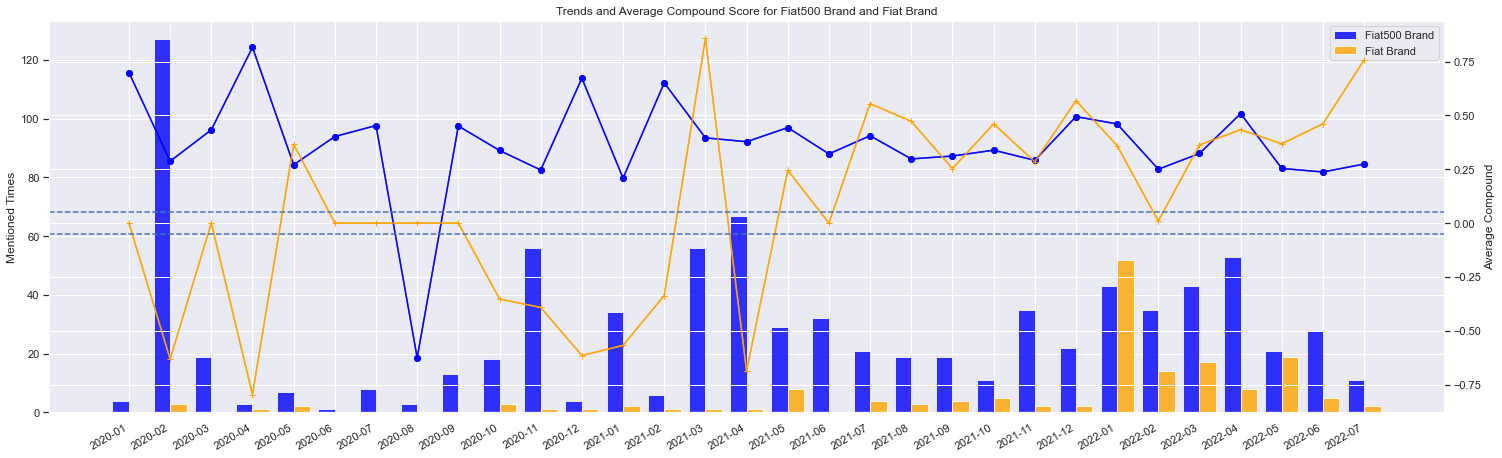

In [823]:
# Import Library
import matplotlib.pyplot as plt
# Plot Mentioned Counts
fig = plt.figure(figsize = (25,8))
ax = fig.add_subplot(111)

label = ['Fiat500 Brand','Fiat Brand']
colors = ['blue','orange']
x= np.arange(0,31)

width = 0.40

quarter  = speakEV_brand_compound_df.index


## Add the plot for hybrid
rects1 = ax.bar(x - width/2, speakEV_brand_count_df['Fiat500'], width, label='Fiat500 Brand',color = colors[0],alpha =0.8)
rects2 = ax.bar(x + width/2, speakEV_brand_count_df['Fiat_Brand'], width, label='Fiat Brand',color = colors[1],alpha =0.8)


ax2 = ax.twinx()
for i in range(2):
    ax2.plot(x,speakEV_brand_compound_df['Fiat500_Brand_compound'], marker='o', label = label[i],c=colors[0],alpha =0.8)
    ax2.plot(x,speakEV_brand_compound_df['Fiat_Brand_compound'], marker='+',label = label[i],c=colors[1],alpha =0.8)

# Labelling 
plt.xlabel("Discussion Date")
plt.title("Trends and Average Compound Score for Fiat500 Brand and Fiat Brand")
ax.set_ylabel("Mentioned Times")
ax2.set_ylabel("Average Compound")

# Display
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax2.axhline(0.05, linestyle='--')
ax2.axhline(-0.05, linestyle='--')
plt.xticks(x,quarter)

ax.legend()
fig.autofmt_xdate()
plt.show()

Main Takeaway:
- In general，there is no siginificant differnece between Fiat 500 Brand and Fiat Brand over time. Fiat 500 Brand has a more stable positive sentiment perception compared to Fiat Brand. 

## Topic Modelling - Fiat 500 Brand and Fiat Brand

In [357]:
def clean_word(raw_text):
    text = re.sub("\d[A-Za-z0-9]+"," ",raw_text)
    # Changing the multiple spaces to one
    text = re.sub('\s+',' ', text)
    return text

In [358]:
cleaned_word = [clean_word(comment) for comment in speakEV_brand_full_df['Clean_Corpus']]
speakEV_brand_full_df['Clean_Corpus'] = cleaned_word

In [359]:
# creating a function with relevant preprocessing of comments to choose k topic models using LDA, and finalising
# the one k with the best coherence score
def tm_brand(df,comments,k, Stopwords):
    nlp = en_core_web_lg.load()
    for item in Stopwords:                      
         nlp.vocab[item].is_stop = True

    # # Removing the empty comments
    # for i in len(comments):
    # #         df = df.reset_index(drop = True)
    # comments = [item for item in comments if len(item)>0]

    
    # # Removing the empty comments in combined dataframe
    # df = df.reset_index(drop = True)

    # Tokenising the words in the corpus
    docs_tokens, tmp_tokens = [], []
    for comment in comments:
        tmp_tokens = [
            token.lemma_
            for token in nlp(comment)
            if not token.is_stop and not token.is_punct and not token.like_num
        ]
        docs_tokens.append(tmp_tokens)
        tmp_tokens = []

    bigram = Phrases(                              
        docs_tokens,
        min_count=30,    # Minimum number of appaerences in the corpus (probably 20 for small texts)
        threshold=10,     # Represent a score threshold for forming the phrases (higher means fewer phrases)
        max_vocab_size=50000,
        
    )
    trigram = Phrases(                           
        bigram[docs_tokens],
        min_count=30,
        threshold=10,
        max_vocab_size=50000,
        
    )

    # Creating the new documents with the bigrams and trigrams
    docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
    
    # contains the drop index
    drop_index = []
    for index in range(0,len(docs_phrased)):
        if len(docs_phrased[index]) == 0:
            drop_index.append(index)

    # Initialising a new corpus
    corpus = tp.utils.Corpus()
    # populate the corpus
    for item in docs_phrased:
        corpus.add_doc(words=item)

    
    cvs = {}                                     # Create the dictionary for the coherence scores per topic
    for topic_number in range(1, k+1, 1):        # Try different topic numbers
        mdl = tp.LDAModel(k=topic_number, corpus=corpus, seed=257)
        for i in range(0, 1000, 10):
            mdl.train(10)
            print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
        coh = tp.coherence.Coherence(mdl, coherence="u_mass")
        cvs[topic_number] = coh.get_score()

    fig = plt.figure(figsize=(25, 8))
    ax = fig.add_subplot(111)
    ax.plot(cvs.keys(), cvs.values(), "o-")
    ax.set_xlabel("Number of topics retained")
    ax.set_ylabel("Coherence score")
    ax.set_xticks(range(1,k+1,1))
    plt.show()
    
    topic_size=min(cvs, key=cvs.get) # Topic Size is the best number of topics
    best_mdl = tp.LDAModel(k=topic_size, corpus=corpus, seed=257) # Create the final model with the optimal number of topics
    
    return (cvs, corpus, best_mdl, topic_size, docs_phrased,drop_index)


In [360]:
speakEV_Stopwords_brand =  ['ll','d','m','ve','etc','e','www','speakev','car','vehicle','uk','fiat','500e','isn','vw','mini','zoe','bmw','corsa','leaf','tesla','nissan','bev','evs','ev','e208','panda',
                'etc','model','new','vauxhall','peugeote','peugeot','renault','honda','mercedes','volkswagen','volvo','i3','hyundai','ioniq','ev6','kia'
                'kona','want','use','niro','co','lot','mg','zs','ford','kia','hi','s','let','try','yes','ok','id3','don','com','kona','forum','think','feel','bit','se','t','non','people','year','kg','km','ask']

# speakEV_Stopwords = ['the','a','to','and','of','i','is','in','for','it','that','you','be','on','you','but','with','have',
#                 'but','hav','are','as''at','car','year','don','d','ve','www','like','need','think','m','didn','oh', 'll','com',
#                 'electric','vehicle','fiat','500e','isn','vw','mini','zoe','bmw','corsa','leaf','tesla','nissan','bev','evs','ev','e208','panda',
#                 'etc','model','new','vauxhall','peugeote','peugeot','renault','honda','mercedes','volkswagen','volvo','i3','hyundai','ioniq','ev6','kia'
#                 'kona','want','use','niro','co','lot','mg','zs','ford','kia','mm','kw','10k','km','5dr','r135','100kw','ac','s','t','e','o','ll','didn','doesn','aren','g','thread','forum']

In [400]:
topic_model_brand = speakEV_brand_full_df.copy()
topic_model_brand = topic_model_brand.reset_index(drop=True)
topic_model_brand

,UserID,Username,Link of user profile,Num of posts per user,Thread_Title,Comment,Discussion Date,column_name,Fiat500e,Fiat500hybrid,...,Fiat_Brand,date,month_year,Clean_Corpus,Sentiment_corpus,neg,neu,pos,compound,sentiment
0,101047,Cheshirecat,https://www.speakev.com/members/cheshirecat.10...,"1,539",fiat- all electrified,\nseems fiat have announced that they will sto...,"May 30, 2022",\nseems fiat have announced that they will sto...,0.0,0.0,...,1.0,2022-05-30,2022-05,fiat announce stop sell non electrify car soon...,fiat announce stop sell non electrify car soon...,0.105,0.766,0.129,0.1280,pos
1,8167,jmacneil,https://www.speakev.com/members/jmacneil.8167/,"2,377",fiat- all electrified,"\n""electrified"" is a little... misleading? in ...","May 30, 2022","\n""electrified"" is a little... misleading? in ...",0.0,0.0,...,1.0,2022-05-30,2022-05,electrify little misleading context g mhd mode...,electrify little misleading context g mhd mode...,0.060,0.819,0.122,0.4215,pos
2,8167,jmacneil,https://www.speakev.com/members/jmacneil.8167/,"2,377",fiat- all electrified,\npersonally i'm pretty keen for a bev version...,"May 30, 2022",\npersonally i'm pretty keen for a bev version...,0.0,0.0,...,1.0,2022-05-30,2022-05,personally m pretty keen bev version panda sus...,personally m pretty keen bev version panda ...,0.082,0.732,0.186,0.3716,pos
3,75630,BornAgainEcoWarrior,https://www.speakev.com/members/bornagainecowa...,"3,931",fiat to go fully electric from july....(not),\nlots of reports that fiat will go full elect...,"May 31, 2022",\nlots of reports that fiat will go full elect...,0.0,0.0,...,1.0,2022-05-31,2022-05,lot report fiat electric july mean hybrid mild...,lot report fiat electric july mean hybrid mild...,0.040,0.936,0.024,-0.2732,neg
4,84596,ChrisCross123,https://www.speakev.com/members/chriscross123....,"2,382",fiat to go fully electric from july....(not),'electrification' seems to be the new 'self ch...,"May 31, 2022",'electrification' seems to be the new 'self ch...,0.0,0.0,...,1.0,2022-05-31,2022-05,electrification new self charge ford website a...,electrification new self charge ford website a...,0.000,1.000,0.000,0.0000,neu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,70762,GavJ,https://www.speakev.com/members/gavj.70762/,89,tesla remotely disables 80 miles of range from...,well the lesson to be learned is be careful of...,"Jul 30, 2022",well the lesson to be learned is be careful of...,0.0,1.0,...,0.0,2022-07-30,2022-07,lesson learn careful scammer rebadge model sel...,lesson learn careful scammer rebadge model sel...,0.067,0.812,0.121,0.2500,pos
1005,98703,Mkultra,https://www.speakev.com/members/mkultra.98703/,558,tesla remotely disables 80 miles of range from...,nevertheless it's part of the new trading cond...,"Jul 31, 2022",nevertheless it's part of the new trading cond...,1.0,1.0,...,0.0,2022-07-31,2022-07,new trading condition affect new ish product m...,new trading condition affect new ish product m...,0.011,0.895,0.095,0.9052,pos
1006,98703,Mkultra,https://www.speakev.com/members/mkultra.98703/,558,tesla remotely disables 80 miles of range from...,sure the article makes that clear but again is...,"Jul 31, 2022",sure the article makes that clear but again is...,1.0,1.0,...,0.0,2022-07-31,2022-07,sure article make clear point good think recei...,sure article clear point good think receive ro...,0.032,0.810,0.158,0.9181,pos
1007,41433,freddym,https://www.speakev.com/members/freddym.41433/,"9,360",fisker ocean,do we need 500bhp for cars licensed to drive o...,"May 4, 2022",do we need 500bhp for cars licensed to drive o...,0.0,1.0,...,0.0,2022-05-04,2022-05,need car license drive public road tyre,need car license drive public road tyre,0.000,1.000,0.000,0.0000,neu


Iteration: 0	Log-likelihood: -8.10302478193266
Iteration: 10	Log-likelihood: -8.10302478193266
Iteration: 20	Log-likelihood: -8.10302478193266
Iteration: 30	Log-likelihood: -8.10302478193266
Iteration: 40	Log-likelihood: -8.10302478193266
Iteration: 50	Log-likelihood: -8.10302478193266
Iteration: 60	Log-likelihood: -8.10302478193266
Iteration: 70	Log-likelihood: -8.10302478193266
Iteration: 80	Log-likelihood: -8.10302478193266
Iteration: 90	Log-likelihood: -8.10302478193266
Iteration: 100	Log-likelihood: -8.10302478193266
Iteration: 110	Log-likelihood: -8.10302478193266
Iteration: 120	Log-likelihood: -8.10302478193266
Iteration: 130	Log-likelihood: -8.10302478193266
Iteration: 140	Log-likelihood: -8.10302478193266
Iteration: 150	Log-likelihood: -8.10302478193266
Iteration: 160	Log-likelihood: -8.10302478193266
Iteration: 170	Log-likelihood: -8.10302478193266
Iteration: 180	Log-likelihood: -8.10302478193266
Iteration: 190	Log-likelihood: -8.10302478193266
Iteration: 200	Log-likelihood: 

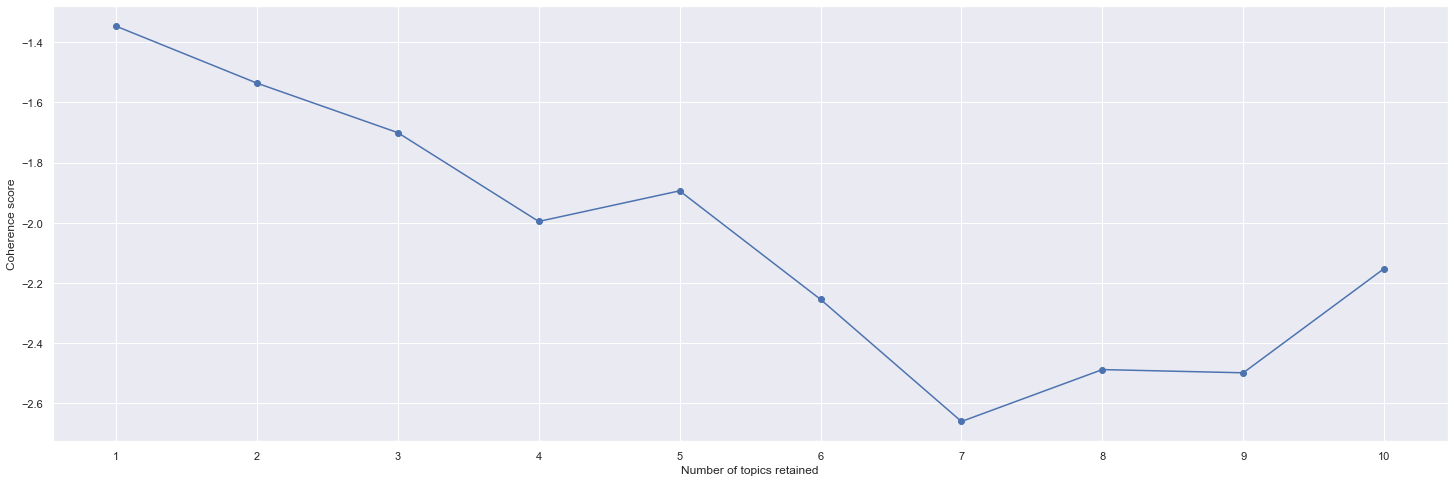

In [401]:
## Training LDAs to choose the best topic size
speakEV_cvs_brand, speakEV_corpus_brand, speakEV_best_mdl_brand, speakEV_topic_size_brand, speakEV_docs_phrased_brand,drop_index_brand = tm_combined(df= speakEV_brand_full_df, comments= speakEV_brand_full_df['Clean_Corpus'],k=10, Stopwords = speakEV_Stopwords_brand)

In [402]:
speakEV_best_mdl_trained_brand = train_tm(speakEV_best_mdl_brand)

Iteration: 0	Log-likelihood: -8.642941768362922
Iteration: 4	Log-likelihood: -8.445802074817301
Iteration: 8	Log-likelihood: -8.356678474405006
Iteration: 12	Log-likelihood: -8.289588430001334
Iteration: 16	Log-likelihood: -8.247873665949543
Iteration: 20	Log-likelihood: -8.22626060715819
Iteration: 24	Log-likelihood: -8.22182055763551
Iteration: 28	Log-likelihood: -8.214937334988193
Iteration: 32	Log-likelihood: -8.196685173963399
Iteration: 36	Log-likelihood: -8.193638829552611
Iteration: 40	Log-likelihood: -8.17715722221572
Iteration: 44	Log-likelihood: -8.178858680183806
Iteration: 48	Log-likelihood: -8.181806272060427
Iteration: 52	Log-likelihood: -8.168379390480949
Iteration: 56	Log-likelihood: -8.16847046416086
Iteration: 60	Log-likelihood: -8.17431584366221
Iteration: 64	Log-likelihood: -8.16032978861279
Iteration: 68	Log-likelihood: -8.169184070520913
Iteration: 72	Log-likelihood: -8.165150175833498
Iteration: 76	Log-likelihood: -8.156590468384678
Iteration: 80	Log-likelihood:

In [403]:
# Topic to word probabilities to understand words with the highest probabilities to occur in a topic and then
# to perhaps go back and include those words in custom stopwords in the LDA code
speakEV_wt_brand = pd.DataFrame()
for k in range(speakEV_best_mdl_trained_brand.k):
    words, probs = [], []
    for word, prob in speakEV_best_mdl_brand.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    speakEV_wt_brand = pd.concat([speakEV_wt_brand, tmp], ignore_index=False)
    del tmp

In [404]:
speakEV_wt_brand.sort_values('prob', ascending=False).head(10)

,word,prob,k,sort
0,charge,0.053,1,0
0,electric,0.050,0,0
0,range,0.047,6,0
1,battery,0.046,1,1
0,price,0.042,2,0
0,cost,0.038,3,0
1,drive,0.033,6,1
0,like,0.033,5,0
1,look,0.032,5,1
1,grant,0.030,2,1


In [405]:
# Dataframe withe final topics
topics_speakEV_brand = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in speakEV_best_mdl_brand.docs]),
    columns=["Topic {}".format(i + 1) for i in range(speakEV_best_mdl_brand.k)])
topics_speakEV_brand

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,0.373994,0.145240,0.082064,0.073179,0.216628,0.057168,0.051726
1,0.284070,0.077279,0.086203,0.081475,0.072724,0.200572,0.197676
2,0.134150,0.065292,0.162012,0.153127,0.056732,0.297012,0.131674
3,0.587260,0.024373,0.060477,0.087004,0.110708,0.051184,0.078996
4,0.283373,0.110048,0.183332,0.055447,0.224714,0.043316,0.099769
...,...,...,...,...,...,...,...
998,0.414843,0.044126,0.055461,0.157516,0.038341,0.254756,0.034958
999,0.359566,0.101145,0.070016,0.085472,0.099284,0.099378,0.185139
1000,0.157099,0.089787,0.282922,0.092108,0.087268,0.040347,0.250470
1001,0.058912,0.331651,0.089195,0.079538,0.061662,0.062136,0.316906


In [406]:
# inspecting topic themes as a dataframe just out of curiosity.
speakEV_values_brand = {}
for k in range(speakEV_best_mdl_brand.k):
    speakEV_values_brand['Topic {}'.format(k+1)]= [("{},({})".format(word, str(np.round(prob, 3)))) for word, prob in speakEV_best_mdl_brand.get_topic_words(k)]
    # print the table
    #return (table)
speakEV_table_brand = pd.DataFrame(speakEV_values_brand)  
speakEV_table_brand

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,"electric,(0.05)","charge,(0.053)","price,(0.042)","cost,(0.038)","issue,(0.02)","like,(0.033)","range,(0.047)"
1,"sell,(0.026)","battery,(0.046)","grant,(0.03)","mile,(0.029)","dealer,(0.014)","look,(0.032)","drive,(0.033)"
2,"market,(0.016)","time,(0.025)","month,(0.028)","cheap,(0.021)","van,(0.013)","small,(0.02)","mile,(0.029)"
3,"manufacturer,(0.015)","need,(0.025)","lease,(0.022)","work,(0.02)","thank,(0.013)","thing,(0.018)","good,(0.02)"
4,"sale,(0.015)","charger,(0.018)","good,(0.021)","need,(0.019)","work,(0.011)","big,(0.015)","speed,(0.013)"
5,"government,(0.014)","long,(0.014)","order,(0.017)","ice,(0.018)","service,(0.01)","current,(0.014)","like,(0.012)"
6,"company,(0.011)","trip,(0.013)","look,(0.015)","buy,(0.017)","close,(0.009)","wife,(0.013)","actually,(0.009)"
7,"mean,(0.011)","week,(0.012)","pay,(0.015)","old,(0.017)","idea,(0.009)","love,(0.013)","power,(0.009)"
8,"high,(0.01)","point,(0.011)","option,(0.015)","low,(0.015)","post,(0.009)","seat,(0.013)","wheel,(0.009)"
9,"away,(0.01)","kwh,(0.011)","know,(0.013)","drive,(0.013)","different,(0.008)","brand,(0.01)","engine,(0.009)"


In [451]:
speakEV_table_brand_label = speakEV_table_brand.copy()
topic_labels_brand = ['Government Annoucement on EV Sales Market','Charge Time, Charge Point','Price and Grant Promotion','Car expenses',
'Dealer service','Design and Configuration','Range Mile, Engine Power']
speakEV_table_brand_label.columns = topic_labels_brand
speakEV_table_brand_label

,Government Annoucement on EV Sales Market,"Charge Time, Charge Point",Price and Grant Promotion,Car expenses,Dealer service,Design and Configuration,"Range Mile, Engine Power"
0,"electric,(0.05)","charge,(0.053)","price,(0.042)","cost,(0.038)","issue,(0.02)","like,(0.033)","range,(0.047)"
1,"sell,(0.026)","battery,(0.046)","grant,(0.03)","mile,(0.029)","dealer,(0.014)","look,(0.032)","drive,(0.033)"
2,"market,(0.016)","time,(0.025)","month,(0.028)","cheap,(0.021)","van,(0.013)","small,(0.02)","mile,(0.029)"
3,"manufacturer,(0.015)","need,(0.025)","lease,(0.022)","work,(0.02)","thank,(0.013)","thing,(0.018)","good,(0.02)"
4,"sale,(0.015)","charger,(0.018)","good,(0.021)","need,(0.019)","work,(0.011)","big,(0.015)","speed,(0.013)"
5,"government,(0.014)","long,(0.014)","order,(0.017)","ice,(0.018)","service,(0.01)","current,(0.014)","like,(0.012)"
6,"company,(0.011)","trip,(0.013)","look,(0.015)","buy,(0.017)","close,(0.009)","wife,(0.013)","actually,(0.009)"
7,"mean,(0.011)","week,(0.012)","pay,(0.015)","old,(0.017)","idea,(0.009)","love,(0.013)","power,(0.009)"
8,"high,(0.01)","point,(0.011)","option,(0.015)","low,(0.015)","post,(0.009)","seat,(0.013)","wheel,(0.009)"
9,"away,(0.01)","kwh,(0.011)","know,(0.013)","drive,(0.013)","different,(0.008)","brand,(0.01)","engine,(0.009)"


In [407]:
topic_larger_brand = topics_speakEV_brand.apply(lambda row: row.nlargest(2),axis=1)
topic_larger_brand = topic_larger_brand.div(topic_larger_brand.sum(axis=1), axis=0)
topic_larger_brand = topic_larger_brand.replace(np.nan,0)
topic_larger_brand

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,0.633220,0.000000,0.00000,0.0,0.366780,0.000000,0.000000
1,0.586145,0.000000,0.00000,0.0,0.000000,0.413855,0.000000
2,0.000000,0.000000,0.35295,0.0,0.000000,0.647050,0.000000
3,0.841385,0.000000,0.00000,0.0,0.158615,0.000000,0.000000
4,0.557725,0.000000,0.00000,0.0,0.442275,0.000000,0.000000
...,...,...,...,...,...,...,...
998,0.619539,0.000000,0.00000,0.0,0.000000,0.380461,0.000000
999,0.660111,0.000000,0.00000,0.0,0.000000,0.000000,0.339889
1000,0.000000,0.000000,0.53042,0.0,0.000000,0.000000,0.469580
1001,0.000000,0.511367,0.00000,0.0,0.000000,0.000000,0.488633


In [408]:
# find the top 2 main topics
g = topic_larger_brand.filter(like='Topic')
topic_larger_brand['Main_topic1'] = g.idxmax(axis=1)
topic_larger_brand['Main_topic2'] = g.mask(g.eq(g.max(axis=1), axis=0) & g.apply(lambda x: ~x.duplicated(), axis=1)).idxmax(axis=1)
topic_larger_brand

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Main_topic1,Main_topic2
0,0.633220,0.000000,0.00000,0.0,0.366780,0.000000,0.000000,Topic 1,Topic 5
1,0.586145,0.000000,0.00000,0.0,0.000000,0.413855,0.000000,Topic 1,Topic 6
2,0.000000,0.000000,0.35295,0.0,0.000000,0.647050,0.000000,Topic 6,Topic 3
3,0.841385,0.000000,0.00000,0.0,0.158615,0.000000,0.000000,Topic 1,Topic 5
4,0.557725,0.000000,0.00000,0.0,0.442275,0.000000,0.000000,Topic 1,Topic 5
...,...,...,...,...,...,...,...,...,...
998,0.619539,0.000000,0.00000,0.0,0.000000,0.380461,0.000000,Topic 1,Topic 6
999,0.660111,0.000000,0.00000,0.0,0.000000,0.000000,0.339889,Topic 1,Topic 7
1000,0.000000,0.000000,0.53042,0.0,0.000000,0.000000,0.469580,Topic 3,Topic 7
1001,0.000000,0.511367,0.00000,0.0,0.000000,0.000000,0.488633,Topic 2,Topic 7


In [409]:
prepared_data= topic_plot_data(speakEV_best_mdl_brand)
pyLDAvis.display(prepared_data)

Topic Modelling for Brand:
- Topic 0: Government Annoucement on EV Sales Market
- Topic 1: Charge Time, Charge Point
- Topic 2: Price and Grant PRomotion
- Topic 3: Car expenses
- Topic 4: Dealer service
- Topic 5: Design and Configuration
- Topic 6: Range Mile, Engine Power

## Combination - Brand

In [410]:
# Create the corpus for sentiment analysis
corpus_sentiment_brand = [cleaning_text_sentiment_speakEV(comment) for comment in topic_model_brand['Clean_Corpus']]
topic_model_brand.loc[:,'Sentiment_corpus'] =  corpus_sentiment_brand

In [411]:
topic_model_brand = topic_model_brand.drop(drop_index_brand)
topic_model_brand = topic_model_brand.reset_index(drop = True)
topic_model_brand

,UserID,Username,Link of user profile,Num of posts per user,Thread_Title,Comment,Discussion Date,column_name,Fiat500e,Fiat500hybrid,...,Fiat_Brand,date,month_year,Clean_Corpus,Sentiment_corpus,neg,neu,pos,compound,sentiment
0,101047,Cheshirecat,https://www.speakev.com/members/cheshirecat.10...,"1,539",fiat- all electrified,\nseems fiat have announced that they will sto...,"May 30, 2022",\nseems fiat have announced that they will sto...,0.0,0.0,...,1.0,2022-05-30,2022-05,fiat announce stop sell non electrify car soon...,fiat announce stop sell non electrify car soon...,0.105,0.766,0.129,0.1280,pos
1,8167,jmacneil,https://www.speakev.com/members/jmacneil.8167/,"2,377",fiat- all electrified,"\n""electrified"" is a little... misleading? in ...","May 30, 2022","\n""electrified"" is a little... misleading? in ...",0.0,0.0,...,1.0,2022-05-30,2022-05,electrify little misleading context g mhd mode...,electrify little misleading context g mhd mode...,0.060,0.819,0.122,0.4215,pos
2,8167,jmacneil,https://www.speakev.com/members/jmacneil.8167/,"2,377",fiat- all electrified,\npersonally i'm pretty keen for a bev version...,"May 30, 2022",\npersonally i'm pretty keen for a bev version...,0.0,0.0,...,1.0,2022-05-30,2022-05,personally m pretty keen bev version panda sus...,personally m pretty keen bev version panda sus...,0.082,0.732,0.186,0.3716,pos
3,75630,BornAgainEcoWarrior,https://www.speakev.com/members/bornagainecowa...,"3,931",fiat to go fully electric from july....(not),\nlots of reports that fiat will go full elect...,"May 31, 2022",\nlots of reports that fiat will go full elect...,0.0,0.0,...,1.0,2022-05-31,2022-05,lot report fiat electric july mean hybrid mild...,lot report fiat electric july mean hybrid mild...,0.040,0.936,0.024,-0.2732,neg
4,84596,ChrisCross123,https://www.speakev.com/members/chriscross123....,"2,382",fiat to go fully electric from july....(not),'electrification' seems to be the new 'self ch...,"May 31, 2022",'electrification' seems to be the new 'self ch...,0.0,0.0,...,1.0,2022-05-31,2022-05,electrification new self charge ford website a...,electrification new self charge ford website a...,0.000,1.000,0.000,0.0000,neu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,70762,GavJ,https://www.speakev.com/members/gavj.70762/,89,tesla remotely disables 80 miles of range from...,well the lesson to be learned is be careful of...,"Jul 30, 2022",well the lesson to be learned is be careful of...,0.0,1.0,...,0.0,2022-07-30,2022-07,lesson learn careful scammer rebadge model sel...,lesson learn careful scammer rebadge model sel...,0.067,0.812,0.121,0.2500,pos
999,98703,Mkultra,https://www.speakev.com/members/mkultra.98703/,558,tesla remotely disables 80 miles of range from...,nevertheless it's part of the new trading cond...,"Jul 31, 2022",nevertheless it's part of the new trading cond...,1.0,1.0,...,0.0,2022-07-31,2022-07,new trading condition affect new ish product m...,new trading condition affect new ish product m...,0.011,0.895,0.095,0.9052,pos
1000,98703,Mkultra,https://www.speakev.com/members/mkultra.98703/,558,tesla remotely disables 80 miles of range from...,sure the article makes that clear but again is...,"Jul 31, 2022",sure the article makes that clear but again is...,1.0,1.0,...,0.0,2022-07-31,2022-07,sure article make clear point good think recei...,sure article clear point good think receive ro...,0.032,0.810,0.158,0.9181,pos
1001,41433,freddym,https://www.speakev.com/members/freddym.41433/,"9,360",fisker ocean,do we need 500bhp for cars licensed to drive o...,"May 4, 2022",do we need 500bhp for cars licensed to drive o...,0.0,1.0,...,0.0,2022-05-04,2022-05,need car license drive public road tyre,need car license drive public road tyre,0.000,1.000,0.000,0.0000,neu


In [412]:
topic_larger_brand['compound'] = topic_model_brand['compound']
topic_larger_brand['sentiment'] = topic_model_brand['sentiment']
topic_larger_brand['Fiat_Brand'] = topic_model_brand['Fiat_Brand']
topic_larger_brand['Fiat500'] = topic_model_brand['Fiat500']
topic_larger_brand['Comment'] = topic_model_brand['Comment']

In [413]:
# seperate the subset Fiat500e & Fiat 500hybrid
topic_senti_fiat500 = topic_larger_brand.loc[(topic_larger_brand['Fiat500']  == 1) & (topic_larger_brand['Fiat_Brand']  != 1) ]
topic_senti_fiat500 = topic_senti_fiat500.reset_index(drop = True)
print('Number of comments related to Fiat 500 Brand: {}'.format(topic_senti_fiat500.shape[0]))

topic_senti_fiat = topic_larger_brand.loc[(topic_larger_brand['Fiat500']  != 1) & (topic_larger_brand['Fiat_Brand']  == 1) ]
topic_senti_fiat = topic_senti_fiat.reset_index(drop = True)
print('Number of comments related to Fiat Brand: {}'.format(topic_senti_fiat.shape[0]))

Number of comments related to Fiat 500 Brand: 842
Number of comments related to Fiat Brand: 161


In [414]:
from numpy import average
def weighted_avg(df,topics):
    weighted_avg_sentiment=[]
    for i in topic_larger_brand.columns.values[0:k+1]:
        weighted_avg_topic= round(average(df['compound'], weights = df[i]),2)
        weighted_avg_sentiment.append(weighted_avg_topic)
    return weighted_avg_sentiment

In [415]:
weighted_avg_senti_brand = weighted_avg(df = topic_larger_brand,topics=k)
print('The weighted average compound for topics of total fiat brand subset is:\n {}'.format(weighted_avg_senti_brand))
print('------------------------------------')
print('------------------------------------')

weighted_avg_senti_fiat500brand = weighted_avg(df = topic_senti_fiat500,topics=k)
print('The weighted average compound for topics of Fiat 500 Brand is:{}'.format(weighted_avg_senti_fiat500brand))
print('------------------------------------')
print('------------------------------------')

weighted_avg_senti_fiatbrand = weighted_avg(df = topic_senti_fiat,topics=k)
print('The weighted average compound for topics of Fiat Brand is:{}'.format(weighted_avg_senti_fiatbrand))

The weighted average compound for topics of total fiat brand subset is:
 [0.32, 0.28, 0.36, 0.35, 0.28, 0.33, 0.43]
------------------------------------
------------------------------------
The weighted average compound for topics of Fiat 500 Brand is:[0.35, 0.3, 0.37, 0.37, 0.28, 0.32, 0.46]
------------------------------------
------------------------------------
The weighted average compound for topics of Fiat Brand is:[0.16, 0.15, 0.27, 0.23, 0.26, 0.38, 0.37]


In [416]:
topics_prob_brand = topic_larger_brand[list(topic_larger_brand.columns.values)[:-5]].mean()
print('the mean probabilities for topics of combined subset is:\n{}'.format(topics_prob_brand))
print('------------------------------------')
print('------------------------------------')

topics_prob_fiat500brand = topic_larger_brand[list(topic_senti_fiat500.columns.values)[:-5]].mean()
print('the mean probabilities for topics of fiat500e subset is:\n{}'.format(topics_prob_fiat500brand))
print('------------------------------------')
print('------------------------------------')

topics_prob_fiatbrand = topic_larger_brand[list(topic_senti_fiat.columns.values)[:-5]].mean()
print('the mean probabilities for topics of fiat500hybrid subset is:\n{}'.format(topics_prob_fiatbrand))

the mean probabilities for topics of combined subset is:
Topic 1    0.098360
Topic 2    0.151463
Topic 3    0.243059
Topic 4    0.166284
Topic 5    0.122391
Topic 6    0.114732
Topic 7    0.103711
dtype: float64
------------------------------------
------------------------------------
the mean probabilities for topics of fiat500e subset is:
Topic 1    0.098360
Topic 2    0.151463
Topic 3    0.243059
Topic 4    0.166284
Topic 5    0.122391
Topic 6    0.114732
Topic 7    0.103711
dtype: float64
------------------------------------
------------------------------------
the mean probabilities for topics of fiat500hybrid subset is:
Topic 1    0.098360
Topic 2    0.151463
Topic 3    0.243059
Topic 4    0.166284
Topic 5    0.122391
Topic 6    0.114732
Topic 7    0.103711
dtype: float64


In [417]:
# show the dataframe combine the result
topic_senti_brand = pd.DataFrame()

topic_senti_brand['Prob_brand'] =  topics_prob_brand
topic_senti_brand['WeightedSenti_brand'] = weighted_avg_senti_brand

topic_senti_brand = sentiment_topic(topic_senti_brand,topic_larger_brand)
topic_senti_brand['brand_pos_percentage'] = (topic_senti_brand.iloc[:,2]/(topic_senti_brand.iloc[:, 2:5].sum(axis=1))).round(2)

topic_senti_brand['Prob_fiat500brand'] =  topics_prob_fiat500brand
topic_senti_brand['WeightedSenti_fiat500brand'] = weighted_avg_senti_fiat500brand
topic_senti_brand = sentiment_topic(topic_senti_brand,topic_senti_fiat500)
topic_senti_brand['fiat500brand_pos_percentage'] = (topic_senti_brand.iloc[:,8]/(topic_senti_brand.iloc[:, 8:11].sum(axis=1))).round(2)

topic_senti_brand['Prob_fiatbrand'] =  topics_prob_fiatbrand
topic_senti_brand['WeightedSenti_fiatbrand'] = weighted_avg_senti_fiatbrand
topic_senti_brand = sentiment_topic(topic_senti_brand,topic_senti_fiat)
topic_senti_brand['fiatbrand_pos_percentage'] = (topic_senti_brand.iloc[:,14]/(topic_senti_brand.iloc[:, 14:17].sum(axis=1))).round(2)
topic_senti_brand

,Prob_brand,WeightedSenti_brand,pos,neg,neu,brand_pos_percentage,Prob_fiat500brand,WeightedSenti_fiat500brand,pos,neg,neu,fiat500brand_pos_percentage,Prob_fiatbrand,WeightedSenti_fiatbrand,pos,neg,neu,fiatbrand_pos_percentage
Topic 1,0.098360,0.32,70,15,12,0.72,0.098360,0.35,59,12,9,0.74,0.098360,0.16,11.0,3.0,3.0,0.65
Topic 2,0.151463,0.28,93,42,17,0.61,0.151463,0.30,80,33,17,0.62,0.151463,0.15,13.0,9.0,0.0,0.59
Topic 3,0.243059,0.36,188,39,40,0.70,0.243059,0.37,176,38,38,0.70,0.243059,0.27,12.0,1.0,2.0,0.80
Topic 4,0.166284,0.35,102,39,12,0.67,0.166284,0.37,90,29,12,0.69,0.166284,0.23,12.0,10.0,0.0,0.55
Topic 5,0.122391,0.28,71,28,19,0.60,0.122391,0.28,62,21,15,0.63,0.122391,0.26,9.0,7.0,4.0,0.45
Topic 6,0.114732,0.33,81,23,7,0.73,0.114732,0.32,54,16,7,0.70,0.114732,0.38,27.0,7.0,0.0,0.79
Topic 7,0.103711,0.43,75,17,13,0.71,0.103711,0.46,56,9,9,0.76,0.103711,0.37,19.0,8.0,4.0,0.61


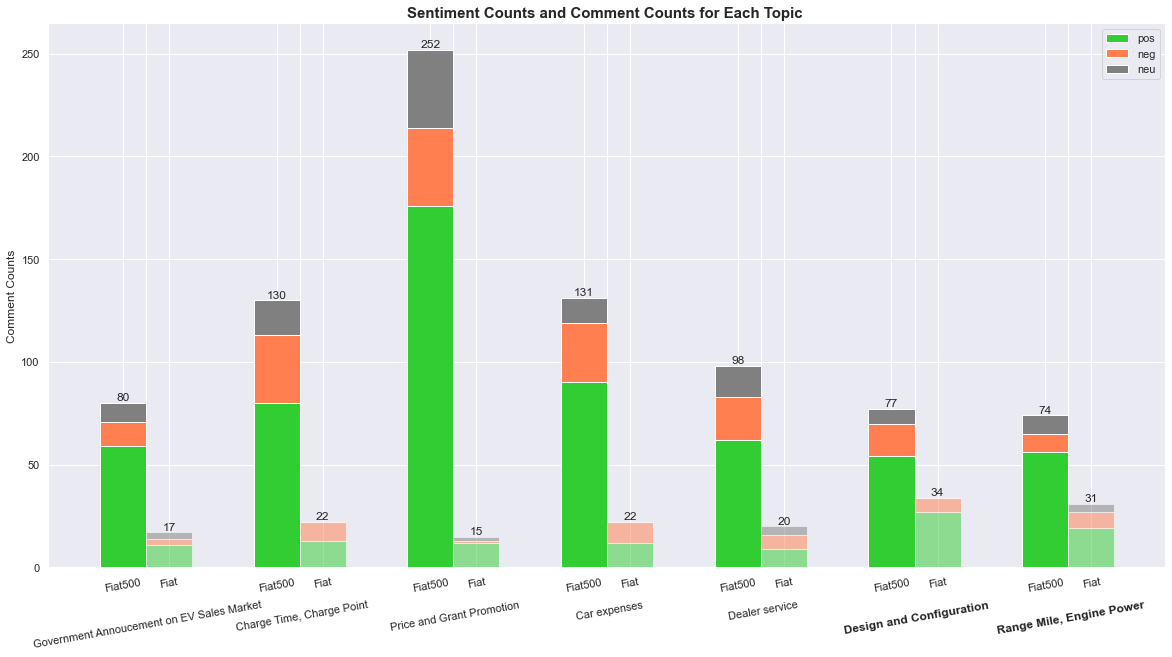

In [564]:
# def topics_sentiment_stack(df, column_name1, column_name2):

import xxlimited

topic_labels = ['Government Annoucement on EV Sales Market','Charge Time, Charge Point','Price and Grant Promotion','Car expenses',
'Dealer service','Design and Configuration','Range Mile, Engine Power']

sentiment_labels = ['pos','neg','neu']
colors = ["limegreen","coral","grey"]
width =0.30

# x_pos = np.arange(0,18)
# x = np.arange(topic_senti_combined.shape[0])  # the label location

x = list()
ind = np.arange(7)
# x labels position: i = 1st bar, i+w/2 = category, i+w = 2nd bar
for i in ind:
    x.extend([i, i+width/2., i+width])  

# sns.set_style("whitegrid")
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)

# temp_combined = topic_senti_brand.iloc[:,2:5]
temp_fiat500 = topic_senti_brand.iloc[:,8:11]
temp_fiat  = topic_senti_brand.iloc[:,14:17]

# fiat500
ax.bar(ind, temp_fiat500[sentiment_labels[0]], width,  label = sentiment_labels[0], color = colors[0],alpha = 1)
ax.bar(ind, temp_fiat500[sentiment_labels[1]], width,   label = sentiment_labels[1], color = colors[1],bottom= temp_fiat500[sentiment_labels[0]] ,alpha = 1)
ax.bar(ind, temp_fiat500[sentiment_labels[2]], width,   label = sentiment_labels[2], color = colors[2],bottom= temp_fiat500[sentiment_labels[0]] + temp_fiat500[sentiment_labels[1]],alpha =1 )

fiat500_count = topic_senti_brand.iloc[:, 8:11].sum(axis=1)
fiat_count =  topic_senti_brand.iloc[:, 14:17].sum(axis=1)

for a, b in zip(ind, fiat500_count):   
    plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=12)
for a, b in zip(ind+width, fiat_count):   
    plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=12)

# fiat
ax.bar(ind+width, temp_fiat[sentiment_labels[0]], width,  color = colors[0],alpha = 0.5)
ax.bar(ind+width, temp_fiat[sentiment_labels[1]], width,  color = colors[1],bottom=  temp_fiat[sentiment_labels[0]] , alpha = 0.5)
ax.bar(ind+width, temp_fiat[sentiment_labels[2]], width,  color = colors[2],bottom=  temp_fiat[sentiment_labels[0]] + temp_fiat[sentiment_labels[1]], alpha = 0.5)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False) 


# Labelling 
# plt.xlabel("Discussion Date")
plt.ylabel("Comment Counts")
plt.xticks(x)

topic_labels = ['Government Annoucement on EV Sales Market','Charge Time, Charge Point','Price and Grant Promotion','Car expenses',
'Dealer service','Design and Configuration','Range Mile, Engine Power']

ax.set_xticklabels(('Fiat500','\n\nGovernment Annoucement on EV Sales Market', 'Fiat', 
                    'Fiat500','\n\nCharge Time, Charge Point', 'Fiat', 
                    'Fiat500','\n\nPrice and Grant Promotion', 'Fiat', 
                    'Fiat500','\n\nCar expenses', 'Fiat', 
                    'Fiat500','\n\nDealer service', 'Fiat', 
                    'Fiat500','\n\nDesign and Configuration', 'Fiat', 
                    'Fiat500','\n\nRange Mile, Engine Power', 'Fiat'),ha='center',rotation = 10)

x_label = ax.get_xticklabels() 
# temp_labels = [x_label[1],x_label[7],x_label[10],x_label[13],x_label[19]]
temp_labels = [x_label[16],x_label[19]]
for label in temp_labels:
    label.set_fontweight('bold') 
    label.set_fontsize(12)


ax.set_title('Sentiment Counts and Comment Counts for Each Topic ',fontdict={'size': 15, 'weight': 700})

plt.legend()


Text(0.5, 1.0, 'Comment Sentiment Percentage for Each Topic')

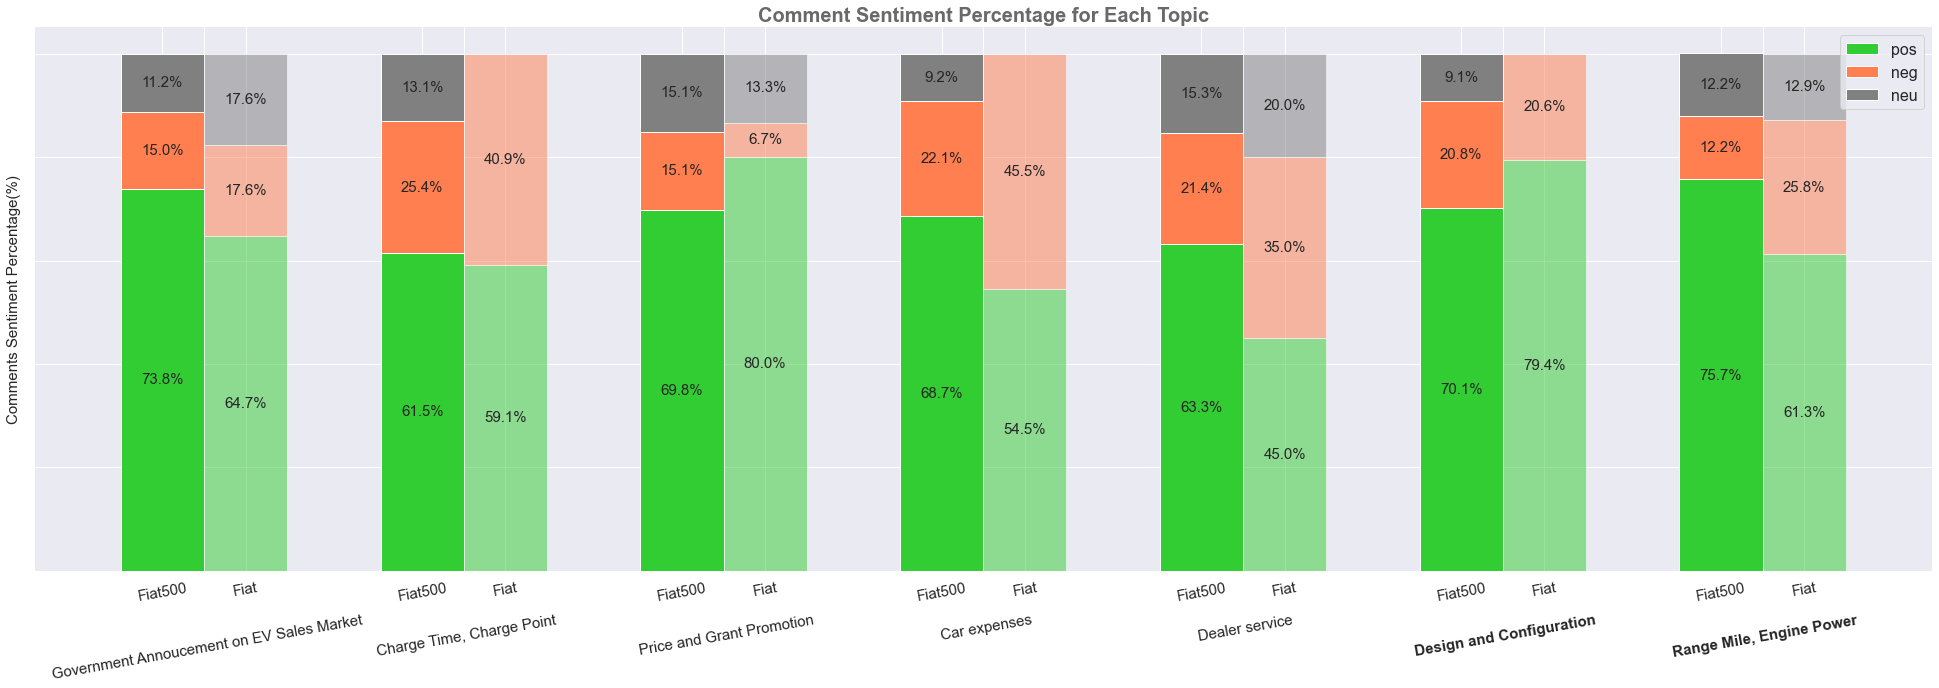

In [499]:
# def topics_sentiment_stack(df, column_name1, column_name2):

import xxlimited

topic_labels = ['Government Annoucement on EV Sales Market','Charge Time, Charge Point','Price and Grant Promotion','Car expenses',
'Dealer service','Design and Configuration','Range Mile, Engine Power']


sentiment_labels = ['pos','neg','neu']
colors = ["limegreen","coral","grey"]
width =0.32

# x_pos = np.arange(0,18)
# x = np.arange(topic_senti_combined.shape[0])  # the label location

x = list()
ind = np.arange(7)
# x labels position: i = 1st bar, i+w/2 = category, i+w = 2nd bar
for i in ind:
    x.extend([i, i+width/2., i+width])  

# sns.set_style("whitegrid")
fig = plt.figure(figsize=(34, 10))
ax = fig.add_subplot(1, 1, 1)

temp_bev= topic_senti_brand.iloc[:,8:11]
temp_hybrid = topic_senti_brand.iloc[:,14:17]

temp_bev['sum'] = temp_bev['pos']+temp_bev['neu']+temp_bev['neg']
temp_hybrid['sum'] = temp_hybrid['pos']+temp_hybrid['neu']+temp_hybrid['neg']


temp_bev['pos_temp'] = round(temp_bev['pos']/temp_bev['sum']*100, 1)
temp_bev['neg_temp'] = round(temp_bev['neg']/temp_bev['sum']*100, 1)
temp_bev['neu_temp'] = round(temp_bev['neu']/temp_bev['sum']*100, 1)

temp_hybrid['pos_temp'] = round(temp_hybrid['pos']/temp_hybrid['sum']*100, 1)
temp_hybrid['neg_temp'] = round(temp_hybrid['neg']/temp_hybrid['sum']*100, 1)
temp_hybrid['neu_temp'] = round(temp_hybrid['neu']/temp_hybrid['sum']*100, 1)


#bev
ax.bar(ind, temp_bev['pos_temp'], width,  label = sentiment_labels[0], color = colors[0],alpha = 1)
ax.bar(ind, temp_bev['neg_temp'], width,   label = sentiment_labels[1], color = colors[1],bottom= temp_bev['pos_temp'] ,alpha = 1)
ax.bar(ind, temp_bev['neu_temp'], width,   label = sentiment_labels[2], color = colors[2],bottom= temp_bev['pos_temp'] + temp_bev['neg_temp'],alpha =1 )

ax.legend(fontsize = 16)

# hybrid
ax.bar(ind+width, temp_hybrid['pos_temp'], width,  label = sentiment_labels[0], color = colors[0],alpha = 0.5)
ax.bar(ind+width, temp_hybrid['neg_temp'], width,   label = sentiment_labels[1], color = colors[1],bottom= temp_hybrid['pos_temp'] ,alpha = 0.5)
ax.bar(ind+width, temp_hybrid['neu_temp'], width,   label = sentiment_labels[2], color = colors[2],bottom= temp_hybrid['pos_temp'] + temp_hybrid['neg_temp'],alpha = 0.5 )


# text
for a, b in zip(ind, temp_bev['pos_temp']):   
    plt.text(a, b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)
for a, b in zip(ind+width, temp_hybrid['pos_temp']):   
    plt.text(a, b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)

for a, b, c in zip(ind, temp_bev['neg_temp'], temp_bev['pos_temp']):   
    if b!= 0:
        plt.text(a, c+b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)
for a, b, c in zip(ind+width, temp_hybrid['neg_temp'], temp_hybrid['pos_temp']):   
    if b!=0:
        plt.text(a, c+b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)

for a, b, c  in zip(ind, temp_bev['neu_temp'], temp_bev['neg_temp']+temp_bev['pos_temp']):   
    if b!= 0:
        plt.text(a, c+b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)
for a, b, c in zip(ind+width,temp_hybrid['neu_temp'], temp_hybrid['neg_temp']+temp_hybrid['pos_temp']): 
    if b!= 0:  
        plt.text(a, c+b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False) 


# Labelling 
plt.ylabel("Comments Sentiment Percentage(%)", size = 15)
# Ticks
ax.axes.yaxis.set_ticklabels([])

plt.xticks(x)

ax.set_xticklabels(('Fiat500','\n\nGovernment Annoucement on EV Sales Market', 'Fiat', 
                    'Fiat500','\n\nCharge Time, Charge Point', 'Fiat', 
                    'Fiat500','\n\nPrice and Grant Promotion', 'Fiat', 
                    'Fiat500','\n\nCar expenses', 'Fiat', 
                    'Fiat500','\n\nDealer service', 'Fiat', 
                    'Fiat500','\n\nDesign and Configuration', 'Fiat', 
                    'Fiat500','\n\nRange Mile, Engine Power', 'Fiat'),ha='center',rotation = 10,size=15)

x_label = ax.get_xticklabels() 

temp_labels = [x_label[16],x_label[19]]  #,x_label[19],x_label[25]
for label in temp_labels:
    label.set_fontweight('bold') 
    label.set_fontsize(15)
# Title
ax.set_title('Comment Sentiment Percentage for Each Topic', color = 'dimgray', fontdict={'size': 20, 'weight': 700})


In [419]:
# topic_sentiment_timeseries = pd.concat([topic_larger_combined, speakEV_fiat500_combined[['Discussion Date']]],axis=1)
topic_sentiment_timeseries_brand = topic_model_brand.copy()
topic_sentiment_timeseries_brand['Discussion Date'] = pd.to_datetime(topic_sentiment_timeseries_brand['Discussion Date'])
topic_sentiment_timeseries_brand['month_update'] = topic_sentiment_timeseries_brand['Discussion Date'].dt.month
topic_sentiment_timeseries_brand['year_update'] = topic_sentiment_timeseries_brand['Discussion Date'].dt.year
topic_sentiment_timeseries_brand = topic_sentiment_timeseries_brand.loc[topic_sentiment_timeseries_brand['Discussion Date'].between('2020-01-01','2022-07-31', inclusive=True)]

In [420]:
df_time_sentiment = topic_sentiment_timeseries_brand.copy()
for topic in topic_larger_brand.columns[:7].to_list():
    df_time_sentiment.loc[:,topic] = topic_larger_brand[topic] *  topic_larger_brand['compound']

In [421]:
df_time_sentiment['Discussion Date']= pd.to_datetime(df_time_sentiment['Discussion Date'])
df_time_sentiment['month_update'] = df_time_sentiment['Discussion Date'].dt.month
df_time_sentiment['year_update'] = df_time_sentiment['Discussion Date'].dt.year

In [422]:
df_time = pd.DataFrame(df_time_sentiment.groupby(['year_update', 'month_update'], as_index=False)['compound'].aggregate(np.mean))
df_time

,year_update,month_update,compound
0,2020,1,0.699150
1,2020,2,0.266284
2,2020,3,0.432763
3,2020,4,0.413000
4,2020,5,0.291778
5,2020,6,0.401900
6,2020,7,0.452763
7,2020,8,-0.625700
8,2020,9,0.450692
9,2020,10,0.250610


In [423]:
df_time_topic = pd.DataFrame(df_time_sentiment.groupby(['year_update', 'month_update'], as_index=False)['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7'].aggregate(np.mean))
df_time_topic

,year_update,month_update,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,2020,1,0.000000,0.043346,0.201273,0.229781,0.144655,0.080095,0.000000
1,2020,2,0.064819,0.027052,0.108143,0.060901,0.006103,-0.000244,-0.000490
2,2020,3,0.058198,0.051481,0.163845,0.023765,0.059390,0.002917,0.073167
3,2020,4,0.000000,0.000000,0.059947,0.268888,0.061612,0.000000,0.022553
4,2020,5,0.057532,0.066685,0.055780,0.007188,0.017818,0.000000,0.086775
5,2020,6,0.352013,0.000000,0.000000,0.000000,0.000000,0.000000,0.049887
6,2020,7,0.025695,0.234938,0.025820,0.114463,0.000000,0.000000,0.051847
7,2020,8,0.000000,-0.079988,-0.141874,-0.243026,0.000000,-0.160812,0.000000
8,2020,9,0.051382,0.032458,0.225078,-0.010800,0.077088,0.075486,0.000000
9,2020,10,0.008724,0.000364,0.091276,0.060305,0.038750,0.046427,0.004764


In [424]:
df_time.loc[:,'date'] = df_time['month_update'].astype(int).astype(str)+ '-' +df_time['year_update'].astype(int).astype(str)
df_time_topic.loc[:,'date'] = df_time_topic['month_update'].astype(int).astype(str)+ '-' +df_time_topic['year_update'].astype(int).astype(str)

In [425]:
df_time_sentiment['Main_topic1'] = topic_larger_brand['Main_topic1']

In [426]:
topic_labels_brand = ['Government Annoucement on EV Sales Market','Charge Time, Charge Point','Price and Grant Promotion','Car expenses',
'Dealer service','Design and Configuration','Range Mile, Engine Power']

In [828]:
def topics_per_month(df, column_name1, column_name2,topic_labels):
    colors = ["lightblue","green","grey","darkorange","blue","firebrick","limegreen",'salmon','purple','lightcoral']

    width = 20
    df['date'] = pd.to_datetime(df['Discussion Date'])
    df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
    df = df.loc[df['month_year'].between('2020-01','2022-08', inclusive=True)]
    df = df.loc[(df[column_name1] ==1) & (df[column_name2] !=1)]

    topics_df = pd.DataFrame()
    topics_df['month_year'] = df['month_year']
    topics_df['Main_topic1'] = df['Main_topic1']
    topics_df['count'] = 1

    df_topics= df.groupby(['month_year', 'Main_topic1']).size().unstack(fill_value=0)
    df_topics.columns = topic_labels
    # sns.set_style("whitegrid")
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1)
    quarter1 = df_topics.index.to_timestamp()

    bottom=[0]
    plt.bar(quarter1,df_topics[topic_labels[0]], width, label = topic_labels[0], color = colors[0])

    for i in range(1, 7):
        bottom.append(bottom[i-1] + df_topics[topic_labels[i-1]])
        plt.bar(quarter1,df_topics[topic_labels[i]], width, label = topic_labels[i], color = colors[i], bottom = bottom[i])

    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False) 

    # Labelling 
    plt.ylabel("Topic Counts")
    plt.title('Topic Counts Through Time for {} Brand in SpeakEV'.format(column_name1))
    plt.legend(fontsize=15)


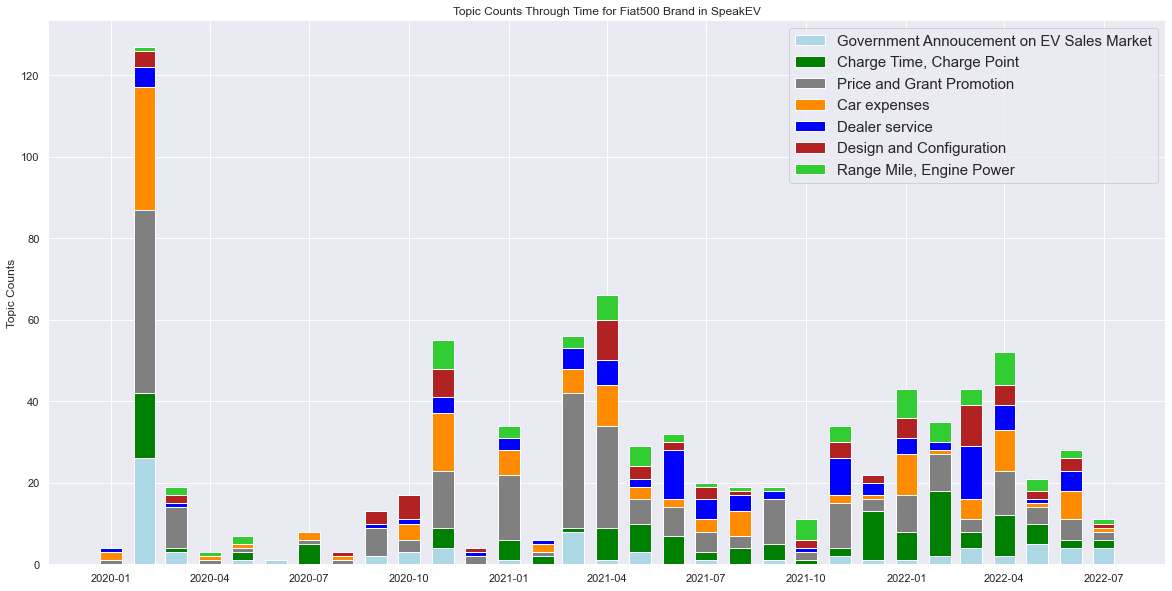

In [829]:
df_topics_fiat500 = topics_per_month(df_time_sentiment, 'Fiat500', 'Fiat_Brand', topic_labels_brand)

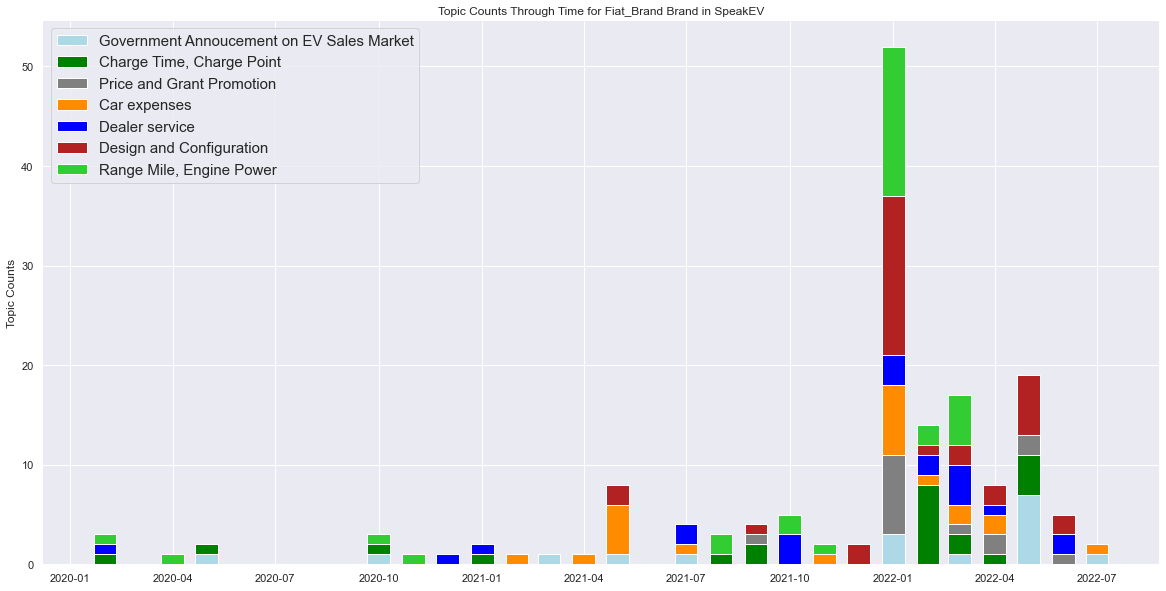

In [830]:
df_topics_fiat = topics_per_month(df_time_sentiment, 'Fiat_Brand', 'Fiat500',  topic_labels_brand)

In [430]:
topic_model_brand['Main_topic1'] = topic_larger_brand['Main_topic1']
topic_labels_brand = ['Government Annoucement on EV Sales Market','Charge Time, Charge Point','Price and Grant Promotion','Car expenses',
'Dealer service','Design and Configuration','Range Mile, Engine Power']

In [441]:
topics_trend= topic_model_brand.groupby(['month_year', 'Main_topic1']).size().unstack(fill_value=0)

In [470]:
def brand_sentiment_dispersion_plot(df, topic1, colname1, colname2, topic_labels):
    
   colors = ["lightblue","green","grey","darkorange","blue","firebrick","limegreen",'salmon','purple','lightcoral']

   sent_colors = ['red', 'grey', 'green']

   width = 20

   df['date'] = pd.to_datetime(df['Discussion Date'])
   df['month_year'] = pd.to_datetime(df['date']).dt.to_period('Q')
   df = df.loc[df['month_year'].between('2020-01','2022-06', inclusive=True)]
   df = df.loc[(df[colname1] ==1) & (df[colname2] !=1)]

   topics_sent_dispersion = df.groupby(['month_year', 'sentiment', 'Main_topic1', colname1, colname2])['Main_topic1'].size().unstack('Main_topic1', fill_value=0)
   topics_sent_dispersion = topics_sent_dispersion.reset_index()
   
   fig = plt.figure(figsize=(20, 10))
   ax1 = fig.add_subplot(1, 1, 1)

   df_topics= df.groupby(['month_year', 'Main_topic1']).size().unstack(fill_value=0)
   df_topics.reset_index(inplace=True)
   quarter1 = df_topics['month_year'].dt.to_timestamp()
   
   for topic, ax in zip([topic1], [ax1]):
    topic_name = "Topic "+str(topic)
    #topics_sent_dispersion_topic = topics_sent_dispersion.loc[topics_sent_dispersion[topic] == topic_name]
    y_sent_pos = pd.DataFrame(topics_sent_dispersion.loc[topics_sent_dispersion['sentiment']== 'pos'])
    y_sent_pos = y_sent_pos.merge(df_topics, left_on = 'month_year', right_on = 'month_year', how = 'right', suffixes=('', '_drop'))
    y_sent_pos['sentiment'] = y_sent_pos['sentiment'].fillna('pos')
    y_sent_pos = y_sent_pos.fillna(0)
    y_sent_pos = y_sent_pos[topic_name]

    y_sent_neu = pd.DataFrame(topics_sent_dispersion.loc[topics_sent_dispersion['sentiment']== 'neu'])
    y_sent_neu = y_sent_neu.merge(df_topics, left_on = 'month_year', right_on = 'month_year', how = 'right', suffixes=('', '_drop'))
    y_sent_neu['sentiment'] = y_sent_neu['sentiment'].fillna('neu')
    y_sent_neu = y_sent_neu.fillna(0)
    y_sent_neu = y_sent_neu[topic_name]

    y_sent_neg = pd.DataFrame(topics_sent_dispersion.loc[topics_sent_dispersion['sentiment']== 'neg'])
    y_sent_neg = y_sent_neg.merge(df_topics, left_on = 'month_year', right_on = 'month_year', how = 'right', suffixes=('', '_drop'))
    y_sent_neg['sentiment'] = y_sent_neg['sentiment'].fillna('neg')
    y_sent_neg = y_sent_neg.fillna(0)
    y_sent_neg = y_sent_neg[topic_name]


    ax.bar(quarter1, y_sent_neg, width, label = 'neg', color = sent_colors[0])
    ax.bar(quarter1, y_sent_neu, width, label = 'neu', color = sent_colors[1], bottom = y_sent_neg)
    ax.bar(quarter1, y_sent_pos, width, label = 'pos', color = sent_colors[2], bottom = y_sent_neg + y_sent_neu)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False) 
    
    # Labelling 

   #  ax.set_xticklabels([topic_model_brand['month_year'].dt.strftime('%m/%Y')[i] for i in range(0,10,1)])
   #  ax.set_xticklabels([topic_model_brand['month_year'][j] for j in range(0,10,1)])

    ax.set_ylabel("Comment Counts")
    ax.set_title("Dispersion of Sentiment over time in {}: ".format(colname1) + topic_labels[topic-1])
   
   plt.legend()
   plt.show()

   # return topics_sent_dispersion

In [500]:
# # Fiat500 Brand Range Mile and Engine Power
# brand_sentiment_dispersion_plot(topic_model_brand, 7,  'Fiat500', 'Fiat_Brand', topic_labels_brand)

In [501]:
# # Fiat500 Brand Range Mile and Engine Power
# brand_sentiment_dispersion_plot(topic_model_brand, 7,   'Fiat_Brand', 'Fiat500',topic_labels_brand)

In [502]:
# # Fiat500 Brand Design
# brand_sentiment_dispersion_plot(topic_model_brand, 6,  'Fiat500', 'Fiat_Brand', topic_labels_brand)

In [503]:
# # Fiat Brand Design
# brand_sentiment_dispersion_plot(topic_model_brand, 6,  'Fiat_Brand', 'Fiat500', topic_labels_brand)

## PMI - Q2

In [504]:
pmi_topic_brand = pd.concat([topic_larger_brand,topic_model_brand[['Sentiment_corpus']]],axis=1)
pmi_topic_brand

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Main_topic1,Main_topic2,compound,sentiment,Fiat_Brand,Fiat500,Comment,Sentiment_corpus
0,0.633220,0.000000,0.00000,0.0,0.366780,0.000000,0.000000,Topic 1,Topic 5,0.1280,pos,1.0,0.0,\nseems fiat have announced that they will sto...,fiat announce stop sell non electrify car soon...
1,0.586145,0.000000,0.00000,0.0,0.000000,0.413855,0.000000,Topic 1,Topic 6,0.4215,pos,1.0,0.0,"\n""electrified"" is a little... misleading? in ...",electrify little misleading context g mhd mode...
2,0.000000,0.000000,0.35295,0.0,0.000000,0.647050,0.000000,Topic 6,Topic 3,0.3716,pos,1.0,0.0,\npersonally i'm pretty keen for a bev version...,personally m pretty keen bev version panda sus...
3,0.841385,0.000000,0.00000,0.0,0.158615,0.000000,0.000000,Topic 1,Topic 5,-0.2732,neg,1.0,0.0,\nlots of reports that fiat will go full elect...,lot report fiat electric july mean hybrid mild...
4,0.557725,0.000000,0.00000,0.0,0.442275,0.000000,0.000000,Topic 1,Topic 5,0.0000,neu,1.0,0.0,'electrification' seems to be the new 'self ch...,electrification new self charge ford website a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,0.619539,0.000000,0.00000,0.0,0.000000,0.380461,0.000000,Topic 1,Topic 6,0.2500,pos,0.0,1.0,well the lesson to be learned is be careful of...,lesson learn careful scammer rebadge model sel...
999,0.660111,0.000000,0.00000,0.0,0.000000,0.000000,0.339889,Topic 1,Topic 7,0.9052,pos,0.0,1.0,nevertheless it's part of the new trading cond...,new trading condition affect new ish product m...
1000,0.000000,0.000000,0.53042,0.0,0.000000,0.000000,0.469580,Topic 3,Topic 7,0.9181,pos,0.0,1.0,sure the article makes that clear but again is...,sure article clear point good think receive ro...
1001,0.000000,0.511367,0.00000,0.0,0.000000,0.000000,0.488633,Topic 2,Topic 7,0.0000,neu,0.0,1.0,do we need 500bhp for cars licensed to drive o...,need car license drive public road tyre


In [505]:
# fiat 500 brand
pmi_fiat500_df =pmi_topic_brand.loc[(pmi_topic_brand['Fiat500'] == 1) & (pmi_topic_brand['Fiat_Brand'] != 1)]
fiat500_neg_df = pmi_fiat500_df.loc[(pmi_fiat500_df['sentiment'] == 'neg')]
fiat500_neu_df = pmi_fiat500_df.loc[(pmi_fiat500_df['sentiment'] == 'neu')]
fiat500_pos_df = pmi_fiat500_df.loc[(pmi_fiat500_df['sentiment'] == 'pos')]

# fiat brand
pmi_fiat_df =pmi_topic_brand.loc[(pmi_topic_brand['Fiat500'] != 1) & (pmi_topic_brand['Fiat_Brand'] == 1)]
fiat_neg_df = pmi_fiat_df.loc[(pmi_fiat_df['sentiment'] == 'neg')]
fiat_neu_df = pmi_fiat_df.loc[(pmi_fiat_df['sentiment'] == 'neu')]
fiat_pos_df = pmi_fiat_df.loc[(pmi_fiat_df['sentiment'] == 'pos')]


## PMI - Fiat 500 Brand Super Negative 

In [511]:
# Super negative in Fiat 500 Brand
fiat500_sup_neg_df  = fiat500_neg_df.copy()
fiat500_sup_neg_df = fiat500_sup_neg_df.loc[fiat500_sup_neg_df['compound'] < -0.5]

In [512]:
fiat500_sup_neg_df['Main_topic1'].value_counts().sort_values(ascending = False)


Topic 2    13
Topic 4    12
Topic 3     9
Topic 6     9
Topic 5     6
Topic 1     6
Topic 7     4
Name: Main_topic1, dtype: int64

In [530]:
charge_sup_neg = fiat500_sup_neg_df[fiat500_sup_neg_df['Main_topic1'] =='Topic 2'].shape[0]/fiat500_sup_neg_df.shape[0]
print('{}% of super negative comments in Fiat500 Brnadrelated to Charging'.format(round(charge_sup_neg*100,2)))

expenses_sup_neg = fiat500_sup_neg_df[fiat500_sup_neg_df['Main_topic1'] =='Topic 4'].shape[0]/fiat500_sup_neg_df.shape[0]
print('{}% of super negative comments in Fiat500 Brand related to Car Expenses'.format(round(expenses_sup_neg*100,2)))

22.03% of super negative comments in Fiat500 Brnadrelated to Charging
20.34% of super negative comments in Fiat500 Brand related to Car Expenses


## PMI - Fiat Brand Super Negative 

In [510]:
# Super negative in Fiat 500 Brand
fiat_sup_neg_df  = fiat_neg_df.copy()
fiat_sup_neg_df = fiat_sup_neg_df.loc[fiat_sup_neg_df['compound'] < -0.5]

In [513]:
fiat_sup_neg_df['Main_topic1'].value_counts().sort_values(ascending = False)


Topic 7    4
Topic 2    4
Topic 4    4
Topic 5    3
Topic 6    2
Topic 1    2
Topic 3    1
Name: Main_topic1, dtype: int64

In [531]:
engine_sup_neg = fiat_sup_neg_df[fiat_sup_neg_df['Main_topic1'] =='Topic 7'].shape[0]/fiat_sup_neg_df.shape[0]
print('{}% of super negative comments in Fiat Brand related to Engine'.format(round(engine_sup_neg*100,2)))

20.0% of super negative comments in Fiat Brand related to Engine


## PMI - Fiat Brand Desgin Positive

In [540]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_fiat_design_pos(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [541]:
tp6_fiat_pos_df = fiat_pos_df.loc[(fiat_pos_df['Main_topic1'] == 'Topic 6')] 
tp6_fiat_pos_bigrams, tp6_fiat_pos_trigrams = pmi_fiat_design_pos(df = tp6_fiat_pos_df, column_name='Sentiment_corpus')
print(tp6_fiat_pos_bigrams)
print('----------')
print(tp6_fiat_pos_trigrams)

Number of words in the corpus: 1502
[('aircon', 'heating'), ('autistic', 'spectrum'), ('bird', 'eye'), ('boot', 'family'), ('camera', 'timer'), ('cheer', 'tony'), ('citroen', 'picasso'), ('dealer', 'stealer'), ('explain', 'dealer'), ('eye', 'view'), ('family', 'weekly'), ('granddaughter', 'autistic'), ('granny', 'grandad'), ('ground', 'clearance'), ('house', 'increasingly'), ('increasingly', 'obvious'), ('leg', 'short'), ('legroom', 'require'), ('main', 'house'), ('plug', 'absolute'), ('pro', 'con'), ('purchase', 'hybrid'), ('remote', 'aircon'), ('round', 'bird'), ('shop', 'prefer'), ('short', 'body'), ('stealer', 'cheer'), ('timer', 'remote'), ('walk', 'distance'), ('weekly', 'shop'), ('grandad', 'flat'), ('heating', 'function'), ('hi', 'proud'), ('hide', 'away'), ('low', 'mileage'), ('modular', 'concept'), ('nice', 'white'), ('prefer', 'wheel'), ('psa', 'nonsense'), ('tekna', 'camera'), ('white', 'pale'), ('boy', 'toy'), ('child', 'toy'), ('colour', 'dark'), ('colour', 'reasonable'),

Main Takeaway:
- Space in terms of boot size and the legroom 
('reasonable', 'size', 'boot'),('lot', 'legroom', 'require'), e.g. 'felt like the sort of thing that fiat used to be great at - cheap but fun, robust and space-efficient.'
- Modular conception - make repairs and maintenance easier, or to allow the vehicle to be reconfigured to suit different functions.
 ('modular', 'concept'), e,g, 'brilliant and i love the shape proposed and modular concept.'

## PMI - Fiat 500 Brand Engine Positive

In [546]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_fiat500_engine_pos(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 50)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [549]:
tp7_fiat500_pos_df = fiat500_pos_df.loc[(fiat500_pos_df['Main_topic1'] == 'Topic 7')] 
tp7_fiat500_pos_bigrams, tp7_fiat500_pos_trigrams = pmi_fiat500_engine_pos(df = tp7_fiat500_pos_df, column_name='Sentiment_corpus')
print(tp7_fiat500_pos_bigrams)
print('----------')
print(tp7_fiat500_pos_trigrams)

Number of words in the corpus: 4266
[('centre', 'console'), ('injector', 'upgrade'), ('sw', 'relate'), ('fix', 'glass'), ('iron', 'loss'), ('phase', 'ac'), ('regenerative', 'braking'), ('vac', 'operate'), ('vs', 'rival'), ('op', 'refer'), ('clear', 'colourful'), ('turn', 'circle'), ('non', 'opening'), ('elmo', 'offer'), ('torque', 'steer'), ('touch', 'screen'), ('wireless', 'apple'), ('real', 'world'), ('easy', 'park'), ('la', 'prima'), ('prima', 'edition'), ('skinny', 'tyre'), ('case', 'scenario'), ('super', 'smooth'), ('rear', 'view'), ('wind', 'noise'), ('push', 'button'), ('opening', 'sunroof'), ('leave', 'foot'), ('mg', 'zs'), ('normal', 'sized'), ('canvas', 'roof'), ('journey', 'electric'), ('wife', 'choose'), ('fiesta', 'renault'), ('central', 'display'), ('sunny', 'day'), ('gear', 'lever'), ('leaf', 'tekna'), ('panoramic', 'sunroof'), ('ago', 'love'), ('lever', 'zoe'), ('mode', 'whilst'), ('rival', 'mg'), ('bmw', 'i3'), ('glass', 'roof'), ('work', 'properly'), ('year', 'ago'), 

In [555]:
tp7_fiat500_pos_df[tp7_fiat500_pos_df['Comment'].str.contains('pedal')]

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Main_topic1,Main_topic2,compound,sentiment,Fiat_Brand,Fiat500,Comment,Sentiment_corpus
161,0.0,0.241017,0.000000,0.000000,0.0,0.0,0.758982,Topic 7,Topic 2,0.9996,pos,0.0,1.0,\nhow to make this review short. fiat have a w...,review short fiat winner hand process look rep...
168,0.0,0.198604,0.000000,0.000000,0.0,0.0,0.801396,Topic 7,Topic 2,0.9850,pos,0.0,1.0,\nforgot to mention the excellent turning circ...,forget mention excellent turn circle honda bmw...
169,0.0,0.000000,0.000000,0.391275,0.0,0.0,0.608725,Topic 7,Topic 4,0.8271,pos,0.0,1.0,\nyou can definitely one pedal drive in range ...,definitely pedal drive range mode try test dri...
360,0.0,0.000000,0.357184,0.000000,0.0,0.0,0.642816,Topic 7,Topic 3,0.6249,pos,0.0,1.0,"hi the fiat 500e has it, i am finding the one ...",hi fiat find pedal drive great
406,0.0,0.000000,0.000000,0.229769,0.0,0.0,0.770231,Topic 7,Topic 4,0.9943,pos,0.0,1.0,"two months later, arval are still saying i'm t...",month later arval m far end lease renewal quot...


In [558]:
pmi_fiat500_df[pmi_fiat500_df['Comment'].str.contains('pedal')]

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Main_topic1,Main_topic2,compound,sentiment,Fiat_Brand,Fiat500,Comment,Sentiment_corpus
161,0.0,0.241017,0.000000,0.000000,0.0,0.000000,0.758982,Topic 7,Topic 2,0.9996,pos,0.0,1.0,\nhow to make this review short. fiat have a w...,review short fiat winner hand process look rep...
168,0.0,0.198604,0.000000,0.000000,0.0,0.000000,0.801396,Topic 7,Topic 2,0.9850,pos,0.0,1.0,\nforgot to mention the excellent turning circ...,forget mention excellent turn circle honda bmw...
169,0.0,0.000000,0.000000,0.391275,0.0,0.000000,0.608725,Topic 7,Topic 4,0.8271,pos,0.0,1.0,\nyou can definitely one pedal drive in range ...,definitely pedal drive range mode try test dri...
232,0.0,0.000000,0.000000,0.378372,0.0,0.000000,0.621628,Topic 7,Topic 4,-0.6486,neg,0.0,1.0,not me. we've driven the e2008 and spent 20 mi...,ve drive e spend minute static c4 key spend lo...
359,0.0,0.209206,0.000000,0.000000,0.0,0.000000,0.790794,Topic 7,Topic 2,-0.2960,neg,0.0,1.0,"\nfiat 500e has one pedal driving mode, rarely...",fiat pedal drive mode rarely need touch brake ...
360,0.0,0.000000,0.357184,0.000000,0.0,0.000000,0.642816,Topic 7,Topic 3,0.6249,pos,0.0,1.0,"hi the fiat 500e has it, i am finding the one ...",hi fiat find pedal drive great
363,0.0,0.000000,0.623900,0.000000,0.0,0.000000,0.376100,Topic 3,Topic 7,0.3948,pos,0.0,1.0,based on the ford video and spec it was one pe...,base ford video spec pedal add fiat add ev ped...
406,0.0,0.000000,0.000000,0.229769,0.0,0.000000,0.770231,Topic 7,Topic 4,0.9943,pos,0.0,1.0,"two months later, arval are still saying i'm t...",month later arval m far end lease renewal quot...
566,0.0,0.384553,0.000000,0.000000,0.0,0.615447,0.000000,Topic 6,Topic 2,0.8828,pos,0.0,1.0,this the type i have:\n\n\n\n\n\n\n\n\ndenny i...,type denny international large compact portabl...


Main Takeaway:
- people supurise on the convertible model ('like', 'convertible', 'need'), ('convertible', 'car', 'surprise'),
- dicussion about the opening sunroof and gear system , ('steering', 'wheel', 'gear'), ('wheel', 'gear', 'lever')
- one pedal drive in range mode e.g. ’the fiat 500e has it, i am finding the one pedal driving great‘  -> mentioned 5 times with super positive attitudes, 7 out of 9 people dicussed one pedal driving with postiive attitude. - save energy, improve EV range especially for long-distrance journey https://www.makeuseof.com/what-is-single-pedal-driving-extend-ev-range/

# Whole Electric &  Competitor

In [565]:
'''
# keyword: Fiat #brand
# results: 500 results 
# forum: General EV Discussion; Fiat EV forum; General Fiat Discussion; Fiat 500; 
# search in sub-forum
# '''
speakEV_fiat_full_df = pd.read_csv('0801_Fiat_subforum_speakEV.csv',index_col=0)
print(speakEV_fiat_full_df.shape)


'''
# keyword: Fiat 500 # model
# results: 500 results
# forum: General EV Discussion; Fiat EV forum; General Fiat Discussion; Fiat 500; 
# search in sub-forum
'''
speakEV_fiat500_full_df = pd.read_csv('0801_Fiat500_subforum_speakEV.csv',index_col=0)
print(speakEV_fiat500_full_df.shape)

(10308, 7)
(13499, 7)


In [566]:
# Explorational analysis
prelim_explor_speakev(speakEV_fiat500_full_df,'Comment')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13499 entries, 0 to 13498
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   UserID                 13499 non-null  int64 
 1   Username               12979 non-null  object
 2   Link of user profile   13499 non-null  object
 3   Num of posts per user  13499 non-null  object
 4   Thread Title           13499 non-null  object
 5   Comment                13499 non-null  object
 6   Discussion Date        13499 non-null  object
dtypes: int64(1), object(6)
memory usage: 843.7+ KB
None
------------
count    13406.000000
mean        68.620021
std         82.740201
min          1.000000
25%         21.000000
50%         45.000000
75%         85.000000
max       1915.000000
Name: word_count, dtype: float64
------------

    Data information
    --------------------------------------
    Total number of comments: 13406
    Average lenght of each reply: 383.76

,UserID,Username,Link of user profile,Num of posts per user,Thread Title,Comment,Discussion Date,word_count
0,7126,MarkyM,https://www.speakev.com/members/markym.7126/,799,Fiat 500e Convertible La Prima Test Drive/Review,\nHow to make this review short. Fiat have a W...,"Apr 24, 2021",1181
1,49337,WillWord,https://www.speakev.com/members/willword.49337/,32,Fiat 500e Convertible La Prima Test Drive/Review,"\nNice review, I am having a test drive on Tue...","Apr 24, 2021",32
2,91962,idiotzoo,https://www.speakev.com/members/idiotzoo.91962/,"2,121",Fiat 500e Convertible La Prima Test Drive/Review,\nI saw Jonny Smith’s early review of this and...,"Apr 24, 2021",13
3,7126,MarkyM,https://www.speakev.com/members/markym.7126/,799,Fiat 500e Convertible La Prima Test Drive/Review,\nI work in the NHS and with their finance pac...,"Apr 24, 2021",45
4,13593,tophatron,https://www.speakev.com/members/tophatron.13593/,37,Fiat 500e Convertible La Prima Test Drive/Review,\nI noticed this site seems to have some reall...,"Apr 24, 2021",31
...,...,...,...,...,...,...,...,...
13401,79222,Jon Chalk,https://www.speakev.com/members/jon-chalk.79222/,531,Fisker Ocean,\nIf they're still going and still in the UK i...,"May 4, 2022",72
13402,104153,Phil1,https://www.speakev.com/members/phil1.104153/,721,Fisker Ocean,"No, we don't need it. We do want it though. \n \n","May 4, 2022",11
13403,95125,SoulGW,https://www.speakev.com/members/soulgw.95125/,"1,599",Fisker Ocean,"Nope.\n\nWhen I was 17, a 0-60 of 10 seconds w...","May 4, 2022",124
13404,8167,jmacneil,https://www.speakev.com/members/jmacneil.8167/,"2,377",Fisker Ocean,\nGiven the history I'd be wary of actually pa...,"May 4, 2022",22


In [567]:
# Check Discussion Date 2020-01-01 - now
speakEV_fiat500_full_df['date'] = pd. to_datetime(speakEV_fiat500_full_df['Discussion Date'])
speakEV_fiat500_full_df['month_year'] = pd.to_datetime(speakEV_fiat500_full_df['date']).dt.to_period('M')
speakEV_fiat500_full_df = speakEV_fiat500_full_df.loc[speakEV_fiat500_full_df['month_year'].between('2020-01','2022-07', inclusive=True)]

In [568]:
# Text Cleaning
# Create the corpus
clean_corpus_q1 = [cleaning_text_speakEV(comment) for comment in speakEV_fiat500_full_df['Comment']]

# add clean corpus to dataframe
speakEV_fiat500_full_df['Clean_Corpus'] = clean_corpus_q1

In [569]:
speakEV_fiat500_full_df['Comment'] = speakEV_fiat500_full_df['Comment'].str.lower()
speakEV_fiat500_full_df['Thread Title'] = speakEV_fiat500_full_df['Thread Title'].str.lower()
speakEV_fiat500_full_df = speakEV_fiat500_full_df.rename(columns = {'Thread Title':'Thread_Title'})

In [570]:
# check UserID
groupuser = pd.Series(speakEV_fiat500_full_df.groupby(['Username'])['Comment'].count()).sort_values(ascending = False)
groupuser.head(10)

Username
donald           665
cah197           387
metastable       373
Tooks            252
dk6780           221
phil-ev          204
andrew*debbie    202
EdH              191
mikegs           167
alegar           155
Name: Comment, dtype: int64

In [571]:
competitor_list = ['fiat','mini','vauxhall','renault','peugeote','honda','volkswagen','bmw','mercedes','volvo','tesla','nissan','hyundai']
model_list = [['fiat','500e','fiat 500','new 500','e 500','e500','500 e'],['mini','minielectric'],['vauxhall','corsa-e','corsa','e-corsa'],['renault','zoe'],['peugeote','peugeote-208','e208','e-208'],
                    ['honda','honda-e','honda e'],['vw','volkswagen'],['bmw','i3'],['mercedes'],['volvo'],['tesla'],['nissan','leaf','nissan leafs'],['hyundai','ioniq']]
for i in range(len(competitor_list)):
    extract_model_speakEV(speakEV_fiat500_full_df,'Comment','Thread_Title',model = competitor_list[i], model_list = model_list[i])

In [572]:
for col in competitor_list:
    print("Number of comments related to {}: {}".format(col, sum(speakEV_fiat500_full_df[col])))

Number of comments related to fiat: 735
Number of comments related to mini: 372
Number of comments related to vauxhall: 151
Number of comments related to renault: 822
Number of comments related to peugeote: 66
Number of comments related to honda: 139
Number of comments related to volkswagen: 404
Number of comments related to bmw: 455
Number of comments related to mercedes: 57
Number of comments related to volvo: 42
Number of comments related to tesla: 793
Number of comments related to nissan: 1037
Number of comments related to hyundai: 526


In [573]:
# speakEV_fiat500_full_df.groupby('month_year').aggregate({np.sum}).sort_values(ascending=True)
speakEV_fiat500_discussion_df = speakEV_fiat500_full_df.groupby(['month_year']) ['fiat','mini','vauxhall','renault','peugeote','honda','volkswagen','bmw','mercedes','volvo','tesla','nissan','hyundai'].sum().reset_index()
speakEV_fiat500_discussion_df['month_year'] = pd.to_datetime(speakEV_fiat500_discussion_df['month_year'].astype(str))

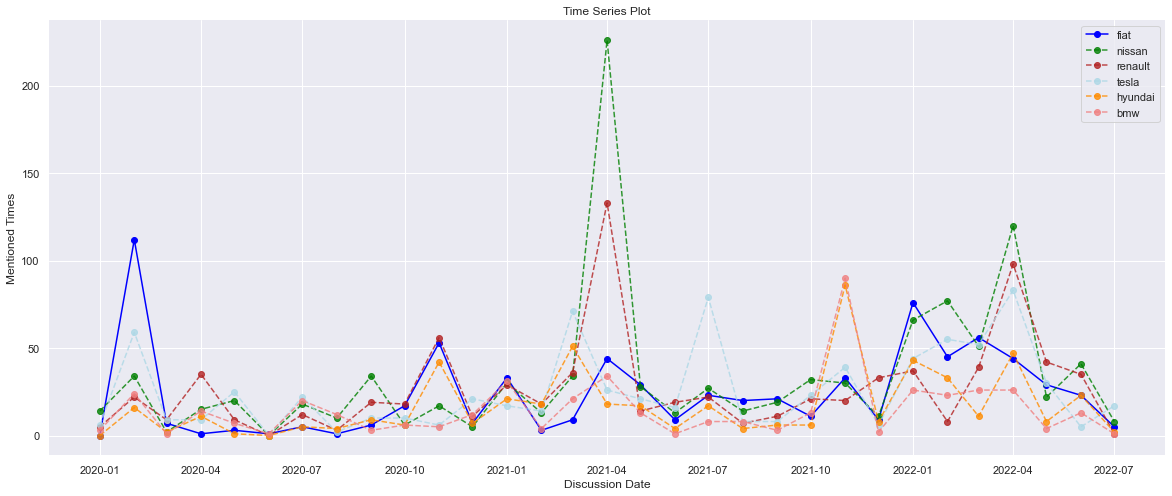

In [574]:
# Import Library
import matplotlib.pyplot as plt
label = ['fiat','nissan','renault','tesla','hyundai','bmw'] 
# Plot Mentioned Counts Top 5 
fig = plt.figure(figsize = (20,8), facecolor = None)
ax = fig.add_subplot()
plt.plot(speakEV_fiat500_discussion_df['month_year'],speakEV_fiat500_discussion_df["fiat"], marker='o', label = label[0],c= 'blue')
plt.plot(speakEV_fiat500_discussion_df['month_year'],speakEV_fiat500_discussion_df["nissan"], marker='o',label = label[1], c= 'green',ls ='--',alpha = 0.8)
plt.plot(speakEV_fiat500_discussion_df['month_year'],speakEV_fiat500_discussion_df["renault"], marker='o',label = label[2], c= 'firebrick',ls ='--',alpha = 0.8)
plt.plot(speakEV_fiat500_discussion_df['month_year'],speakEV_fiat500_discussion_df["tesla"], marker='o',label = label[3], c= 'lightblue',ls ='--',alpha = 0.8)
plt.plot(speakEV_fiat500_discussion_df['month_year'],speakEV_fiat500_discussion_df["hyundai"], marker='o',label = label[4], c= 'darkorange',ls ='--',alpha = 0.8)
plt.plot(speakEV_fiat500_discussion_df['month_year'],speakEV_fiat500_discussion_df["bmw"], marker='o',label = label[5], c= 'lightcoral',ls ='--',alpha = 0.8)

# Labelling 
plt.xlabel("Discussion Date")
plt.ylabel("Mentioned Times")
plt.title("Time Series Plot")

# Display
## aest
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.legend()
plt.show()

## Extract Words - Whole Electric

In [712]:
def extracting_BEV_whole(df, column_name):
    BEV_1 = df[df[column_name].str.contains('bev|evs|eletric|ev') & df[column_name].str.contains('fiat|mini|peugeote|honda｜renault｜nissan｜hyundai')]
    BEV_2 = df[df[column_name].str.contains('new 500|500e|500 e|500 e|mini e｜minielectric|corsa-e|e-corsa|zoe|peugeote-208|e208|e-208|honda-e|honda e|e honda|nisaan leaf|nissan leafs|ioniq')]
    BEV = pd.concat([BEV_1, BEV_2], axis=0)
    BEV.drop_duplicates(inplace=True)
    BEV = BEV.reset_index(drop=True)
    return BEV

In [713]:
speakEV_BEV_wholeev = extracting_BEV_whole(speakEV_fiat500_full_df,'temp')
speakEV_BEV_wholeev.T

,0,1,2,3,4,5,6,7,8,9,...,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814
UserID,7126,49337,91962,7126,13593,49337,3413,7126,13593,59017,...,98903,73512,98903,74132,98903,99112,75630,2505,13593,107349
Username,MarkyM,WillWord,idiotzoo,MarkyM,tophatron,WillWord,Oilymo,MarkyM,tophatron,Kronospace,...,LaserTam,TJEV,LaserTam,E7EV,LaserTam,marko68,BornAgainEcoWarrior,cah197,tophatron,Rbrian
Link of user profile,https://www.speakev.com/members/markym.7126/,https://www.speakev.com/members/willword.49337/,https://www.speakev.com/members/idiotzoo.91962/,https://www.speakev.com/members/markym.7126/,https://www.speakev.com/members/tophatron.13593/,https://www.speakev.com/members/willword.49337/,https://www.speakev.com/members/oilymo.3413/,https://www.speakev.com/members/markym.7126/,https://www.speakev.com/members/tophatron.13593/,https://www.speakev.com/members/kronospace.59017/,...,https://www.speakev.com/members/lasertam.98903/,https://www.speakev.com/members/tjev.73512/,https://www.speakev.com/members/lasertam.98903/,https://www.speakev.com/members/e7ev.74132/,https://www.speakev.com/members/lasertam.98903/,https://www.speakev.com/members/marko68.99112/,https://www.speakev.com/members/bornagainecowa...,https://www.speakev.com/members/cah197.2505/,https://www.speakev.com/members/tophatron.13593/,https://www.speakev.com/members/rbrian.107349/
Num of posts per user,799,32,"2,121",799,37,32,343,799,37,55,...,46,"3,302",46,"3,745",46,15,"3,931","26,262",37,420
Thread_Title,fiat 500e convertible la prima test drive/review,fiat 500e convertible la prima test drive/review,fiat 500e convertible la prima test drive/review,fiat 500e convertible la prima test drive/review,fiat 500e convertible la prima test drive/review,fiat 500e convertible la prima test drive/review,fiat 500e convertible la prima test drive/review,fiat 500e convertible la prima test drive/review,fiat 500e convertible la prima test drive/review,fiat 500e convertible la prima test drive/review,...,500e discounts available?,500e discounts available?,500e discounts available?,500e discounts available?,500e discounts available?,500e discounts available?,buying an older ev,buying an older ev,buying an older ev,fisker ocean
Comment,\nhow to make this review short. fiat have a w...,"\nnice review, i am having a test drive on tue...",\ni saw jonny smith’s early review of this and...,\ni work in the nhs and with their finance pac...,\ni noticed this site seems to have some reall...,"thanks, son's in nhs so its a possible route t...",\nwe’ve also got our test drive on tuesday. ca...,\nforgot to mention the excellent turning circ...,\nyou can definitely one pedal drive in range ...,\ndid you find the start up chimes/sound and l...,...,"thanks.\nyes, i am being offered the deposit c...",\nyeah you’ll need to wait a while until there...,\nwell it looks like i may have got myself a d...,glyn hopkin cambridge are offering an ocean gr...,thanks but my wife insists it's celestial blue...,"hi laser tam,just joined,i have ordered a fiat...",some early evs (zoe in particular) are battery...,"sorry, but that’s a bit unfair.\n\nbuild quali...",\ngenerally i would say a uk built leaf (2013 ...,of course not! for a couple of years i owned a...
Discussion Date,"Apr 24, 2021","Apr 24, 2021","Apr 24, 2021","Apr 24, 2021","Apr 24, 2021","Apr 24, 2021","Apr 25, 2021","Apr 25, 2021","Apr 25, 2021","Apr 25, 2021",...,"Sep 10, 2021","Sep 10, 2021","Sep 11, 2021","Sep 11, 2021","Sep 11, 2021","Sep 20, 2021","Sep 8, 2021","Sep 8, 2021","Sep 9, 2021","May 4, 2022"
date,2021-04-24 00:00:00,2021-04-24 00:00:00,2021-04-24 00:00:00,2021-04-24 00:00:00,2021-04-24 00:00:00,2021-04-24 00:00:00,2021-04-25 00:00:00,2021-04-25 00:00:00,2021-04-25 00:00:00,2021-04-25 00:00:00,...,2021-09-10 00:00:00,2021-09-10 00:00:00,2021-09-11 00:00:00,2021-09-11 00:00:00,2021-09-11 00:00:00,2021-09-20 00:00:00,2021-09-08 00:00:00,2021-09-08 00:00:00,2021-09-09 00:00:00,2022-05-04 00:00:00
month_year,2021-04,2021-04,2021-04,2021-04,202

In [714]:
competitor_list = ['fiat','mini','vauxhall','renault','peugeote','honda','nissan','hyundai']
model_list = [['fiat','500e','fiat 500','new 500','e 500','e500','500 e'],['mini','minielectric'],['vauxhall','corsa-e','corsa','e-corsa'],['renault','zoe'],['peugeote','peugeote-208','e208','e-208'],
                    ['honda','honda-e','honda e'],['nissan','leaf'],['hyundai','ioniq']]
for i in range(len(competitor_list)):
    extract_model_speakEV(speakEV_BEV_wholeev,'Comment','Thread_Title',model = competitor_list[i], model_list = model_list[i])

In [815]:
competitor_tabel = pd.DataFrame()
Related_comments = []
for col in competitor_list:
    print("Number of comments related to {}: {}".format(col, sum(speakEV_BEV_wholeev[col])))
    Related_comments.append(sum(speakEV_BEV_wholeev[col]))

competitor_tabel['Related Comments'] = Related_comments
competitor_list_label = ['Fiat 500e','MINI e','Vauxhall corsa','Renault zoe','Peugeote e208','Honda e','Nissan leaf','Hyundai ioniq']
competitor_tabel.index = competitor_list_label
competitor_tabel

Number of comments related to fiat: 647
Number of comments related to mini: 317
Number of comments related to vauxhall: 78
Number of comments related to renault: 630
Number of comments related to peugeote: 65
Number of comments related to honda: 114
Number of comments related to nissan: 287
Number of comments related to hyundai: 367


,Related Comments
Fiat 500e,647
MINI e,317
Vauxhall corsa,78
Renault zoe,630
Peugeote e208,65
Honda e,114
Nissan leaf,287
Hyundai ioniq,367


## Topic Modeling - Whole Electric Car

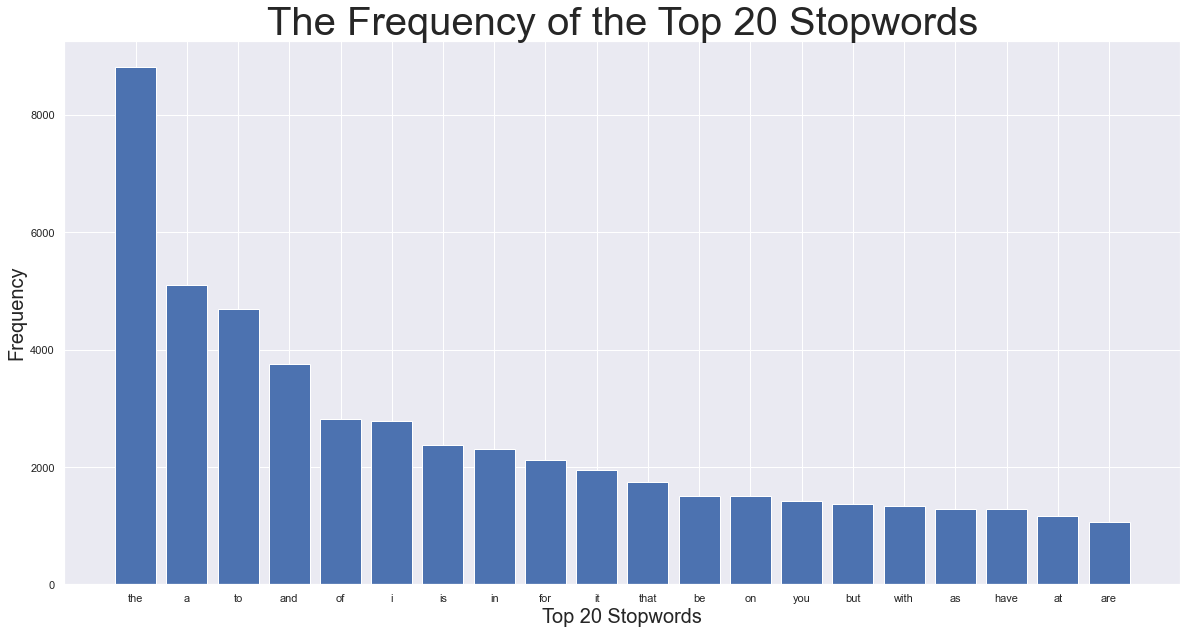

In [716]:
# plotting the top stopwords in the data
plot_top_stopwords_barchart(speakEV_BEV_wholeev['Comment'])

In [717]:
speakEV_Stopwords = ['the','a','to','and','of','i','is','in','for','it','that','you','be','on','you','but','with','have',
                'but','hav','are','as''at','car','year','don','d','ve','www','like','need','think','m','didn','oh', 'll','com',
                'electric','vehicle','fiat','500e','isn','vw','mini','zoe','bmw','corsa','leaf','tesla','nissan','bev','evs','ev','e208','panda',
                'etc','model','new','vauxhall','peugeote','peugeot','renault','honda','mercedes','volkswagen','volvo','i3','hyundai','ioniq','ev6','kia'
                'kona','want','use','niro','co','lot','mg','zs','ford','kia','mm','kw','10k','km','5dr','r135','100kw','ac','s','t','e','o','ll','didn','doesn','aren','g','thread','forum']

In [718]:
speakEV_most_freq = most_freq_speakEV(speakEV_BEV_wholeev,'Comment',Stopwords =speakEV_Stopwords)

---Most frequent words---
           0
charge   691
drive    558
mile     543
range    515
car      510
battery  467
look     462
good     452
time     419
price    417
go       395
cost     356
year     329
long     314
month    311
work     279
buy      279
get      279
charger  257
people   253


Iteration: 0	Log-likelihood: -8.090381505742112
Iteration: 10	Log-likelihood: -8.090381505742112
Iteration: 20	Log-likelihood: -8.090381505742112
Iteration: 30	Log-likelihood: -8.090381505742112
Iteration: 40	Log-likelihood: -8.090381505742112
Iteration: 50	Log-likelihood: -8.090381505742112
Iteration: 60	Log-likelihood: -8.090381505742112
Iteration: 70	Log-likelihood: -8.090381505742112
Iteration: 80	Log-likelihood: -8.090381505742112
Iteration: 90	Log-likelihood: -8.090381505742112
Iteration: 100	Log-likelihood: -8.090381505742112
Iteration: 110	Log-likelihood: -8.090381505742112
Iteration: 120	Log-likelihood: -8.090381505742112
Iteration: 130	Log-likelihood: -8.090381505742112
Iteration: 140	Log-likelihood: -8.090381505742112
Iteration: 150	Log-likelihood: -8.090381505742112
Iteration: 160	Log-likelihood: -8.090381505742112
Iteration: 170	Log-likelihood: -8.090381505742112
Iteration: 180	Log-likelihood: -8.090381505742112
Iteration: 190	Log-likelihood: -8.090381505742112
Iteration: 

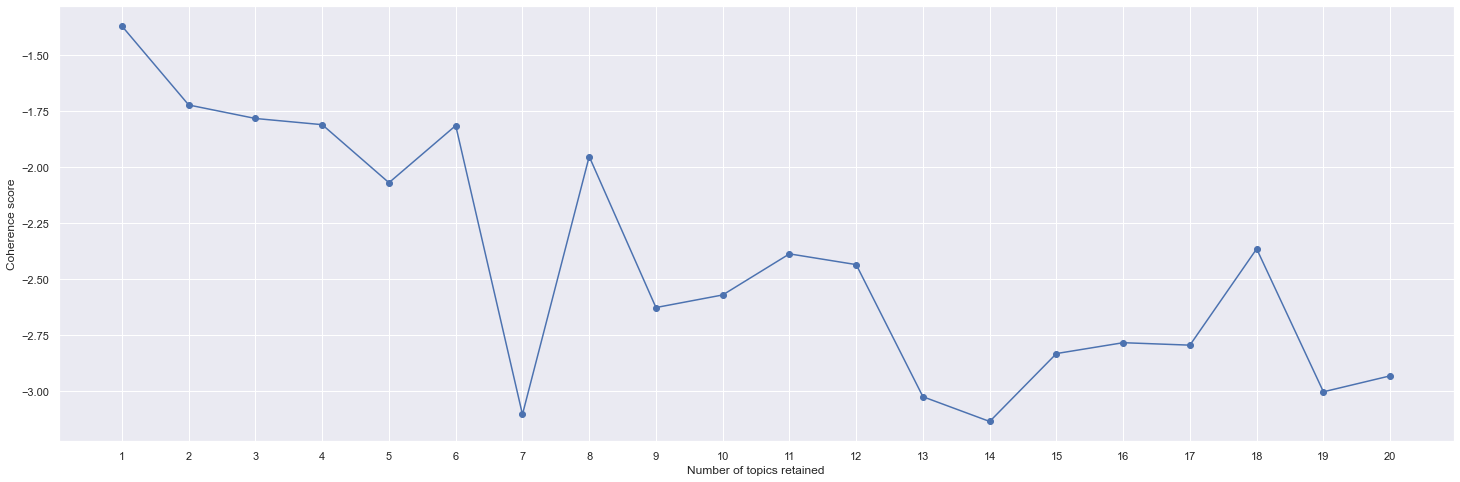

In [719]:
## Training LDAs to choose the best topic size
speaknEV_cvs_wholeev, speaknEV_corpus_wholeev, speaknEV_best_mdl_wholeev, speaknEV_topic_size_wholeev, speaknEV_docs_phrased_wholeev,drop_index_wholeev = tm_wholeev(df= speakEV_BEV_wholeev, comments= speakEV_BEV_wholeev['Clean_Corpus'],k=20, Stopwords = speakEV_Stopwords)

In [720]:
speakEV_best_mdl_trained_wholeev = train_tm(speaknEV_best_mdl_wholeev)

Iteration: 0	Log-likelihood: -8.87575797207039
Iteration: 4	Log-likelihood: -8.624403750845119
Iteration: 8	Log-likelihood: -8.524095709821985
Iteration: 12	Log-likelihood: -8.453322552884092
Iteration: 16	Log-likelihood: -8.408876734731665
Iteration: 20	Log-likelihood: -8.381747826288473
Iteration: 24	Log-likelihood: -8.359008483772433
Iteration: 28	Log-likelihood: -8.345265967533546
Iteration: 32	Log-likelihood: -8.315633679762232
Iteration: 36	Log-likelihood: -8.304960007783627
Iteration: 40	Log-likelihood: -8.305999517557824
Iteration: 44	Log-likelihood: -8.291306856146912
Iteration: 48	Log-likelihood: -8.278170313480468
Iteration: 52	Log-likelihood: -8.27041126418065
Iteration: 56	Log-likelihood: -8.27236203617013
Iteration: 60	Log-likelihood: -8.260389312955887
Iteration: 64	Log-likelihood: -8.255413792602683
Iteration: 68	Log-likelihood: -8.242731552800269
Iteration: 72	Log-likelihood: -8.241310386134314
Iteration: 76	Log-likelihood: -8.235398121414747
Iteration: 80	Log-likeliho

In [721]:
# Topic to word probabilities to understand words with the highest probabilities to occur in a topic and then
# to perhaps go back and include those words in custom stopwords in the LDA code
speakEV_wt_wholeev = pd.DataFrame()
for k in range(speakEV_best_mdl_trained_wholeev.k):
    words, probs = [], []
    for word, prob in speaknEV_best_mdl_wholeev.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    speakEV_wt_wholeev = pd.concat([speakEV_wt_wholeev, tmp], ignore_index=False)
    del tmp

In [722]:
speakEV_wt_wholeev.sort_values('prob', ascending=False).head(10)

,word,prob,k,sort
0,charge,0.128,8,0
0,battery,0.080,9,0
0,mile,0.073,10,0
1,range,0.070,10,1
0,month,0.050,5,0
1,lease,0.047,5,1
0,grant,0.046,4,0
0,cost,0.044,7,0
2,deal,0.043,5,2
0,motor,0.043,2,0


In [723]:
# Dataframe withe final topics
topics_speakEV_wholeev = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in speaknEV_best_mdl_wholeev.docs]),
    columns=["Topic {}".format(i + 1) for i in range(speaknEV_best_mdl_wholeev.k)])
topics_speakEV_wholeev

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14
0,0.039594,0.289405,0.068531,0.054270,0.000369,0.016561,0.014194,0.030576,0.028017,0.074927,0.106296,0.017908,0.225692,0.033660
1,0.019110,0.024192,0.008693,0.052486,0.012057,0.158592,0.017667,0.043081,0.023202,0.026462,0.031737,0.011555,0.554765,0.016400
2,0.025639,0.032458,0.011663,0.155833,0.101592,0.041947,0.023703,0.057800,0.031129,0.035503,0.042581,0.015503,0.402646,0.022003
3,0.015231,0.019282,0.006929,0.092575,0.161836,0.278629,0.115565,0.135821,0.018493,0.021091,0.025296,0.009210,0.086972,0.013071
4,0.012149,0.136800,0.005526,0.114314,0.088612,0.303191,0.051705,0.027388,0.014750,0.016823,0.101124,0.007346,0.109845,0.010426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,0.006163,0.028332,0.002803,0.140110,0.250257,0.256451,0.046759,0.096016,0.007482,0.029064,0.010235,0.003726,0.096782,0.025819
1801,0.009467,0.011985,0.004306,0.215230,0.005973,0.173179,0.040290,0.179033,0.011494,0.296953,0.015722,0.005724,0.022518,0.008124
1802,0.015231,0.120766,0.006929,0.092575,0.111094,0.024919,0.064823,0.085079,0.018493,0.071833,0.076038,0.059952,0.239198,0.013071
1803,0.009775,0.012375,0.004447,0.124543,0.006167,0.178819,0.009037,0.152298,0.011868,0.241493,0.016234,0.005911,0.218643,0.008389


In [724]:
# inspecting topic themes as a dataframe just out of curiosity.
speakEV_values_wholeev = {}
for k in range(speaknEV_best_mdl_wholeev.k):
    speakEV_values_wholeev['Topic {}'.format(k+1)]= [("{},({})".format(word, str(np.round(prob, 3)))) for word, prob in speaknEV_best_mdl_wholeev.get_topic_words(k)]
    # print the table
    #return (table)
speakEV_table_wholeev = pd.DataFrame(speakEV_values_wholeev)  
speakEV_table_wholeev

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14
0,"market,(0.024)","drive,(0.031)","motor,(0.043)","people,(0.02)","grant,(0.046)","month,(0.05)","dealer,(0.029)","cost,(0.044)","charge,(0.128)","battery,(0.08)","mile,(0.073)","energy,(0.024)","drive,(0.039)","charge,(0.031)"
1,"design,(0.021)","seat,(0.022)","speed,(0.031)","time,(0.02)","uk,(0.043)","lease,(0.047)","order,(0.021)","price,(0.028)","charger,(0.034)","big,(0.037)","range,(0.07)","power,(0.016)","look,(0.034)","charger,(0.025)"
2,"safety,(0.017)","old,(0.019)","brake,(0.028)","know,(0.018)","group,(0.019)","deal,(0.043)","place,(0.019)","ice,(0.024)","time,(0.032)","small,(0.034)","drive,(0.032)","reduce,(0.014)","good,(0.026)","cable,(0.022)"
3,"point,(0.014)","boot,(0.015)","pedal,(0.024)","work,(0.016)","europe,(0.016)","price,(0.039)","month,(0.016)","buy,(0.024)","battery,(0.019)","range,(0.018)","trip,(0.024)","ice,(0.014)","great,(0.018)","home,(0.021)"
4,"low,(0.01)","actually,(0.013)","stop,(0.023)","look,(0.016)","government,(0.014)","good,(0.031)","follow,(0.016)","fuel,(0.019)","stop,(0.019)","size,(0.016)","kwh,(0.021)","emission,(0.014)","bit,(0.017)","point,(0.019)"
5,"manufacturer,(0.01)","love,(0.013)","bitcoin,(0.023)","maybe,(0.014)","stellantis,(0.012)","look,(0.022)","service,(0.015)","sell,(0.018)","long,(0.018)","good,(0.015)","long,(0.019)","solar,(0.014)","test,(0.015)","work,(0.018)"
6,"increase,(0.01)","feel,(0.013)","gear,(0.018)","long,(0.014)","manufacturer,(0.011)","mile,(0.021)","software,(0.012)","cheap,(0.017)","rapid,(0.018)","system,(0.014)","day,(0.017)","world,(0.014)","nice,(0.014)","live,(0.017)"
7,"current,(0.009)","wife,(0.013)","mode,(0.016)","thing,(0.013)","company,(0.011)","cheap,(0.019)","update,(0.011)","money,(0.016)","rate,(0.017)","point,(0.012)","mph,(0.015)","manufacturer,(0.011)","come,(0.012)","free,(0.017)"
8,"tech,(0.008)","space,(0.011)","gearbox,(0.013)","issue,(0.013)","sub,(0.01)","uk,(0.016)","tell,(0.011)","old,(0.015)","hour,(0.017)","pack,(0.012)","work,(0.015)","green,(0.011)","thank,(0.012)","type,(0.016)"
9,"course,(0.008)","version,(0.01)","power,(0.013)","way,(0.013)","brand,(0.01)","offer,(0.016)","add,(0.011)","people,(0.012)","minute,(0.015)","swap,(0.011)","winter,(0.012)","transport,(0.01)","ask,(0.012)","come,(0.015)"


In [790]:
speakEV_table_wholeev_label = speakEV_table_wholeev.copy()
column_labels = ['Topic_1: Safety', 'Topic_2: Seat Function and Space','Topic_3: Power System','Topic_4: Car Issue',
                'Topic_5: Grant Promotion','Topic_6: Purchase and Deal','Topic_7: Dealer Service','Topic_8: Car expenses','Topic_9: Charge efficiency',
                'Topic_10: Battery System','Topic_11: Range','Topic_12: Sustainability','Topic_13: Driving Test Feedback','Topic_14: Charging Station Optional',]
speakEV_table_wholeev_label.columns = column_labels
speakEV_table_wholeev_label

,Topic_1: Safety,Topic_2: Seat Function and Space,Topic_3: Power System,Topic_4: Car Issue,Topic_5: Grant Promotion,Topic_6: Purchase and Deal,Topic_7: Dealer Service,Topic_8: Car expenses,Topic_9: Charge efficiency,Topic_10: Battery System,Topic_11: Range,Topic_12: Sustainability,Topic_13: Driving Test Feedback,Topic_14: Charging Station Optional
0,"market,(0.024)","drive,(0.031)","motor,(0.043)","people,(0.02)","grant,(0.046)","month,(0.05)","dealer,(0.029)","cost,(0.044)","charge,(0.128)","battery,(0.08)","mile,(0.073)","energy,(0.024)","drive,(0.039)","charge,(0.031)"
1,"design,(0.021)","seat,(0.022)","speed,(0.031)","time,(0.02)","uk,(0.043)","lease,(0.047)","order,(0.021)","price,(0.028)","charger,(0.034)","big,(0.037)","range,(0.07)","power,(0.016)","look,(0.034)","charger,(0.025)"
2,"safety,(0.017)","old,(0.019)","brake,(0.028)","know,(0.018)","group,(0.019)","deal,(0.043)","place,(0.019)","ice,(0.024)","time,(0.032)","small,(0.034)","drive,(0.032)","reduce,(0.014)","good,(0.026)","cable,(0.022)"
3,"point,(0.014)","boot,(0.015)","pedal,(0.024)","work,(0.016)","europe,(0.016)","price,(0.039)","month,(0.016)","buy,(0.024)","battery,(0.019)","range,(0.018)","trip,(0.024)","ice,(0.014)","great,(0.018)","home,(0.021)"
4,"low,(0.01)","actually,(0.013)","stop,(0.023)","look,(0.016)","government,(0.014)","good,(0.031)","follow,(0.016)","fuel,(0.019)","stop,(0.019)","size,(0.016)","kwh,(0.021)","emission,(0.014)","bit,(0.017)","point,(0.019)"
5,"manufacturer,(0.01)","love,(0.013)","bitcoin,(0.023)","maybe,(0.014)","stellantis,(0.012)","look,(0.022)","service,(0.015)","sell,(0.018)","long,(0.018)","good,(0.015)","long,(0.019)","solar,(0.014)","test,(0.015)","work,(0.018)"
6,"increase,(0.01)","feel,(0.013)","gear,(0.018)","long,(0.014)","manufacturer,(0.011)","mile,(0.021)","software,(0.012)","cheap,(0.017)","rapid,(0.018)","system,(0.014)","day,(0.017)","world,(0.014)","nice,(0.014)","live,(0.017)"
7,"current,(0.009)","wife,(0.013)","mode,(0.016)","thing,(0.013)","company,(0.011)","cheap,(0.019)","update,(0.011)","money,(0.016)","rate,(0.017)","point,(0.012)","mph,(0.015)","manufacturer,(0.011)","come,(0.012)","free,(0.017)"
8,"tech,(0.008)","space,(0.011)","gearbox,(0.013)","issue,(0.013)","sub,(0.01)","uk,(0.016)","tell,(0.011)","old,(0.015)","hour,(0.017)","pack,(0.012)","work,(0.015)","green,(0.011)","thank,(0.012)","type,(0.016)"
9,"course,(0.008)","version,(0.01)","power,(0.013)","way,(0.013)","brand,(0.01)","offer,(0.016)","add,(0.011)","people,(0.012)","minute,(0.015)","swap,(0.011)","winter,(0.012)","transport,(0.01)","ask,(0.012)","come,(0.015)"


In [725]:
topic_larger = topics_speakEV_wholeev.apply(lambda row: row.nlargest(2),axis=1)
topic_larger = topic_larger.div(topic_larger.sum(axis=1), axis=0)
topic_larger = topic_larger.replace(np.nan,0)
topic_larger

,Topic 1,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,0.0,0.000000,0.0,0.0,0.438155,0.0,0.561845,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.777682,0.0,0.000000,0.0,0.000000,0.000000,0.222318,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.720969,0.0,0.000000,0.0,0.279031,0.000000,0.000000,0.0,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.367421,0.632579,0.0,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.310916,0.0,0.000000,0.000000,0.689084,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.493888,0.506112,0.0,0.0,0.000000
1801,0.0,0.579779,0.0,0.0,0.000000,0.0,0.000000,0.0,0.420221,0.000000,0.000000,0.0,0.0,0.000000
1802,0.0,0.000000,0.0,0.0,0.664505,0.0,0.335495,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1803,0.0,0.524829,0.0,0.0,0.475171,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [726]:
# find the top 2 main topics
g = topic_larger.filter(like='Topic')
topic_larger['Main_topic1'] = g.idxmax(axis=1)
topic_larger['Main_topic2'] = g.mask(g.eq(g.max(axis=1), axis=0) & g.apply(lambda x: ~x.duplicated(), axis=1)).idxmax(axis=1)
topic_larger

,Topic 1,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Main_topic1,Main_topic2
0,0.0,0.000000,0.0,0.0,0.438155,0.0,0.561845,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,Topic 2,Topic 13
1,0.0,0.000000,0.0,0.0,0.777682,0.0,0.000000,0.0,0.000000,0.000000,0.222318,0.0,0.0,0.000000,Topic 13,Topic 6
2,0.0,0.000000,0.0,0.0,0.720969,0.0,0.000000,0.0,0.279031,0.000000,0.000000,0.0,0.0,0.000000,Topic 13,Topic 4
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.367421,0.632579,0.0,0.0,0.000000,Topic 6,Topic 5
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.310916,0.0,0.000000,0.000000,0.689084,0.0,0.0,0.000000,Topic 6,Topic 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.493888,0.506112,0.0,0.0,0.000000,Topic 6,Topic 5
1801,0.0,0.579779,0.0,0.0,0.000000,0.0,0.000000,0.0,0.420221,0.000000,0.000000,0.0,0.0,0.000000,Topic 10,Topic 4
1802,0.0,0.000000,0.0,0.0,0.664505,0.0,0.335495,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,Topic 13,Topic 2
1803,0.0,0.524829,0.0,0.0,0.475171,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,Topic 10,Topic 13


In [727]:
prepared_data_wholeev= topic_plot_data(speaknEV_best_mdl_wholeev)
pyLDAvis.display(prepared_data_wholeev)

Topic Modeling for Whole Electric Dataset:
- Topic 1: Design（Safety）
- Topic 2: Design(Seat function and space & Boot size)
- Topic 3: Power Sytem(Motor and Gearbox)
- Topic 4: Car Issue Discussion (sales region; grinding noise; charing schedule)
- Topic 5 : Grant Promotion
- Topic 6: Purchase & Deal
- Topic 7: Dealer Service
- Topic 8: Car expenses (fuel, warranty)
- Topic 9: Charge efficiency
- Topic 10: Battery System (Range & Size)
- Topic 11: Range
- Topic 12: Sustainability(emission & green transport)
- Topic 13: Driving test feedback
- Topic 14: Charing station optional

- Design: Topic 1, 2,
- Performance: Topic 3, 10, 11
- Convenient: Topic 9, 14
- Feedback: 4, 13
- Purchase & Service: 5,6,7
- Exterior: 8, 12

The main competitor within SpeakEV of Fiat is Renault.

In [728]:
speakEV_BEV_wholeev = speakEV_BEV_wholeev.drop(drop_index_wholeev)
speakEV_BEV_wholeev.reset_index(inplace=True)

In [729]:
speakEV_BEV_wholeev['Main_topic1'] = topic_larger['Main_topic1']
#fiat subset
speakEV_BEV_wholefiat = speakEV_BEV_wholeev.loc[speakEV_BEV_wholeev['fiat'] == 1]
speakEV_BEV_wholefiat = speakEV_BEV_wholefiat.reset_index(drop = True)
# renault subset
speakEV_BEV_wholerenault = speakEV_BEV_wholeev.loc[speakEV_BEV_wholeev['renault'] == 1]
speakEV_BEV_wholerenault= speakEV_BEV_wholerenault.reset_index(drop = True)

## Sentiment Analysis - Whole Electric Car

In [730]:
# Create the corpus for sentiment analysis
corpus_sentiment = [cleaning_text_sentiment_speakEV(comment) for comment in speakEV_BEV_wholeev['Comment']]
speakEV_BEV_wholeev.loc[:,'Sentiment_corpus'] =  corpus_sentiment
speakEV_BEV_wholeev

,index,UserID,Username,Link of user profile,Num of posts per user,Thread_Title,Comment,Discussion Date,date,month_year,...,honda,volkswagen,bmw,mercedes,volvo,tesla,nissan,hyundai,Main_topic1,Sentiment_corpus
0,0,7126,MarkyM,https://www.speakev.com/members/markym.7126/,799,fiat 500e convertible la prima test drive/review,review short winner hand process look replacem...,"Apr 24, 2021",2021-04-24,2021-04,...,0,0,1,0,0,1,0,0,Topic 2,review short winner hand process look replacem...
1,1,49337,WillWord,https://www.speakev.com/members/willword.49337/,32,fiat 500e convertible la prima test drive/review,nice review have test drive tuesday ask sort d...,"Apr 24, 2021",2021-04-24,2021-04,...,0,0,0,0,0,0,0,1,Topic 13,nice review test drive tuesday ask sort discou...
2,2,91962,idiotzoo,https://www.speakev.com/members/idiotzoo.91962/,"2,121",fiat 500e convertible la prima test drive/review,see jonny smith early review think look great,"Apr 24, 2021",2021-04-24,2021-04,...,0,0,0,0,0,0,0,0,Topic 13,jonny smith early review look great
3,3,7126,MarkyM,https://www.speakev.com/members/markym.7126/,799,fiat 500e convertible la prima test drive/review,work nhs finance package affinity 2k discount ...,"Apr 24, 2021",2021-04-24,2021-04,...,0,0,0,0,0,0,0,0,Topic 6,work nhs finance package affinity discount ...
4,4,13593,tophatron,https://www.speakev.com/members/tophatron.13593/,37,fiat 500e convertible la prima test drive/review,notice site good price 5k la prima hatch conne...,"Apr 24, 2021",2021-04-24,2021-04,...,0,0,0,0,0,0,0,0,Topic 6,notice site good price la prima hatch conne...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,1810,99112,marko68,https://www.speakev.com/members/marko68.99112/,15,500e discounts available?,hi laser tam join order manage pound register ...,"Sep 20, 2021",2021-09-20,2021-09,...,0,0,0,0,0,0,0,0,Topic 6,hi laser tam join order manage pound register ...
1801,1811,75630,BornAgainEcoWarrior,https://www.speakev.com/members/bornagainecowa...,"3,931",buying an older ev,early particular battery lease car cheap batte...,"Sep 8, 2021",2021-09-08,2021-09,...,0,0,0,0,0,0,1,0,Topic 10,early particular battery lease cheap battery l...
1802,1812,2505,cah197,https://www.speakev.com/members/cah197.2505/,"26,262",buying an older ev,sorry bit unfair build quality bad reliability...,"Sep 8, 2021",2021-09-08,2021-09,...,0,0,0,0,0,0,1,0,Topic 13,sorry bit unfair build quality bad reliability...
1803,1813,13593,tophatron,https://www.speakev.com/members/tophatron.13593/,37,buying an older ev,generally uk build onwards good option cheap e...,"Sep 9, 2021",2021-09-09,2021-09,...,0,0,0,0,0,0,1,0,Topic 10,generally uk build onwards good option cheap e...


In [731]:
senti_speakEV_wholeev = sentiment(speakEV_BEV_wholeev, 'Comment')
senti_speakEV_wholeev.shape

100%|██████████| 1805/1805 [00:00<00:00, 1947201.32it/s]


(1805, 32)

## Combination Analysis - Whole Electric Car

In [741]:
topic_larger['compound'] = senti_speakEV_wholeev['compound']
topic_larger['fiat'] = senti_speakEV_wholeev['fiat']
topic_larger['renault'] =  senti_speakEV_wholeev['renault']
topic_larger['sentiment'] = senti_speakEV_wholeev['sentiment']
topic_larger['Comment'] = senti_speakEV_wholeev['Comment']

In [742]:
topic_larger

,Topic 1,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 2,Topic 3,Topic 4,Topic 5,...,Topic 7,Topic 8,Topic 9,Main_topic1,Main_topic2,compound,fiat,renault,sentiment,Comment
0,0.0,0.000000,0.0,0.0,0.438155,0.0,0.561845,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,Topic 2,Topic 13,0.9993,1,0,pos,review short winner hand process look replacem...
1,0.0,0.000000,0.0,0.0,0.777682,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,Topic 13,Topic 6,0.4215,1,0,pos,nice review have test drive tuesday ask sort d...
2,0.0,0.000000,0.0,0.0,0.720969,0.0,0.000000,0.0,0.279031,0.000000,...,0.0,0.0,0.000000,Topic 13,Topic 4,0.6249,1,0,pos,see jonny smith early review think look great
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.367421,...,0.0,0.0,0.000000,Topic 6,Topic 5,0.4939,1,0,pos,work nhs finance package affinity 2k discount ...
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.310916,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,Topic 6,Topic 2,0.4404,1,0,pos,notice site good price 5k la prima hatch conne...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.493888,...,0.0,0.0,0.000000,Topic 6,Topic 5,0.8979,1,0,pos,hi laser tam join order manage pound register ...
1801,0.0,0.579779,0.0,0.0,0.000000,0.0,0.000000,0.0,0.420221,0.000000,...,0.0,0.0,0.000000,Topic 10,Topic 4,0.7845,0,1,pos,early particular battery lease car cheap batte...
1802,0.0,0.000000,0.0,0.0,0.664505,0.0,0.335495,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,Topic 13,Topic 2,-0.8910,0,1,neg,sorry bit unfair build quality bad reliability...
1803,0.0,0.524829,0.0,0.0,0.475171,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,Topic 10,Topic 13,0.8074,0,1,pos,generally uk build onwards good option cheap e...


In [743]:
topic_senti_mentionfiat = topic_larger.loc[(topic_larger['fiat'] ==1) & (topic_larger['renault']!=1)]
print("Number of topic only mentioned fiat: {}".format(topic_senti_mentionfiat.shape[0]))

topic_senti_mentionrenault = topic_larger.loc[(topic_larger['renault'] ==1) & (topic_larger['fiat']!=1)]
print("Number of topic only mentioned renault: {}".format(topic_senti_mentionrenault.shape[0]))

Number of topic only mentioned fiat: 604
Number of topic only mentioned renault: 587


In [744]:
# whole electric
topic_prob_wholeeletric = topic_larger[list(topic_larger.columns.values)[:-5]].mean()
print('the mean probabilities for topics of whole electric subset is:\n{}'.format(topic_prob_wholeeletric))
print('------------------------------------')

# fiat
topics_prob_mentionfiat = topic_senti_mentionfiat[list(topic_senti_mentionfiat.columns.values)[:-5]].mean()
print('the mean probabilities for topics of mentioned fiat subset is:\n{}'.format(topics_prob_mentionfiat))
print('------------------------------------')

# renault
topics_prob_mentionrenault = topic_senti_mentionrenault[list(topic_senti_mentionrenault.columns.values)[:-5]].mean()
print('the mean probabilities for topics of mentioned renault subset is:\n{}'.format(topics_prob_mentionrenault))


the mean probabilities for topics of whole electric subset is:
Topic 1     0.037761
Topic 10    0.054193
Topic 11    0.079282
Topic 12    0.027058
Topic 13    0.140377
Topic 14    0.039113
Topic 2     0.061077
Topic 3     0.032334
Topic 4     0.159123
Topic 5     0.032705
Topic 6     0.105638
Topic 7     0.037059
Topic 8     0.132088
Topic 9     0.062190
dtype: float64
------------------------------------
the mean probabilities for topics of mentioned fiat subset is:
Topic 1     0.033117
Topic 10    0.049952
Topic 11    0.036167
Topic 12    0.020620
Topic 13    0.173224
Topic 14    0.054149
Topic 2     0.078619
Topic 3     0.029909
Topic 4     0.186199
Topic 5     0.057458
Topic 6     0.067638
Topic 7     0.062902
Topic 8     0.126964
Topic 9     0.023083
dtype: float64
------------------------------------
the mean probabilities for topics of mentioned renault subset is:
Topic 1     0.044511
Topic 10    0.046308
Topic 11    0.097786
Topic 12    0.010059
Topic 13    0.130213
Topic 14   

In [745]:
from numpy import average
def weighted_avg(df,topics):
    weighted_avg_sentiment=[]
    for i in df.columns.values[0:k+1]:
        weighted_avg_topic= round(average(df['compound'], weights = df[i]),2)
        weighted_avg_sentiment.append(weighted_avg_topic)
    return weighted_avg_sentiment

In [746]:
weighted_avg_senti_wholeev = weighted_avg(df = topic_larger,topics=k)
print('The weighted average compound for topics of whole electric subset is:\n {}'.format(weighted_avg_senti_wholeev))
print('------------------------------------')

weighted_avg_senti_mentionfiat = weighted_avg(df = topic_senti_mentionfiat,topics=k)
print('The weighted average compound for topics of mentioned fiat subset is: \n {}'.format(weighted_avg_senti_mentionfiat))
print('------------------------------------')

weighted_avg_senti_mentionrenault = weighted_avg(df = topic_senti_mentionrenault,topics=k)
print('The weighted average compound for topics of mentioned renalut subset is:\n {}'.format(weighted_avg_senti_mentionrenault))


The weighted average compound for topics of whole electric subset is:
 [0.37, 0.38, 0.32, 0.44, 0.42, 0.34, 0.41, 0.25, 0.34, 0.38, 0.43, 0.22, 0.37, 0.25]
------------------------------------
The weighted average compound for topics of mentioned fiat subset is: 
 [0.45, 0.46, 0.25, 0.22, 0.41, 0.31, 0.42, 0.29, 0.28, 0.41, 0.4, 0.18, 0.33, 0.15]
------------------------------------
The weighted average compound for topics of mentioned renalut subset is:
 [0.23, 0.34, 0.32, 0.57, 0.39, 0.36, 0.33, 0.42, 0.35, 0.36, 0.45, 0.27, 0.4, 0.25]


In [747]:
# Find the sentiment for each topic
def sentiment_topic(topic_senti_df, topic_larger_df):
    for topic in topic_senti_df.index:
        temp = topic_larger_df[topic_larger_df['Main_topic1']== topic]['sentiment'].value_counts()
        if topic == topic_senti_df.index[0]:
            sentiments_wholeev = temp
        else:
            sentiments_wholeev = pd.concat([sentiments_wholeev, temp], axis=1)

    sentiments_wholeev = sentiments_wholeev.T.set_index(topic_senti_df.index)
    topic_senti_wholeev = pd.concat([topic_senti_df, sentiments_wholeev], axis=1)

    topic_senti_wholeev = topic_senti_wholeev.replace(np.nan,0) #
    
    return topic_senti_wholeev

In [748]:
# show the dataframe combine the result
topic_senti_wholeev = pd.DataFrame()
topic_senti_wholeev['Prob_EV'] =  topic_prob_wholeeletric
topic_senti_wholeev['WeightedSenti_EV'] = weighted_avg_senti_wholeev

topic_senti_wholeev = sentiment_topic(topic_senti_wholeev,topic_larger)
topic_senti_wholeev['wholeev_pos_percentage'] = (topic_senti_wholeev.iloc[:,2]/(topic_senti_wholeev.iloc[:, 2:5].sum(axis=1))).round(2)

topic_senti_wholeev['Prob_fiat'] =  topics_prob_mentionfiat
topic_senti_wholeev['WeightedSenti_fiat'] = weighted_avg_senti_mentionfiat
topic_senti_wholeev = sentiment_topic(topic_senti_wholeev,topic_senti_mentionfiat)
topic_senti_wholeev['fiat_pos_percentage'] = (topic_senti_wholeev.iloc[:,8]/(topic_senti_wholeev.iloc[:, 8:11].sum(axis=1))).round(2)

topic_senti_wholeev['Prob_renault'] =  topics_prob_mentionrenault
topic_senti_wholeev['WeightedSenti_renault'] = weighted_avg_senti_mentionrenault
topic_senti_wholeev = sentiment_topic(topic_senti_wholeev,topic_senti_mentionrenault)
topic_senti_wholeev['renault_pos_percentage'] = (topic_senti_wholeev.iloc[:,14]/(topic_senti_wholeev.iloc[:, 14:17].sum(axis=1))).round(2)
topic_senti_wholeev

,Prob_EV,WeightedSenti_EV,pos,neg,neu,wholeev_pos_percentage,Prob_fiat,WeightedSenti_fiat,pos,neg,neu,fiat_pos_percentage,Prob_renault,WeightedSenti_renault,pos,neg,neu,renault_pos_percentage
Topic 1,0.037761,0.37,56,12,2,0.80,0.033117,0.45,14.0,2.0,1.0,0.82,0.044511,0.23,24.0,6.0,1.0,0.77
Topic 10,0.054193,0.38,59,16,9,0.70,0.049952,0.46,16.0,2.0,3.0,0.76,0.046308,0.34,18.0,6.0,4.0,0.64
Topic 11,0.079282,0.32,97,35,14,0.66,0.036167,0.25,8.0,4.0,5.0,0.47,0.097786,0.32,41.0,15.0,4.0,0.68
Topic 12,0.027058,0.44,43,10,6,0.73,0.020620,0.22,8.0,3.0,3.0,0.57,0.010059,0.57,6.0,1.0,1.0,0.75
Topic 13,0.140377,0.42,189,27,46,0.72,0.173224,0.41,77.0,10.0,20.0,0.72,0.130213,0.39,52.0,10.0,15.0,0.68
Topic 14,0.039113,0.34,40,15,17,0.56,0.054149,0.31,17.0,6.0,13.0,0.47,0.040327,0.36,18.0,8.0,1.0,0.67
Topic 2,0.061077,0.41,74,14,15,0.72,0.078619,0.42,29.0,7.0,8.0,0.66,0.063582,0.33,21.0,5.0,5.0,0.68
Topic 3,0.032334,0.25,38,23,8,0.55,0.029909,0.29,15.0,5.0,2.0,0.68,0.023305,0.42,11.0,4.0,2.0,0.65
Topic 4,0.159123,0.34,170,53,31,0.67,0.186199,0.28,71.0,21.0,18.0,0.65,0.152152,0.35,49.0,15.0,9.0,0.67
Topic 5,0.032705,0.38,36,10,8,0.67,0.057458,0.41,19.0,5.0,5.0,0.66,0.013719,0.36,6.0,0.0,1.0,0.86


Topic Modeling for Whole Electric Dataset:
- Topic 1: Design（Safety）
- Topic 2: Design(Seat function and space & Boot size)
- Topic 3: Power Sytem(Motor and Gearbox)
- Topic 4: Car Issue Discussion (sales region; grinding noise; charing schedule)
- Topic 5 : Grant Promotion
- Topic 6: Purchase & Deal
- Topic 7: Dealer Service
- Topic 8: Car expenses (fuel, warranty)
- Topic 9: Charge efficiency
- Topic 10: Battery System (Range & Size)
- Topic 11: Range
- Topic 12: Sustainability(emission & green transport)
- Topic 13: Driving test feedback
- Topic 14: Charing station optional

- Design: Topic 1, 2,
- Performance: Topic 3, 10, 11
- Convenient: Topic 9, 14
- Feedback: 4, 13
- Purchase & Service: 5,6,7
- Exterior: 8, 12


    Data information
    --------------------------------------
    Total number of comments: 604
    Average lenght of each reply: 171.8 characters
    Average words per comment: 26.3 words
    
    Number of positive comments (compound >0.05) is 398 (65.9%)
    Number of negative comments (compound <-0.05) is 103 (17.1%)
    Number of neutral comments (compound is between -0.05 and 0.05) is 103 (17.1%)
    
    Number of super positive comments (compound > 0.5) is 264 (43.7%)
    Number of super negative comments (compound < -0.5) is 28 (4.6%)
    --------------------------------------
    


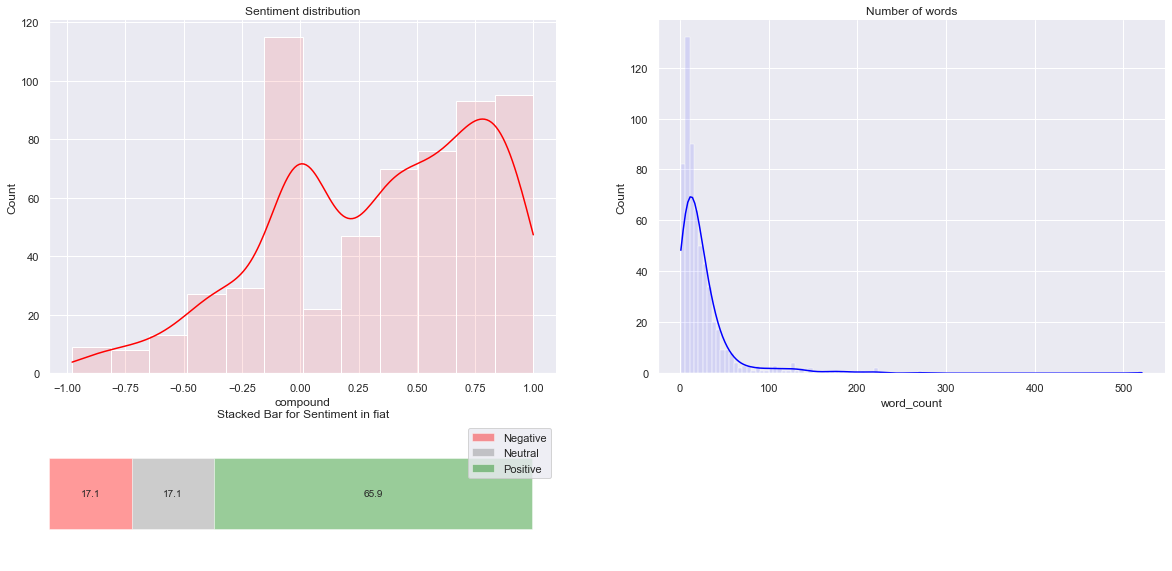

In [749]:
sentiment_explor_speakEV(topic_senti_mentionfiat,'Comment','fiat')


    Data information
    --------------------------------------
    Total number of comments: 587
    Average lenght of each reply: 245.88 characters
    Average words per comment: 38.1 words
    
    Number of positive comments (compound >0.05) is 403 (68.7%)
    Number of negative comments (compound <-0.05) is 114 (19.4%)
    Number of neutral comments (compound is between -0.05 and 0.05) is 70 (11.9%)
    
    Number of super positive comments (compound > 0.5) is 277 (47.2%)
    Number of super negative comments (compound < -0.5) is 40 (6.8%)
    --------------------------------------
    


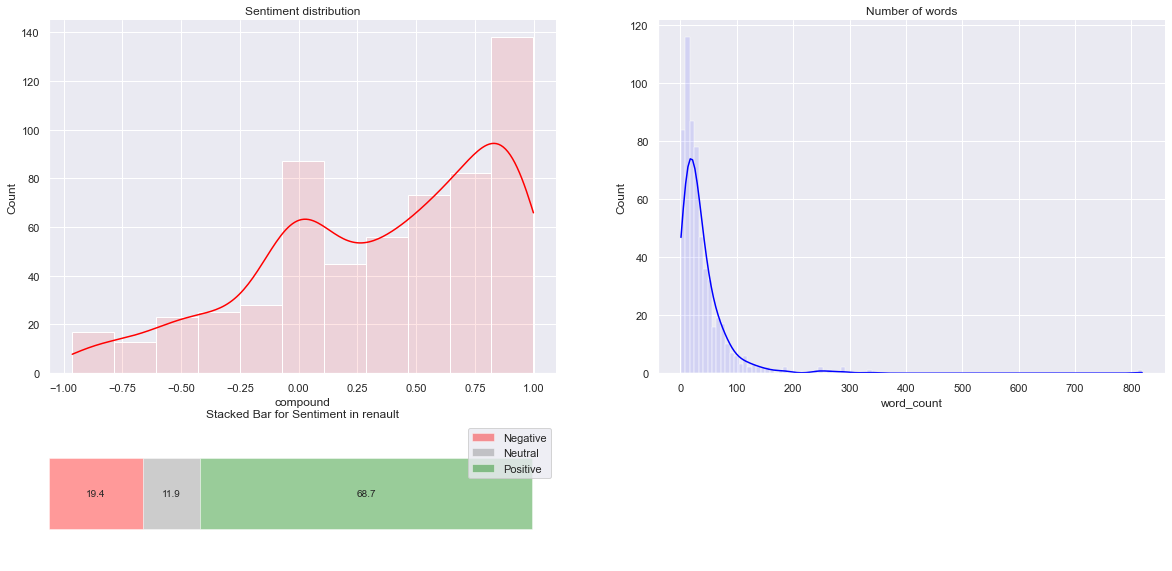

In [750]:
sentiment_explor_speakEV(topic_senti_mentionrenault,'Comment','renault')

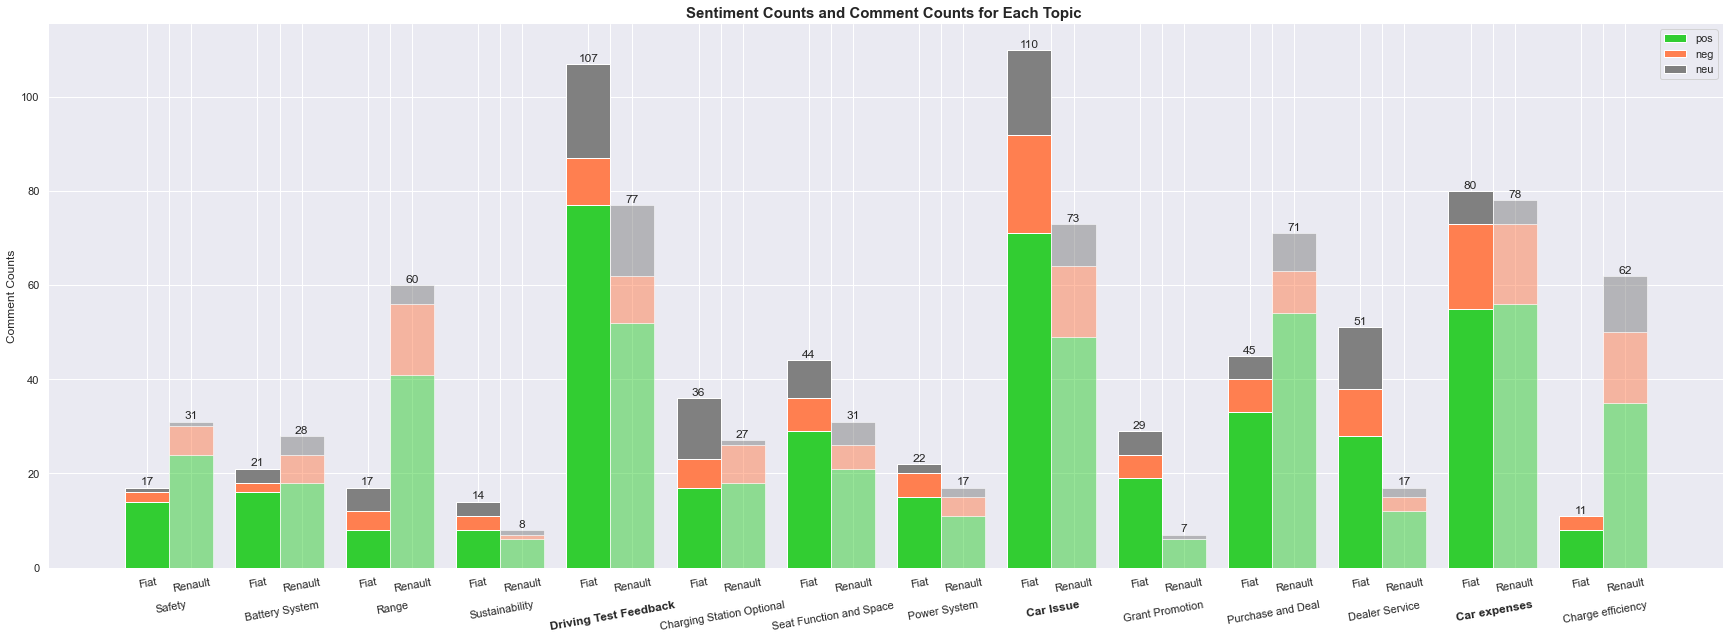

In [816]:
# def topics_sentiment_stack(df, column_name1, column_name2):

import xxlimited

topic_labels = ['Safety', 'Battery System','Range','Sustainability','Driving Test Feedback',
                'Charging Station Optional','Seat Function and Space','Power System','Car Issue',
                'Grant Promotion','Purchase and Deal','Dealer Service','Car expenses','Charge efficiency']
sentiment_labels = ['pos','neg','neu']
colors = ["limegreen","coral","grey"]
width =0.40

# x_pos = np.arange(0,18)
# x = np.arange(topic_senti_combined.shape[0])  # the label location

x = list()
ind = np.arange(14)
# x labels position: i = 1st bar, i+w/2 = category, i+w = 2nd bar
for i in ind:
    x.extend([i, i+width/2., i+width])  

# sns.set_style("whitegrid")
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 1, 1)

# Fiat, Renault
temp_fiat= topic_senti_wholeev.iloc[:,8:11]
temp_renault= topic_senti_wholeev.iloc[:,14:17]

# Fiat
ax.bar(ind, temp_fiat[sentiment_labels[0]], width,  label = sentiment_labels[0], color = colors[0],alpha = 1)
ax.bar(ind, temp_fiat[sentiment_labels[1]], width,   label = sentiment_labels[1], color = colors[1],bottom= temp_fiat[sentiment_labels[0]] ,alpha = 1)
ax.bar(ind, temp_fiat[sentiment_labels[2]], width,   label = sentiment_labels[2], color = colors[2],bottom= temp_fiat[sentiment_labels[0]] + temp_fiat[sentiment_labels[1]],alpha =1 )

fiat_count = topic_senti_wholeev.iloc[:, 8:11].sum(axis=1)
renault_count =  topic_senti_wholeev.iloc[:, 14:17].sum(axis=1)

for a, b in zip(ind, fiat_count):   
    plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=12)
for a, b in zip(ind+width, renault_count):   
    plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=12)

# Renault
ax.bar(ind+width, temp_renault[sentiment_labels[0]], width,  color = colors[0],alpha = 0.5)
ax.bar(ind+width, temp_renault[sentiment_labels[1]], width,  color = colors[1],bottom=  temp_renault[sentiment_labels[0]] , alpha = 0.5)
ax.bar(ind+width, temp_renault[sentiment_labels[2]], width,  color = colors[2],bottom=  temp_renault[sentiment_labels[0]] + temp_renault[sentiment_labels[1]], alpha = 0.5)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False) 


# Labelling 
# plt.xlabel("Discussion Date")
plt.ylabel("Comment Counts")
plt.xticks(x)

ax.set_xticklabels(('Fiat','\n\nSafety', 'Renault', 'Fiat','\n\nBattery System', 'Renault',
                    'Fiat','\n\nRange', 'Renault','Fiat','\n\nSustainability', 'Renault',
                    'Fiat','\n\nDriving Test Feedback', 'Renault','Fiat','\n\nCharging Station Optional', 'Renault',
                    'Fiat','\n\nSeat Function and Space', 'Renault','Fiat','\n\nPower System', 'Renault',
                    'Fiat','\n\nCar Issue', 'Renault', 'Fiat','\n\nGrant Promotion', 'Renault',
                    'Fiat','\n\nPurchase and Deal', 'Renault','Fiat','\n\nDealer Service', 'Renault',
                    'Fiat','\n\nCar expenses', 'Renault', 'Fiat','\n\nCharge efficiency','Renault'),ha='center',rotation = 10)

ax.set_title('Sentiment Counts and Comment Counts for Each Topic ',fontdict={'size': 15, 'weight': 700})

x_label = ax.get_xticklabels() 
# temp_labels = [x_label[1],x_label[7],x_label[10],x_label[13],x_label[19]]
temp_labels = [x_label[13],x_label[25],x_label[37]]
for label in temp_labels:
    label.set_fontweight('bold') 
    label.set_fontsize(12)

plt.legend()


Text(0.5, 1.0, 'Comment Sentiment Percentage for Each Topic')

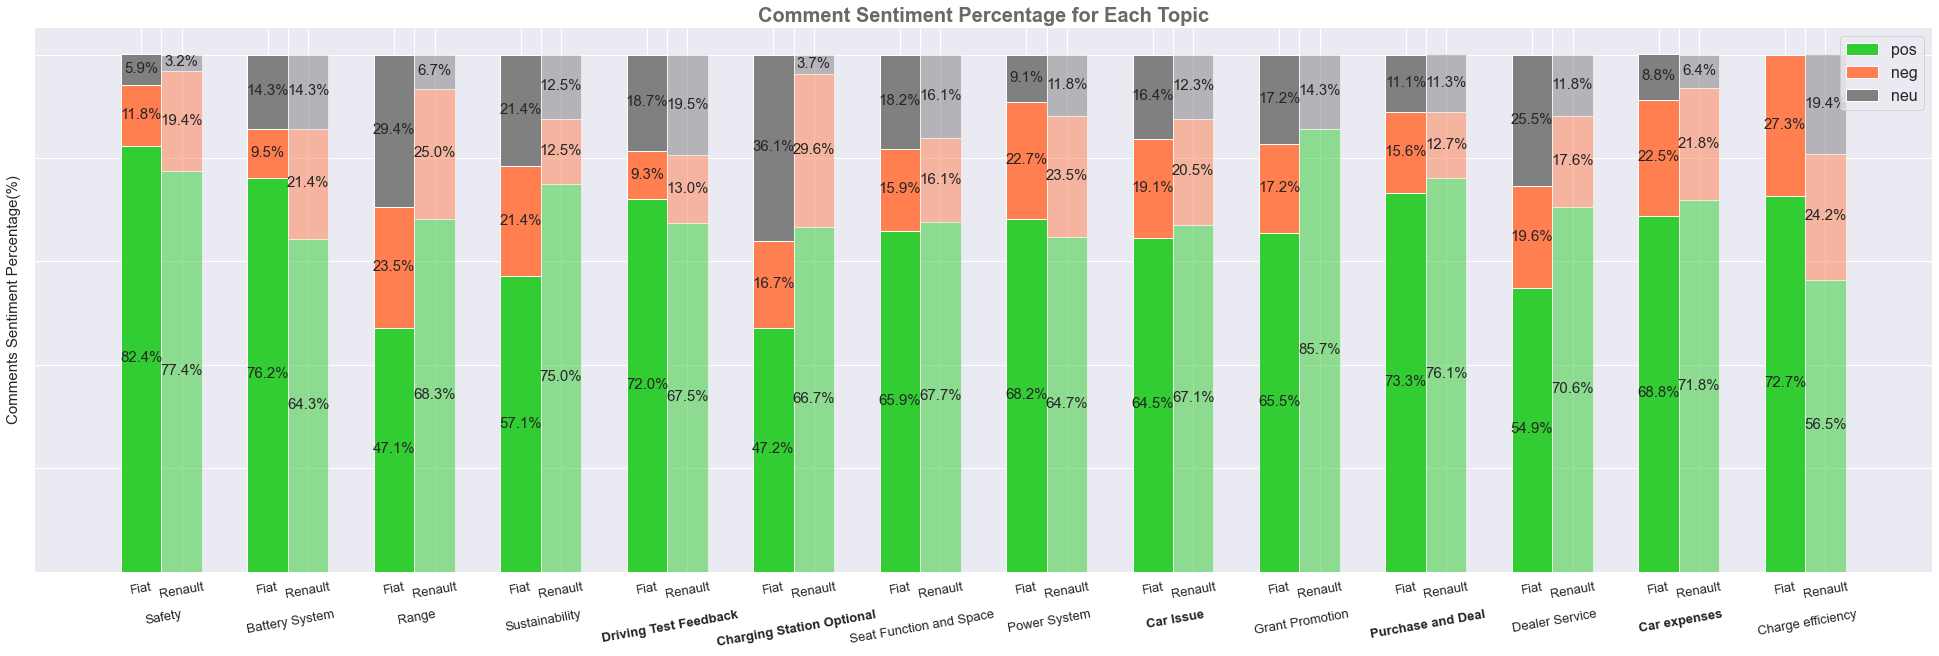

In [818]:
# def topics_sentiment_stack(df, column_name1, column_name2):

import xxlimited

topic_labels = ['Safety', 'Battery System','Range','Sustainability','Driving Test Feedback',
                'Charging Station Optional','Seat Function and Space','Power System','Car Issue',
                'Grant Promotion','Purchase and Deal','Dealer Service','Car expenses','Charge efficiency']

sentiment_labels = ['pos','neg','neu']
colors = ["limegreen","coral","grey"]
width =0.32

# x_pos = np.arange(0,18)
# x = np.arange(topic_senti_combined.shape[0])  # the label location

x = list()
ind = np.arange(14)
# x labels position: i = 1st bar, i+w/2 = category, i+w = 2nd bar
for i in ind:
    x.extend([i, i+width/2., i+width])  

# sns.set_style("whitegrid")
fig = plt.figure(figsize=(34, 10))
ax = fig.add_subplot(1, 1, 1)

# Fiat, Renault
temp_fiat= topic_senti_wholeev.iloc[:,8:11]
temp_renault= topic_senti_wholeev.iloc[:,14:17]

temp_fiat['sum'] = temp_fiat['pos']+temp_fiat['neu']+temp_fiat['neg']
temp_renault['sum'] = temp_renault['pos']+temp_renault['neu']+temp_renault['neg']


temp_fiat['pos_temp'] = round(temp_fiat['pos']/temp_fiat['sum']*100, 1)
temp_fiat['neg_temp'] = round(temp_fiat['neg']/temp_fiat['sum']*100, 1)
temp_fiat['neu_temp'] = round(temp_fiat['neu']/temp_fiat['sum']*100, 1)

temp_renault['pos_temp'] = round(temp_renault['pos']/temp_renault['sum']*100, 1)
temp_renault['neg_temp'] = round(temp_renault['neg']/temp_renault['sum']*100, 1)
temp_renault['neu_temp'] = round(temp_renault['neu']/temp_renault['sum']*100, 1)


#bev
ax.bar(ind, temp_fiat['pos_temp'], width,  label = sentiment_labels[0], color = colors[0],alpha = 1)
ax.bar(ind, temp_fiat['neg_temp'], width,   label = sentiment_labels[1], color = colors[1],bottom= temp_fiat['pos_temp'] ,alpha = 1)
ax.bar(ind, temp_fiat['neu_temp'], width,   label = sentiment_labels[2], color = colors[2],bottom= temp_fiat['pos_temp'] + temp_fiat['neg_temp'],alpha =1 )

ax.legend(fontsize = 16)

# hybrid
ax.bar(ind+width, temp_renault['pos_temp'], width,  label = sentiment_labels[0], color = colors[0],alpha = 0.5)
ax.bar(ind+width, temp_renault['neg_temp'], width,   label = sentiment_labels[1], color = colors[1],bottom= temp_renault['pos_temp'] ,alpha = 0.5)
ax.bar(ind+width, temp_renault['neu_temp'], width,   label = sentiment_labels[2], color = colors[2],bottom= temp_renault['pos_temp'] + temp_renault['neg_temp'],alpha = 0.5 )


# text
for a, b in zip(ind, temp_fiat['pos_temp']):   
    plt.text(a, b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)
for a, b in zip(ind+width, temp_renault['pos_temp']):   
    plt.text(a, b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)

for a, b, c in zip(ind, temp_fiat['neg_temp'], temp_fiat['pos_temp']):   
    if b!= 0:
        plt.text(a, c+b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)
for a, b, c in zip(ind+width, temp_renault['neg_temp'], temp_renault['pos_temp']):   
    if b!=0:
        plt.text(a, c+b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)

for a, b, c  in zip(ind, temp_fiat['neu_temp'], temp_fiat['neg_temp']+temp_fiat['pos_temp']):   
    if b!= 0:
        plt.text(a, c+b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)
for a, b, c in zip(ind+width,temp_renault['neu_temp'], temp_renault['neg_temp']+temp_renault['pos_temp']): 
    if b!= 0:  
        plt.text(a, c+b/2 + 0.1, str(b)+'%', ha='center', va='center', fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False) 


# Labelling 
plt.ylabel("Comments Sentiment Percentage(%)", size = 15)
# Ticks
ax.axes.yaxis.set_ticklabels([])

plt.xticks(x)

ax.set_xticklabels(('Fiat','\n\nSafety', 'Renault', 'Fiat','\n\nBattery System', 'Renault',
                    'Fiat','\n\nRange', 'Renault','Fiat','\n\nSustainability', 'Renault',
                    'Fiat','\n\nDriving Test Feedback', 'Renault','Fiat','\n\nCharging Station Optional', 'Renault',
                    'Fiat','\n\nSeat Function and Space', 'Renault','Fiat','\n\nPower System', 'Renault',
                    'Fiat','\n\nCar Issue', 'Renault', 'Fiat','\n\nGrant Promotion', 'Renault',
                    'Fiat','\n\nPurchase and Deal', 'Renault','Fiat','\n\nDealer Service', 'Renault',
                    'Fiat','\n\nCar expenses', 'Renault', 'Fiat','\n\nCharge efficiency','Renault'),ha='center',rotation = 10, size = 13)

x_label = ax.get_xticklabels() 
temp_labels = [x_label[16],x_label[25],x_label[37],x_label[13],x_label[31]]  #,x_label[19],x_label[25]
for label in temp_labels:
    label.set_fontweight('bold') 
    label.set_fontsize(13)
# Title
ax.set_title('Comment Sentiment Percentage for Each Topic', color = 'dimgray', fontdict={'size': 20, 'weight': 700})


- Align with the previous analysis and the requirement of specific topic selection, charging station optional was selected for the further competitor analysis. 

### PMI - Whole Electric

In [777]:
pmi_topic_wholeev = pd.concat([topic_larger,speakEV_BEV_wholeev[['Sentiment_corpus']]],axis=1)

### Fiat - Super Positive

In [778]:
pmi_fiat_df = pmi_topic_wholeev[(pmi_topic_wholeev['fiat'] == 1) & (pmi_topic_wholeev['renault'] != 1)]
pmi_sup_pos_fiat = pmi_fiat_df[pmi_fiat_df['compound'] > 0.5]
pmi_sup_pos_fiat['Main_topic1'].value_counts()

Topic 13    58
Topic 4     43
Topic 8     37
Topic 2     22
Topic 6     19
Topic 7     14
Topic 14    13
Topic 10    13
Topic 1     12
Topic 5     12
Topic 3      8
Topic 11     6
Topic 12     5
Topic 9      2
Name: Main_topic1, dtype: int64

### Renault - Super Positive

In [779]:
pmi_zoe_df = pmi_topic_wholeev[(pmi_topic_wholeev['fiat'] != 1) & (pmi_topic_wholeev['renault'] == 1)]
pmi_sup_pos_zoe  = pmi_zoe_df[pmi_zoe_df['compound'] > 0.5]
pmi_sup_pos_zoe['Main_topic1'].value_counts()

Topic 8     41
Topic 6     39
Topic 4     36
Topic 13    31
Topic 11    28
Topic 9     27
Topic 2     14
Topic 10    13
Topic 14    11
Topic 1     11
Topic 3      9
Topic 7      8
Topic 5      5
Topic 12     4
Name: Main_topic1, dtype: int64

### PMI - super positive in Topic 6 Purchases & Deal

In [780]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def tp6_pmi_zoe_pos(df,column_name):
    # Create one big corpus with words
    corpus_pmi_wholeev = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_wholeev))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_wholeev)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_wholeev)

    # See the best bigrams
    trigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [781]:
tp6_sup_pos_zoe = pmi_sup_pos_zoe[pmi_sup_pos_zoe['Main_topic1'] == 'Topic 6']
tp6_pos_best_bigrams,tp6_zoe_pos_best_triigrams = tp6_pmi_zoe_pos(df = tp6_sup_pos_zoe, column_name='Sentiment_corpus')
print(tp6_pos_best_bigrams)
print('----------')
print(tp6_zoe_pos_best_triigrams)

Number of words in the corpus: 1253
[('admin', 'fee'), ('affinity', 'fraser'), ('falkirk', 'stirlingshire'), ('fraser', 'falkirk'), ('annual', 'mileage'), ('breakdown', 'cover'), ('business', 'personal'), ('deposit', 'annual'), ('inc', 'vat'), ('mileage', 'allowance'), ('green', 'black'), ('seat', 'mii'), ('auto', 'personal'), ('black', 'friday'), ('contact', 'driveelectric'), ('long', 'journey'), ('green', 'friday'), ('find', 'business'), ('takemylease', 'uk'), ('mii', 'hatchback'), ('gt', 'line'), ('rapid', 'charge'), ('range', 'rapid'), ('line', 'rapid'), ('charge', 'auto'), ('quick', 'charge'), ('vat', 'gt'), ('allowance', 'mile'), ('buy', 'hand'), ('mile', 'pa'), ('drive', 'uk'), ('driveelectric', 'find'), ('month', 'inc'), ('mile', 'annum'), ('definitely', 'good'), ('hatchback', 'gt'), ('sell', 'buy'), ('work', 'mile'), ('month', 'deposit'), ('personal', 'month'), ('ze', 'month'), ('deal', 'moment'), ('hatchback', 'month'), ('lease', 'driveelectric'), ('find', 'cheap'), ('lease',

In [782]:
tp6_sup_pos_zoe.shape[0]/ pmi_sup_pos_zoe.shape[0]

0.1407942238267148

Main Takeaways:
- Overall, Renault-Zoe has a slight better performance than Fiat-500 model. 
- Driving Test Feedback，Car Issue and Car Expenses are the top three themes dicussed within the whole electric car subset. There is no sigificant sentiment variances between Fiat500 and Renault Zoe for these three topics. 
- Compared with Fiat-500, Renault-Zoe has more super positive comments, with 47.2% of consumers. 两个模型super positive comments主要讨论的话题也是热议的3个话题，其中不同点是，Renault Zoe 有14% 的super positive讨论purchase& deal话题。 PMI发现：
- Renault Zoe has a good reputation in the lease service for both business partner and personal side, which has 3% higher of positive percentage than Fiat 500. 
('business', 'personal', 'lease'),  ('personal', 'lease', 'drive'), 

### PMI - Charging Station Optional for Renault Zoe - Positive

In [783]:
# Finding bigrams using PMI measure
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

def pmi_zoe_chargingstation_pos(df,column_name):
    # Create one big corpus with words
    corpus_pmi_wholeev = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_wholeev))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_wholeev)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_wholeev)

    # See the best bigrams
    trigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [784]:
tp14_zoe  = pmi_zoe_df[pmi_zoe_df['Main_topic1'] =='Topic 14']
tp14_zoe_pos = tp14_zoe[tp14_zoe['sentiment'] == 'pos']
t14_pos_best_bigrams,tp14_zoe_pos_best_triigrams = pmi_zoe_chargingstation_pos(df = tp14_zoe_pos, column_name='Sentiment_corpus')
print(t14_pos_best_bigrams)
print('----------')
print(tp14_zoe_pos_best_triigrams)

Number of words in the corpus: 1215
[('convenient', 'green'), ('football', 'notice'), ('green', 'flash'), ('leafs', 'convenient'), ('parent', 'football'), ('recognise', 'leafs'), ('relax', 'enjoy'), ('shell', 'recharge'), ('sun', 'enable'), ('village', 'parent'), ('zipcar', 'forever'), ('conspicuous', 'absence'), ('definitely', 'noticeable'), ('flash', 'definitely'), ('gt', 'line'), ('hampshire', 'resident'), ('resident', 'sun'), ('able', 'relax'), ('proselytize', 'able'), ('good', 'recognise'), ('pv', 'couple'), ('absence', 'bournemouth'), ('bournemouth', 'airport'), ('let', 'friend'), ('weekend', 'let'), ('day', 'village'), ('mile', 'pv'), ('ze', 'gt'), ('line', 'ccs'), ('week', 'holiday'), ('bournemouth', 'weekend'), ('occasional', 'visitor'), ('enable', 'free'), ('choose', 'destination'), ('council', 'install'), ('parking', 'area'), ('enjoy', 'trip'), ('notice', 'trip'), ('book', 'activity'), ('phev', 'driver'), ('drive', 'proselytize'), ('charger', 'conspicuous'), ('ikea', 'charge

Main Takeaway:
- The words occurences such as ikea charger, noticeable charger, absence airport within the topic of Renault-zoe charging station optional, indicating that it is easier for Renault-zoe drivers to find optional charging station. Based on the webiste of the ElectroMaps, the operating instructions compatible with Nissan Leafs and Renault Zoe but Fiat 500 https://www.electromaps.com/en/charging-stations/21143_ikea -> should improve the corporation with charging station operaters. expose more noticeable charging station for the drivers. 
('ikea', 'charger'), ('absence', 'bournemouth', 'airport'), ('noticeable', 'charger', 'conspicuous'),